# **EDA 4. ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА**

## **1. Подготовка и обработка данных**

### **1.1 Загружаем библиотеки для работы с данными, статистического анализа, визуализации данных, для кодирования категориальных данных**

In [376]:
# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для статистического анализа
from scipy import stats
from scipy.stats import shapiro, kruskal, pearsonr, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import scikit_posthocs as sp

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Библиотека для кодирования категориальных данных
from sklearn.preprocessing import OrdinalEncoder


### **1.2 Загружаем данные из *CSV*-файла `ds_salaries.csv` в *DataFrame* `df`, используя первый столбец файла как индексы строк, и выводим первые и последние 5 строк для ознакомления с данными**

In [377]:
# Чтение CSV-файла 'ds_salaries.csv' с указанием столбца индексов
df = pd.read_csv('c:/github/sf_ds/EDA_4_HW_02/data/ds_salaries.csv', index_col=[0])

# Отображение первых 5 строк DataFrame для предварительного ознакомления с данными
display(df.head(5))

# Отображение последних 5 строк DataFrame для проверки окончания данных
display(df.tail(5))


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


### **1.3 Выводим общую информацию о структуре и содержимом *DataFrame*, оцениваем размер данных, наличие пропусков, типы данных в каждом столбце**

In [378]:
# Вывод общей информации о DataFrame:
# включает количество записей, количество ненулевых значений в каждом столбце, типы данных, использование памяти
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


**Подсчитаем количество дубликатов, удалим их (если они есть), и выведим размер *DataFrame* после удаления**

In [379]:
# Подсчет количества дубликатов в DataFrame
duplicates = df.duplicated().sum()
print(f"Найдено дубликатов: {duplicates}")

# Если дубликаты есть, удаляем их
if duplicates > 0:
    df = df.drop_duplicates()
    print("Все дубликаты успешно удалены")

# Вывод размерности DataFrame после удаления дубликатов
print(f"Текущие размеры датафрейма после удаления дубликатов: {df.shape}")


Найдено дубликатов: 42
Все дубликаты успешно удалены
Текущие размеры датафрейма после удаления дубликатов: (565, 11)


### **1.4 Выполним отчистку данных**

**Удаляем неинформативные столбцы `salary` и `salary_currency` из *DataFrame* и выводим его новую размерность**

In [380]:
# Удаление неинформативных столбцов из DataFrame
df.drop(['salary', 'salary_currency'], axis=1, inplace=True)

# Вывод новой размерности DataFrame после удаления столбцов
print(df.shape)


(565, 9)


Для анализа используем `salary_in_usd` (представляет зарплату в единой валюте).

**Выводим полное статистическое описание для всех столбцов *DataFrame*, включая числовые и категориальные данные**

In [381]:
# Вывод статистического описания всех столбцов DataFrame
# Для числовых данных выводятся такие метрики, как среднее, медиана, стандартное отклонение и т.д.
# Для категориальных данных выводятся количество уникальных значений, мода и т.д.
df.describe(include='all')


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565,565.000000,565,565.000000,565,565
unique,NaN,4,4,50,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,US,NaN,US,M
freq,NaN,243,546,130,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,150000.000000,NaN,100.000000,NaN,NaN


### **1.5 Подсчитываем и выводим количество уникальных значений для каждого столбца *DataFrame***

In [382]:
# Подсчет количества уникальных значений для каждого столбца DataFrame
unique_values = df.nunique()

# Вывод количества уникальных значений для каждого столбца
print(unique_values)


work_year               3
experience_level        4
employment_type         4
job_title              50
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64


**Числовые признаки**:
- `work_year`;
- `salary_in_usd`.

**Категориальные (дискретные) признаки**:
- `remote_ratio`;
- `experience_level`;
- `employment_type`;
- `job_title`;
- `employee_residence`;
- `company_location`;
- `company_size`.

## **2. Визуальный анализ данных**

**Расчитаем основные статистические показатели для выбранного признака**

### **2.1 Анализ признака salary_in_usd (запралата в долларах США)**

In [383]:
# Рассчет моды зарплат в долларах США
salary_mode = df['salary_in_usd'].mode()[0]

# Рассчет минимальной зарплаты
salary_min = df['salary_in_usd'].min()

# Рассчет максимальной зарплаты
salary_max = df['salary_in_usd'].max()

# Рассчет средней зарплаты (mean)
salary_mean = df['salary_in_usd'].mean()

# Рассчет стандартного отклонения зарплат
salary_std = df['salary_in_usd'].std()

# Рассчет квартилей зарплат (25-й, 50-й, 75-й процентиль)
salary_quantiles = df['salary_in_usd'].quantile([0.25, 0.5, 0.75]).to_list()

# Рассчет p-значения теста на нормальность
salary_normaltest_pvalue = stats.normaltest(df['salary_in_usd']).pvalue

# Рассчет медианного абсолютного отклонения (MAD)
mad_salary = (df['salary_in_usd'] - df['salary_in_usd'].median()).abs().median()

# Рассчет коэффициента асимметрии (skewness) зарплат
skewness_salary = df['salary_in_usd'].skew()

# Рассчет коэффициента эксцесса (kurtosis) зарплат
kurtosis_salary = df['salary_in_usd'].kurtosis()

# Вывод общей статистики по зарплатам
print(f"Общая статистика:")
print(f"Наиболее частая зарплата: {salary_mode} USD")
print(f"Самая низкая зарплата: {salary_min} USD")
print(f"Самая высокая зарплата: {salary_max} USD")
print(f"Средняя зарплата: {salary_mean} USD")
print(f"Стандартное отклонение зарплат: {salary_std} USD")
print(f"Квартильные значения зарплат: {salary_quantiles}")
print(f"P-значение теста на нормальность распределения зарплат: {salary_normaltest_pvalue}")
print(f"Медианное абсолютное отклонение (MAD): {mad_salary} USD")
print(f"Асимметрия распределения зарплат: {skewness_salary}")
print(f"Эксцесс распределения зарплат: {kurtosis_salary}\n")

# Получение уникальных значений годов
years = df['work_year'].unique()

# Создание словаря для хранения статистики по годам
salary_stats_by_year = {}

# Рассчет статистики по зарплатам для каждого года
for year in years:
    # Фильтрация данных по конкретному году
    data_by_year = df[df['work_year'] == year]['salary_in_usd']
    
    # Сохранение статистики по зарплатам для данного года
    salary_stats_by_year[year] = {
        'mode': data_by_year.mode()[0],
        'min': data_by_year.min(),
        'max': data_by_year.max(),
        'mean': data_by_year.mean(),
        'std': data_by_year.std(),
        'quantiles': data_by_year.quantile([0.25, 0.5, 0.75]).to_list(),
        'normaltest_pvalue': stats.normaltest(data_by_year).pvalue,
        'mad': (data_by_year - data_by_year.median()).abs().median(),
        'skewness': data_by_year.skew(),
        'kurtosis': data_by_year.kurtosis()
    }

# Вывод статистики по каждому году
for year, stats in salary_stats_by_year.items():
    print(f"Статистика за {year} год:")
    print(f"Наиболее частая зарплата: {stats['mode']} USD")
    print(f"Самая низкая зарплата: {stats['min']} USD")
    print(f"Самая высокая зарплата: {stats['max']} USD")
    print(f"Средняя зарплата: {stats['mean']} USD")
    print(f"Стандартное отклонение зарплат: {stats['std']} USD")
    print(f"Квартильные значения зарплат: {stats['quantiles']}")
    print(f"P-значение теста на нормальность распределения зарплат: {stats['normaltest_pvalue']}")
    print(f"Медианное абсолютное отклонение (MAD): {stats['mad']} USD")
    print(f"Асимметрия распределения зарплат: {stats['skewness']}")
    print(f"Эксцесс распределения зарплат: {stats['kurtosis']}\n")



Общая статистика:
Наиболее частая зарплата: 100000 USD
Самая низкая зарплата: 2859 USD
Самая высокая зарплата: 600000 USD
Средняя зарплата: 110610.34336283186 USD
Стандартное отклонение зарплат: 72280.70279190093 USD
Квартильные значения зарплат: [60757.0, 100000.0, 150000.0]
P-значение теста на нормальность распределения зарплат: 1.3597635366967697e-50
Медианное абсолютное отклонение (MAD): 43262.0 USD
Асимметрия распределения зарплат: 1.7328374573354977
Эксцесс распределения зарплат: 6.451699997093703

Статистика за 2020 год:
Наиболее частая зарплата: 6072 USD
Самая низкая зарплата: 5707 USD
Самая высокая зарплата: 450000 USD
Средняя зарплата: 95813.0 USD
Стандартное отклонение зарплат: 82831.79922224536 USD
Квартильные значения зарплат: [45724.5, 75544.0, 115526.0]
P-значение теста на нормальность распределения зарплат: 6.631958645434345e-12
Медианное абсолютное отклонение (MAD): 33699.5 USD
Асимметрия распределения зарплат: 2.3337964298653326
Эксцесс распределения зарплат: 6.832413

### **Выводы**:
1. **Общая статистика:**
   - **Наиболее частая зарплата:** 100000 USD, что свидетельствует о частой концентрации зарплат в этом диапазоне.
   - **Самая низкая и самая высокая зарплаты:** Диапазон зарплат очень широкий (от 2859 до 600000 USD), что указывает на значительную разницу в уровне оплаты труда среди сотрудников.
   - **Средняя зарплата:** 110610 USD указывает на высокие заработки в сфере, хотя они и варьируются.
   - **Стандартное отклонение:** 72280 USD говорит о значительных разбросах зарплат вокруг среднего значения.
   - **Квартильные значения:** 25% работников получают менее 60757 USD, 50% — менее 100000 USD, а 75% — менее 150000 USD, что свидетельствует о высокой дифференциации доходов.
   - **P-значение теста на нормальность:** Распределение зарплат далеко от нормального (p-value ≈ 0), вероятно, с большим количеством более высоких значений.
   - **Асимметрия и эксцесс:** Высокие значения (1.73 и 6.45) указывают на сильный положительный перекос и толстые хвосты распределения, что может быть связано с наличием очень высоких зарплат в выборке.

2. **2020 год:**
   - **Наиболее частая зарплата:** 6072 USD — резко ниже общей статистики, что говорит о низкой оплате труда среди большей части сотрудников в этот период.
   - **Широкий разброс зарплат:** В 2020 году диапазон также был значительным (от 5707 до 450000 USD), но средняя зарплата (95813 USD) ниже, чем в целом.
   - **Стандартное отклонение (82831 USD)** — ещё выше, чем в общей статистике, что свидетельствует о большем разбросе зарплат в 2020 году.
   - **Асимметрия и эксцесс:** Высокие значения асимметрии (2.33) и эксцесса (6.83) указывают на то, что в 2020 году наблюдалась более выраженная концентрация низких зарплат с редкими высокими значениями.

3. **2021 год (выборочная статистика):**
   - **Медианное абсолютное отклонение (MAD):** 40040 USD, что немного ниже, чем в общей выборке, указывает на меньший разброс зарплат по сравнению с 2020 годом.
   - **Асимметрия (0.88):** Близка к симметрии, что говорит о более равномерном распределении зарплат, чем в предыдущие годы.
   - **Эксцесс (2.12):** Указывает на наличие более толстых хвостов, чем в нормальном распределении, но ситуация менее экстремальная по сравнению с 2020 годом.

### **Причины и гипотезы**:
1. **Разброс зарплат и высокие выбросы:**
   - Высокие значения асимметрии и эксцесса могут быть вызваны наличием небольшого числа очень высоких зарплат в выборке, возможно, топ-менеджеров или сотрудников в крупных компаниях и экономически развитых регионах.
   - Вероятно, что в IT и Data Science рынок сильно сегментирован, и разница в зарплатах между новичками и высококвалифицированными специалистами значительно велика.

2. **Изменения в 2020 году:**
   - Низкая наиболее частая зарплата в 2020 году (6072 USD) может быть связана с экономическими последствиями пандемии COVID-19, что привело к сокращению рабочих мест или снижению уровня оплаты труда для многих работников.
   - Высокая асимметрия и эксцесс в 2020 году также могут свидетельствовать о том, что высокие зарплаты оставались в меньшинстве, в то время как основной рынок переживал значительное снижение доходов.

3. **Восстановление в 2021 году:**
   - Снижение асимметрии и эксцесса в 2021 году может указывать на некоторое восстановление рынка, с возвращением более стабильного распределения зарплат.

### **Предложения**:
1. **Углублённый анализ по категориям:**
   - Провести анализ зарплат по различным категориям, таким как размер компании, уровень опыта сотрудников, отрасль, а также регион работы, чтобы более точно объяснить причины разброса зарплат.
   
2. **Анализ влияния пандемии:**
   - Исследовать влияние пандемии на уровень зарплат в разные годы, особенно для 2020 и 2021 годов, чтобы понять, какие факторы (сокращение рабочих мест, удалённая работа, спад в экономике) наиболее сильно влияли на рынок труда.

3. **Моделирование и прогнозирование:**
   - Провести моделирование для предсказания уровня зарплат в последующие годы с учётом текущих макроэкономических условий и трендов на рынке труда.
   
4. **Фокус на стабилизацию зарплат:**
   - Если компания рассматривает HR-стратегию, может быть полезно фокусироваться на поддержании стабильных уровней зарплат для предотвращения увеличения разрыва между низкими и высокими зарплатами, что может улучшить равенство и мотивацию сотрудников.

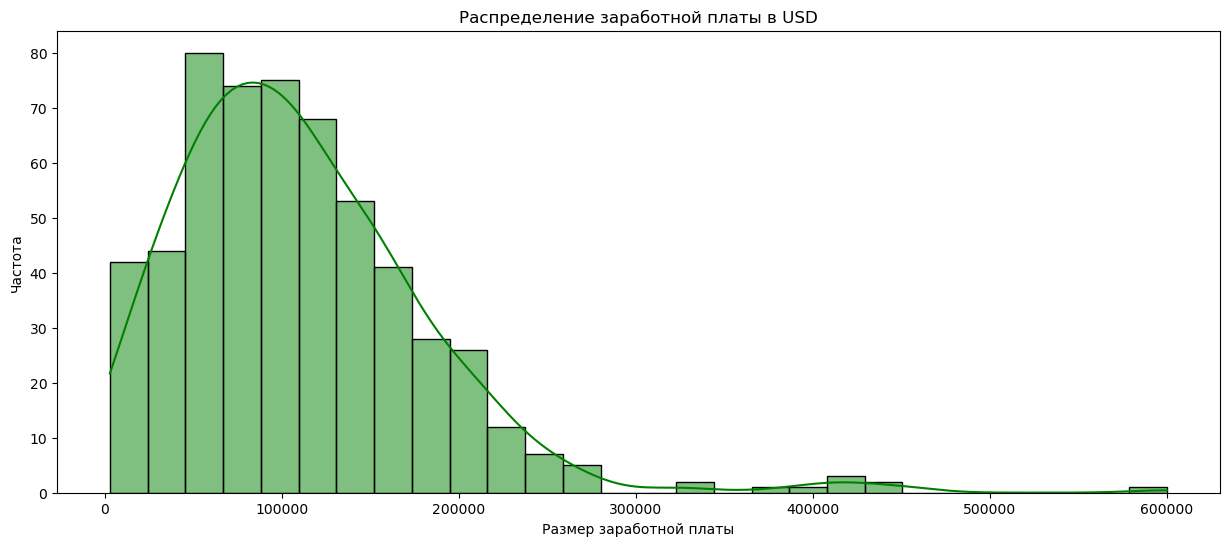

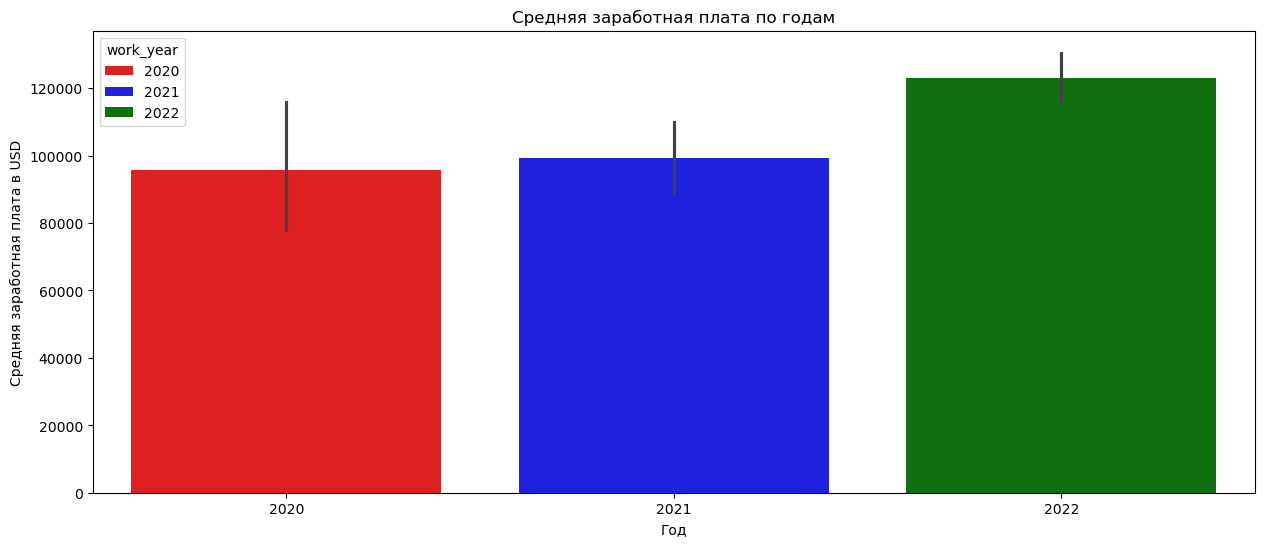

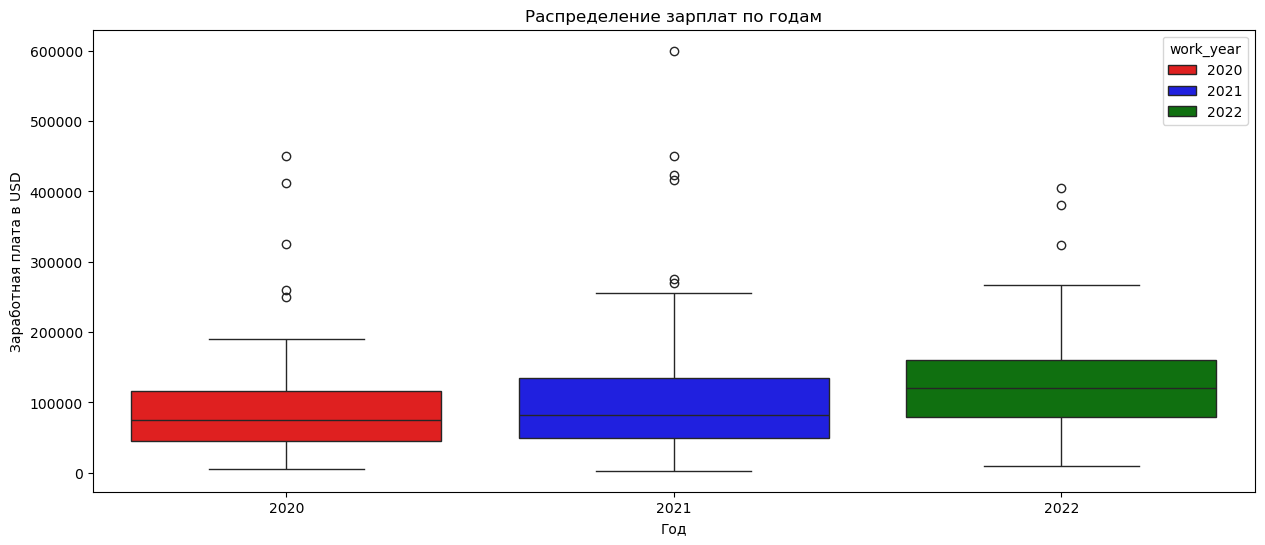

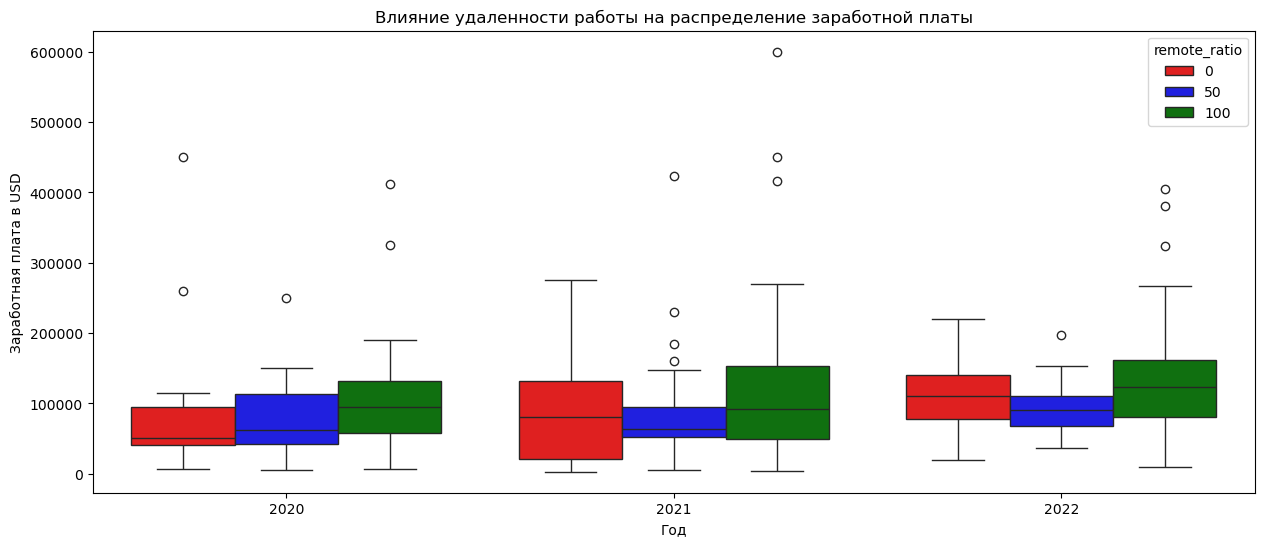

In [384]:
# Функция для настройки и отображения графиков
def plot_chart(plot_func, title, xlabel, ylabel, **kwargs):
    plt.figure(figsize=(15, 6))
    plot_func(**kwargs)  # Построение графика с переданными параметрами
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Построение гистограммы с KDE
plot_chart(
    sns.histplot,
    title='Распределение заработной платы в USD',
    xlabel='Размер заработной платы',
    ylabel='Частота',
    data=df['salary_in_usd'], kde=True, color="green"
)

# Построение столбчатой диаграммы средней зарплаты по годам
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по годам',
    xlabel='Год',
    ylabel='Средняя заработная плата в USD',
    x='work_year', y='salary_in_usd', data=df, estimator=np.mean, hue='work_year', palette=['red', 'blue', 'green']
)

# Построение boxplot по годам
plot_chart(
    sns.boxplot,
    title='Распределение зарплат по годам',
    xlabel='Год',
    ylabel='Заработная плата в USD',
    x='work_year', y='salary_in_usd', data=df, hue='work_year', palette=['red', 'blue', 'green']
)

# Построение boxplot для отображения зарплат в зависимости от удаленности работы
plot_chart(
    sns.boxplot,
    title='Влияние удаленности работы на распределение заработной платы',
    xlabel='Год',
    ylabel='Заработная плата в USD',
    x='work_year', y='salary_in_usd', data=df, hue='remote_ratio', palette=['red', 'blue', 'green']
)


### **Выводы по графику распределения заработной платы**:

1. **Положительная асимметрия (правостороннее смещение)**:
- Гистограмма показывает явную положительную асимметрию. Большинство сотрудников получают зарплату в диапазоне до 150000 USD, в то время как есть несколько высоких значений, достигающих 600000 USD.   
- Основная масса зарплат сосредоточена в диапазоне от 50000 до 150000 USD, что согласуется с вычисленными квартильными значениями.

2. **Длинный правый хвост**:
- Хвост распределения заметно вытянут в сторону более высоких значений, что подтверждает наличие крайне высоких зарплат (выбросов), которые сильно влияют на общую среднюю зарплату и другие статистические показатели, такие как стандартное отклонение и эксцесс.

3. **Частая зарплата около 100000 USD**:
- На графике видно, что наибольшее количество сотрудников (частота около 80) получают зарплату в диапазоне около 100000 USD, что подтверждает наиболее частую заработную плату (моду) в выборке.

4. **Сглаженная кривая**:
- Наложенная на гистограмму сглаженная кривая (ядерная оценка плотности) также подчеркивает положительную асимметрию и показывает, что основные частоты сосредоточены в диапазоне 50-150 тысяч USD.

5. **Выводы для дальнейшего анализа**:
- Видимая асимметрия и наличие экстремальных выбросов может означать, что анализ средних значений и медианы требует осторожного подхода. Следует рассмотреть использование дополнительных метрик, таких как медиана или MAD (медианное абсолютное отклонение), чтобы учесть влияние выбросов.    
- Рекомендуется провести отдельный анализ высоких зарплат и оценить их влияние на общую статистику.  

### **Выводы по графику средней заработной платы по годам**:
1. Рост средней заработной платы:
- График демонстрирует явный рост средней заработной платы с 2020 по 2022 годы.    
- В 2020 году средняя зарплата была самой низкой, около 95000 USD. В 2021 году она несколько увеличилась, а в 2022 году достигла максимума — около 115000 USD.

2. **Влияние пандемии**:
- Низкий уровень средней зарплаты в 2020 году может быть связан с последствиями пандемии COVID-19, которые повлияли на экономическую ситуацию, рынок труда и зарплаты.   
- Восстановление в 2021 году сопровождается небольшим ростом средней зарплаты, а в 2022 году наблюдается явное увеличение.

3. **Увеличение разброса зарплат**:
- Черные линии на графике, представляющие стандартное отклонение, показывают увеличение разброса зарплат с 2020 по 2022 годы. Это означает, что разброс зарплат среди сотрудников также увеличивается, возможно, из-за повышения зарплат высококвалифицированных специалистов.

4. **Общие тренды**:
- Наблюдается положительная динамика средней зарплаты, что свидетельствует о росте спроса на высокооплачиваемые вакансии, особенно в 2022 году.   
- Возможно, этот рост также связан с увеличением стоимости жизни, инфляцией и глобальными изменениями на рынке труда.

**Рекомендации**:
- Следует проанализировать, какие факторы повлияли на рост зарплат в 2022 году, например, увеличение числа вакансий, удаленная работа или увеличение спроса на специалистов с высоким уровнем квалификации.  
- Рекомендуется также изучить влияние этих изменений на различные категории работников, чтобы определить, какие группы получили наибольшие выгоды от роста зарплат.

### **Выводы по графику распределения зарплат по годам**:

1. **Медианная зарплата:**
   - Медианные значения зарплат увеличиваются с 2020 по 2022 год, что подтверждает общий рост средней зарплаты по годам.  
   - В 2020 году медиана зарплаты была самой низкой, а в 2022 году — самой высокой.

2. **Разброс зарплат:**
   - В 2020 году диапазон зарплат (интерквартильный размах) был наименьшим, что свидетельствует о более сжатом распределении зарплат. Верхняя граница "усов" меньше, что также подтверждает меньшее количество высоких зарплат.  
   - В 2021 и 2022 годах наблюдается увеличение диапазона, что говорит о большем разбросе зарплат. Это может быть связано с ростом высоких зарплат и увеличением доли специалистов с более высокими доходами.

3. **Выбросы (экстремальные значения):**
   - В каждом году присутствуют выбросы (очень высокие зарплаты), особенно заметны в 2021 и 2022 годах, где максимальные значения достигают более 500000 USD. Это указывает на наличие небольшого числа сотрудников с очень высокими доходами, которые значительно выделяются на фоне основной массы.  
   - В 2020 году количество выбросов меньше, что может быть связано с более стабильной ситуацией на рынке труда до пандемии.

4. **Стабильность нижней границы:**
   - Нижняя граница зарплат в 2020 году также выше по сравнению с 2021 и 2022 годами, что может указывать на снижение минимальных зарплат в более поздние годы или увеличение диапазона заработной платы среди всех категорий сотрудников.

**Общие выводы**:
- **Рост зарплат:** График подтверждает положительный тренд на рост зарплат с 2020 по 2022 годы. В 2022 году зарплаты становятся более дифференцированными, с увеличением как медианы, так и разброса доходов.  
- **Увеличение неравенства:** Расширение диапазона зарплат и увеличение количества выбросов указывает на возможное увеличение неравенства в доходах между сотрудниками, где высококвалифицированные специалисты получают значительно больше по сравнению с остальными.  
- **Экономическая нестабильность:** 2020 год может рассматриваться как более стабильный с точки зрения распределения зарплат, в то время как в 2021 и 2022 годах рынок труда становится более изменчивым с широким диапазоном зарплат и присутствием экстремальных значений.  

Рекомендуется провести дополнительный анализ по конкретным группам сотрудников (например, по уровню опыта, регионам или должностям), чтобы более точно понять причины роста зарплат и неравенства в эти годы.

### **Выводы по графику влияния удаленности работы на распределение заработной платы**:

1. **Медиана зарплаты по уровням удаленности:**
   - В каждый из анализируемых годов (2020, 2021, 2022) наблюдается тенденция к тому, что сотрудники, работающие удаленно (100% удаленная работа), имеют более высокую медианную заработную плату по сравнению с теми, кто работает частично удаленно (50%) или в офисе (0% удаленности).  
   - В 2020 и 2022 годах медианные зарплаты для полностью удаленных сотрудников значительно выше, чем для сотрудников с офисной или частично удаленной работой.

2. **Диапазон зарплат:**
   - Диапазон зарплат (разброс) также увеличивается для полностью удаленных работников (remote_ratio = 100), что означает, что среди сотрудников с удаленной работой есть как высокооплачиваемые специалисты, так и сотрудники с более низкими зарплатами.  
   - У сотрудников с нулевой удаленностью (работающих в офисе) диапазон зарплат более сжат, особенно в 2021 и 2022 годах.

3. **Выбросы:**
   - В каждом из годов можно наблюдать наличие выбросов, особенно среди полностью удаленных сотрудников, что указывает на наличие крайне высоких зарплат. В 2021 и 2022 годах максимальные зарплаты среди удаленных сотрудников достигают более 500000 USD.  
   - У офисных сотрудников (remote_ratio = 0) количество выбросов меньше, что подтверждает меньший разброс и более стабильные зарплаты.

4. **Изменения по годам:**
   - В 2020 году различия в зарплатах между различными уровнями удаленности были менее выраженными, хотя полностью удаленные сотрудники уже тогда имели чуть более высокие медианы.  
   - В 2021 году наблюдается более резкий разрыв в зарплатах для удаленных сотрудников по сравнению с офисными.  
   - В 2022 году эта тенденция сохраняется, с высоким разбросом зарплат для удаленных сотрудников и более стабильными доходами у тех, кто работает в офисе или частично удаленно.

**Общие выводы**:
- **Удаленная работа повышает зарплату:** Полностью удаленная работа коррелирует с более высокими зарплатами, что может быть связано с увеличением спроса на удаленные вакансии и глобализацией рынка труда, когда сотрудники могут работать на компании из разных регионов и стран с более высокими зарплатами.  
- **Рост значимости удаленной работы:** В 2021 и 2022 годах удаленная работа стала более востребованной, что привело к росту зарплат для тех, кто перешел на полный удаленный формат.  
- **Неравенство в доходах:** Удаленная работа также демонстрирует больший разброс зарплат, что указывает на возможное неравенство в доходах среди удаленных сотрудников, где есть как низкооплачиваемые, так и очень высокооплачиваемые специалисты.  

**Рекомендации**:
- Провести дальнейший анализ для изучения конкретных факторов, влияющих на рост зарплат среди удаленных сотрудников (например, уровень квалификации, регион или должность).  
- Оценить влияние удаленной работы на долгосрочные тренды в оплате труда и неравенстве на рынке.

**Вычисляем и выводим основную статистику по зарплатам для *Data Scientist* и *Data Engineer*, как в общем виде, так и по годам**

In [385]:
from scipy import stats

# Функция для расчета статистики
def calculate_stats(data):
    return {
        'count': data.shape[0],
        'mean': data['salary_in_usd'].mean(),
        'std': data['salary_in_usd'].std(),
        'min': data['salary_in_usd'].min(),
        'max': data['salary_in_usd'].max(),
        'quantiles': data['salary_in_usd'].quantile([0.25, 0.5, 0.75]).to_list(),
        'normaltest_pvalue': stats.normaltest(data['salary_in_usd'].dropna()).pvalue,
        'mad': (data['salary_in_usd'] - data['salary_in_usd'].median()).abs().median(),
        'skewness': data['salary_in_usd'].skew(),
        'kurtosis': data['salary_in_usd'].kurtosis()
    }

# Получение уникальных годов
years = df['work_year'].unique()

# Функция для вывода статистики по годам
def calculate_stats_by_years(job_title):
    stats_by_year = {}
    for year in years:
        data_by_year = df[(df['job_title'] == job_title) & (df['work_year'] == year)]
        stats_by_year[year] = calculate_stats(data_by_year)
    return stats_by_year

# Общая статистика по всем данным для Data Scientist и Data Engineer
ds_stats_all = calculate_stats(df[df['job_title'] == 'Data Scientist'])
de_stats_all = calculate_stats(df[df['job_title'] == 'Data Engineer'])

# Статистика по годам для Data Scientist и Data Engineer
ds_stats_by_year = calculate_stats_by_years('Data Scientist')
de_stats_by_year = calculate_stats_by_years('Data Engineer')

# Функция для вывода статистики
def print_stats(title, stats):
    print(f"{title}:")
    print(f"Количество записей: {stats['count']}")
    print(f"Средняя заработная плата: {stats['mean']} USD")
    print(f"Стандартное отклонение: {stats['std']} USD")
    print(f"Минимальная зарплата: {stats['min']} USD")
    print(f"Максимальная зарплата: {stats['max']} USD")
    print(f"Квантили: {stats['quantiles']}")
    print(f"P-значение теста на нормальность: {stats['normaltest_pvalue']}")
    print(f"Медианное абсолютное отклонение: {stats['mad']} USD")
    print(f"Коэффициент асимметрии: {stats['skewness']}")
    print(f"Коэффициент эксцесса: {stats['kurtosis']}\n")

# Вывод общей статистики
print_stats("Общая статистика для специалистов Data Scientist", ds_stats_all)
print_stats("Общая статистика для специалистов Data Engineer", de_stats_all)

# Вывод статистики по годам
def print_stats_by_year(job_title, stats_by_year):
    print(f"Статистика для {job_title} по годам:")
    for year, stats in stats_by_year.items():
        print(f"Год: {year}")
        print_stats("", stats)

print_stats_by_year("Data Scientist", ds_stats_by_year)
print_stats_by_year("Data Engineer", de_stats_by_year)


Общая статистика для специалистов Data Scientist:
Количество записей: 130
Средняя заработная плата: 103336.35384615384 USD
Стандартное отклонение: 63967.56205300938 USD
Минимальная зарплата: 2859 USD
Максимальная зарплата: 412000 USD
Квантили: [50330.25, 100000.0, 140400.0]
P-значение теста на нормальность: 6.654907638421684e-08
Медианное абсолютное отклонение: 46404.0 USD
Коэффициент асимметрии: 1.079652674708903
Коэффициент эксцесса: 3.004996101234142

Общая статистика для специалистов Data Engineer:
Количество записей: 121
Средняя заработная плата: 109750.03305785124 USD
Стандартное отклонение: 58203.683418510824 USD
Минимальная зарплата: 4000 USD
Максимальная зарплата: 324000 USD
Квантили: [66022.0, 100800.0, 150000.0]
P-значение теста на нормальность: 0.004973991561640645
Медианное абсолютное отклонение: 36194.0 USD
Коэффициент асимметрии: 0.6981501460652149
Коэффициент эксцесса: 0.5500750274132211

Статистика для Data Scientist по годам:
Год: 2020
:
Количество записей: 21
Средняя

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


### **Выводы**:

1. **Data Scientist:**
   - **Средняя зарплата:** Средняя зарплата Data Scientist составляет 103336 USD, что немного ниже по сравнению с Data Engineer. Это может свидетельствовать о том, что зарплаты в данной профессии несколько ниже, хотя разница несущественная.
   - **Высокое стандартное отклонение:** 63967 USD указывает на значительное варьирование зарплат среди Data Scientist, что может свидетельствовать о зависимости от уровня опыта, региона или специфики компании.
   - **Асимметрия и эксцесс:** Коэффициент асимметрии (1.08) указывает на положительное смещение распределения, то есть большее количество сотрудников имеет зарплату ниже средней. Экстремальные значения, такие как высокая максимальная зарплата (412000 USD), оказывают значительное влияние на общий анализ.
   - **P-значение теста на нормальность:** 6.65e-08 подтверждает, что распределение зарплат Data Scientist не является нормальным. Это означает, что следует использовать непараметрические тесты для анализа данных.
   - **Квантили:** 25% специалистов получают зарплату ниже 50330 USD, а 75% — ниже 140400 USD, что указывает на значительный разброс и наличие высоких зарплат в верхнем квартиле.

2. **Data Engineer:**
   - **Средняя зарплата:** Средняя зарплата Data Engineer составляет 109750 USD, что немного выше, чем у Data Scientist. Это может указывать на больший спрос на инженеров данных, особенно с учетом сложных задач обработки данных.
   - **Меньшее стандартное отклонение:** 58203 USD указывает на менее выраженный разброс зарплат по сравнению с Data Scientist, что может свидетельствовать о более однородном рынке для этой профессии.
   - **Асимметрия и эксцесс:** Асимметрия (0.698) ниже, что указывает на более симметричное распределение зарплат. Коэффициент эксцесса (0.55) также близок к норме, что свидетельствует о меньшей вариативности и менее выраженных выбросах по сравнению с Data Scientist.
   - **P-значение теста на нормальность:** 0.00497 также указывает на ненормальное распределение зарплат для Data Engineer, хотя и не настолько отклоненное, как у Data Scientist.
   - **Квантили:** Зарплаты Data Engineer в 75% случаев выше (до 150000 USD), что говорит о большем диапазоне зарплат в данной профессии, особенно в верхнем квартиле.

3. **Сравнение распределений:**
   - В целом, Data Engineers получают чуть выше, чем Data Scientists, хотя зарплаты Data Scientist демонстрируют более выраженное смещение и выбросы, что может говорить о наличии более узкого слоя высокооплачиваемых специалистов в этой области.
   - Data Scientist сталкиваются с более разнообразным рынком, в котором наблюдаются как очень высокие, так и более низкие зарплаты. Data Engineers имеют более однородные зарплаты, с меньшим разбросом, но также с высокой верхней границей.

### **Причины и гипотезы**:

1. **Более высокие зарплаты для Data Engineers:**
   - Data Engineers могут получать больше из-за высоких требований к техническим навыкам, связанным с инфраструктурой данных, особенно в крупных компаниях. Работа с большими объемами данных и сложными системами может быть более востребованной, что отражается на зарплатах.

2. **Больше вариативности среди Data Scientists:**
   - В сфере Data Science наблюдается более высокая вариативность зарплат, что может быть связано с различием в специализациях (машинное обучение, анализ данных, бизнес-аналитика и т.д.), опыте и компании. Профессионалы в исследовательских ролях могут получать больше, чем специалисты, работающие в более прикладных областях.

3. **Экономические условия и рынок труда:**
   - Влияние пандемии COVID-19 и переход на удаленную работу могли усилить спрос на Data Engineers, так как компании стали больше инвестировать в инфраструктуру для удаленного доступа и обработки данных. Это также могло повлиять на повышение зарплат для тех, кто работает с большими данными и инфраструктурой.

### **Рекомендации**:

1. **Фокус на технические навыки:** Для Data Scientists, желающих повысить свою зарплату, рекомендуется развивать технические навыки в смежных областях, таких как работа с инфраструктурой данных и инженерными задачами. Это может помочь увеличить ценность специалиста на рынке.
   
2. **Анализ по регионам и специализациям:** Следует провести более детализированный анализ по регионам и специализациям, чтобы понять, какие факторы вносят вклад в высокую вариативность зарплат среди Data Scientist. Возможно, в некоторых странах или для определенных ниш рынок предлагает значительно более высокие зарплаты.

3. **Переход к непараметрическим тестам:** Так как распределения зарплат не являются нормальными, рекомендуется использовать непараметрические тесты (например, тест Манна-Уитни), чтобы более точно оценить различия в зарплатах между профессиями и годами.

4. **Развитие опыта:** Data Engineers и Data Scientists должны акцентировать внимание на профессиональном росте и накоплении опыта, так как зарплаты в верхних квартилях значимо выше, особенно для более опытных специалистов.


**Строим графики с использованием функции для настройки и отображения графиков, включая распределение данных, зарплат, опыта, размера компаний и типов занятости по годам**

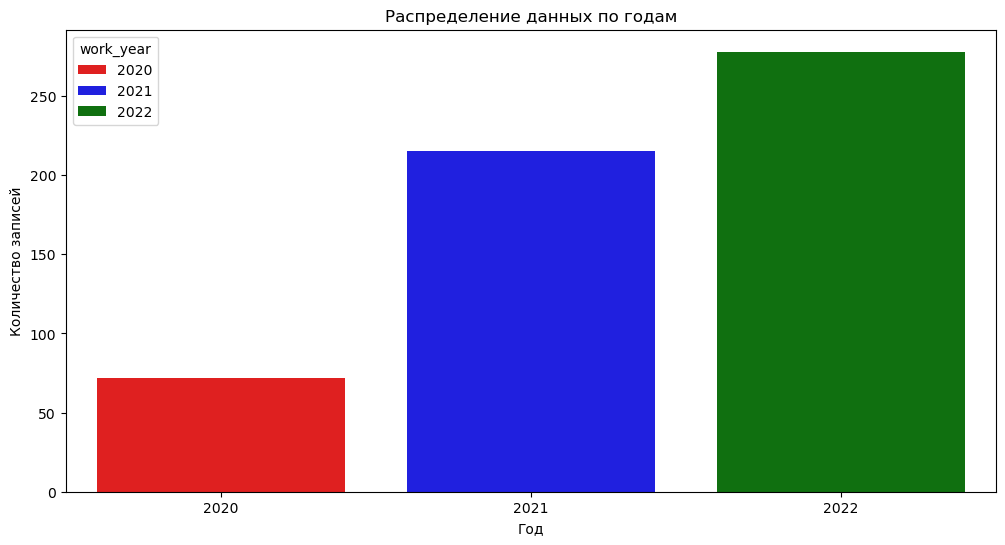

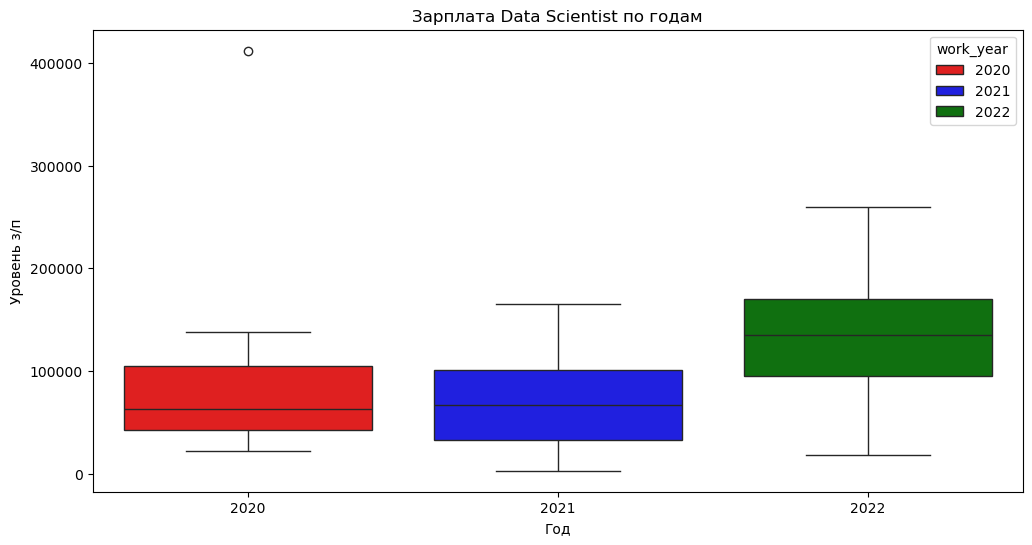

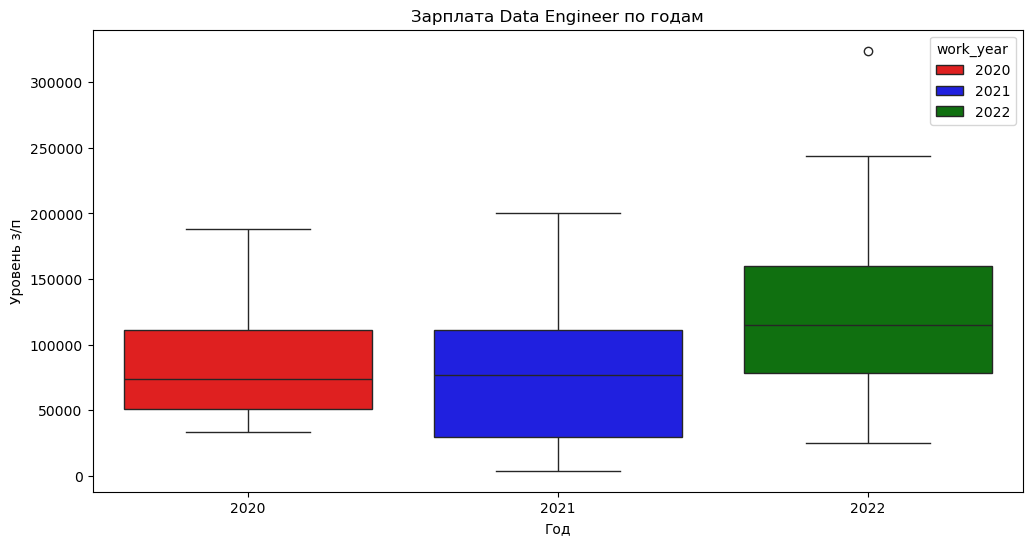

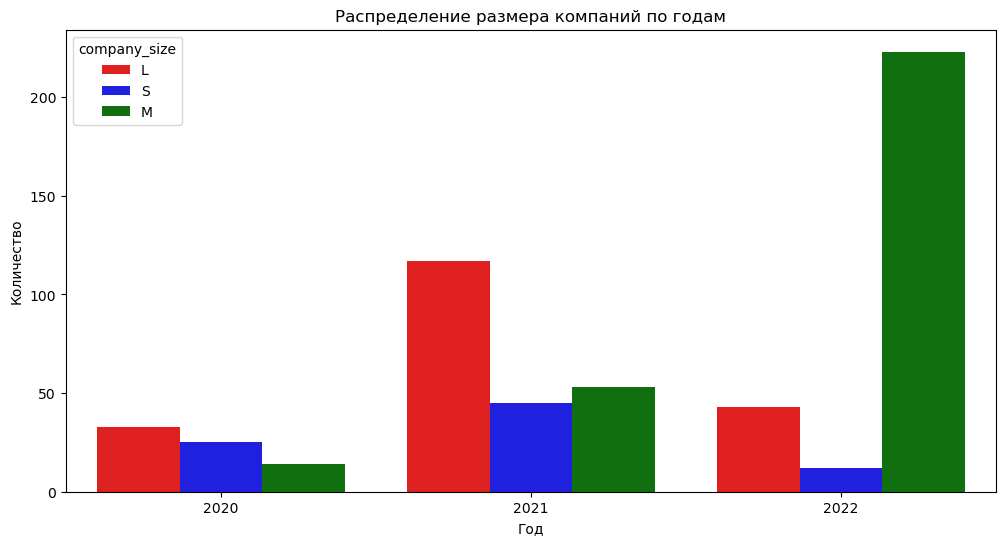

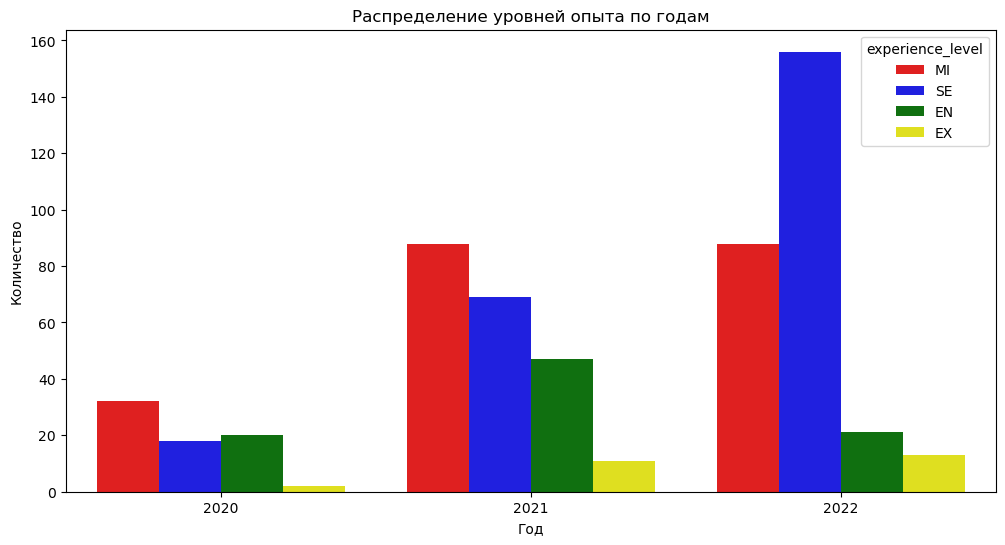

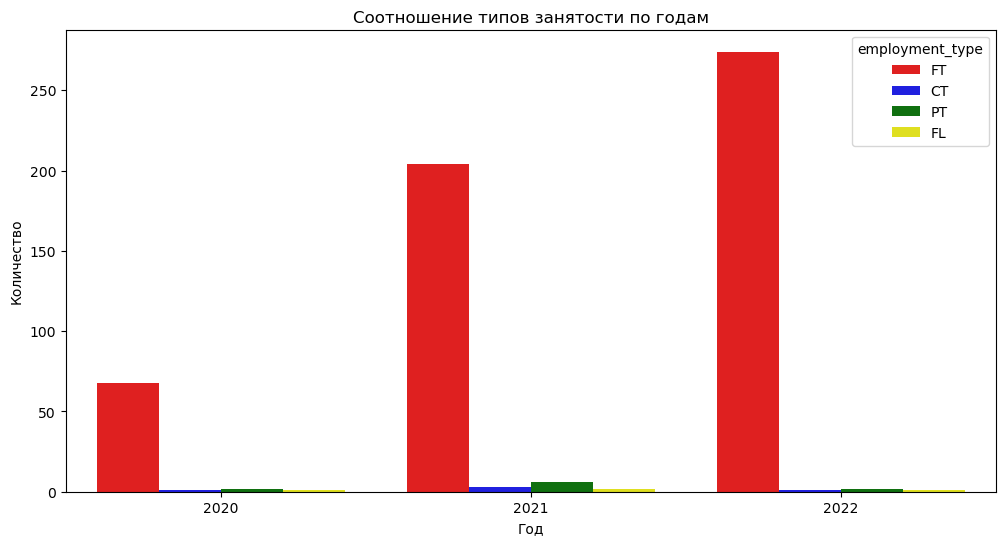

In [386]:
# Функция для настройки и отображения графиков
def plot_chart(plot_func, title, xlabel, ylabel, **kwargs):
    plt.figure(figsize=(12, 6))  # Размер графика
    plot_func(**kwargs)  # Построение графика с переданными параметрами
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Метка оси X
    plt.ylabel(ylabel)  # Метка оси Y
    plt.show()  # Отображение графика

# 1. График распределения данных по годам
plot_chart(
    sns.countplot,
    title='Распределение данных по годам',
    xlabel='Год',
    ylabel='Количество записей',
    x='work_year', data=df, hue='work_year', palette=['red', 'blue', 'green'], dodge=False
)

# 2. График зарплаты Data Scientist по годам
ds_data = df[df['job_title'] == 'Data Scientist']  # Фильтрация данных для Data Scientist
plot_chart(
    sns.boxplot,
    title='Зарплата Data Scientist по годам',
    xlabel='Год',
    ylabel='Уровень з/п',
    x='work_year', y='salary_in_usd', data=ds_data, hue='work_year', palette=['red', 'blue', 'green']
)

# 3. График зарплаты Data Engineer по годам
de_data = df[df['job_title'] == 'Data Engineer']  # Фильтрация данных для Data Engineer
plot_chart(
    sns.boxplot,
    title='Зарплата Data Engineer по годам',
    xlabel='Год',
    ylabel='Уровень з/п',
    x='work_year', y='salary_in_usd', data=de_data, hue='work_year', palette=['red', 'blue', 'green']
)

# 4. График распределения размера компаний по годам
plot_chart(
    sns.countplot,
    title='Распределение размера компаний по годам',
    xlabel='Год',
    ylabel='Количество',
    x='work_year', data=df, hue='company_size', palette=['red', 'blue', 'green']
)

# 5. График распределения уровней опыта по годам с добавлением желтого цвета
plot_chart(
    sns.countplot,
    title='Распределение уровней опыта по годам',
    xlabel='Год',
    ylabel='Количество',
    x='work_year', data=df, hue='experience_level', palette=['red', 'blue', 'green', 'yellow']
)

# 6. График соотношения типов занятости по годам с добавлением четвертого цвета
plot_chart(
    sns.countplot,
    title='Соотношение типов занятости по годам',
    xlabel='Год',
    ylabel='Количество',
    x='work_year', data=df, hue='employment_type', palette=['red', 'blue', 'green', 'yellow']
)


### **Выводы по графику распределения данных по годам**:

1. **Неравномерное распределение данных:**
   - График показывает явное увеличение количества записей по годам. В 2020 году было собрано наименьшее количество данных (около 60 записей), в 2021 году количество записей выросло до 200, а в 2022 году достигло максимума — более 250 записей.
   
2. **Тенденция к увеличению данных:**
   - Наблюдается значительный рост объема данных в 2021 и 2022 годах. Это может свидетельствовать о повышении интереса к данным в сфере Data Science или об увеличении числа вакансий и специалистов в этой области.

**Причины и гипотезы**:

1. **Пандемия COVID-19:** 
   - В 2020 году наблюдается наименьшее количество записей, что, вероятно, связано с пандемией и экономической неопределенностью, когда многие компании сокращали найм или замораживали вакансии. Это могло повлиять на количество собранных данных.
   
2. **Экономическое восстановление:**
   - В 2021 и 2022 годах наблюдается значительный рост объема данных, что может быть связано с восстановлением экономики после пандемии. В этот период компании начали активнее набирать специалистов, что привело к увеличению записей о зарплатах.
   
3. **Увеличение спроса на Data Science:** 
   - Спрос на специалистов в области Data Science и Data Engineering мог значительно возрасти в 2021–2022 годах, что также объясняет рост количества записей. Компании активно переходят на цифровые технологии и автоматизацию, что создает больше рабочих мест и вакансий в этой области.

**Рекомендации**:

1. **Анализ рынка труда:** 
   - Рекомендуется провести более глубокий анализ по регионам и должностям, чтобы выявить, какие сегменты рынка увеличили количество вакансий и где спрос на специалистов в области Data Science растет наиболее быстро.
   
2. **Использование данных по годам:**
   - Для корректного анализа и моделирования рекомендуется учитывать неравномерность распределения данных по годам, чтобы избежать смещения в результатах. Возможно, следует нормализовать данные или использовать временные метрики для учета роста числа вакансий.
   
3. **Адаптация к растущему спросу:**
   - Специалистам в области Data Science и Data Engineering следует учитывать этот рост спроса и продолжать развивать востребованные навыки, чтобы оставаться конкурентоспособными на рынке. Компании, в свою очередь, могут использовать данные для более точного прогнозирования потребностей в найме специалистов в будущем.

### **Выводы по графику зарплат Data Scientist по годам**:

1. **Рост медианной зарплаты:**
   - Медианная зарплата Data Scientist увеличивается с 2020 по 2022 год. В 2020 году медианная зарплата была ниже, затем она незначительно упала в 2021 году и затем значительно возросла в 2022 году.
   - В 2022 году медианная зарплата Data Scientist значительно выше, чем в предыдущие годы, что указывает на увеличение спроса или улучшение условий оплаты для данной профессии.

2. **Разброс зарплат:**
   - В 2020 году диапазон зарплат был относительно сжат, что указывает на более равномерное распределение зарплат. Также присутствует выброс — крайне высокая зарплата, которая значительно выше основного диапазона.
   - В 2021 году разброс зарплат увеличился, что может указывать на рост разнообразия в зарплатах (например, рост зарплат для более опытных специалистов).
   - В 2022 году разброс зарплат стал ещё больше, что может указывать на увеличение диапазона заработных плат, возможно, в зависимости от уровня опыта и специфики работы.

3. **Выбросы:**
   - В 2020 году присутствует значительный выброс, что указывает на наличие крайне высокой зарплаты (свыше 400000 USD), что может сильно искажать средние значения.
   - В 2021 и 2022 годах таких выбросов нет, что может свидетельствовать о стабилизации верхних значений зарплат.

**Причины и гипотезы**:

1. **Влияние пандемии на зарплаты:**
   - В 2020 году можно наблюдать более сжатый диапазон зарплат и выброс, что может быть связано с экономической неопределенностью, вызванной пандемией COVID-19. Компании могли замораживать зарплаты или увеличивать зарплаты лишь для высококвалифицированных специалистов.
   
2. **Экономическое восстановление и рост спроса на Data Science:**
   - В 2021 и особенно в 2022 годах рост зарплат может быть связан с восстановлением экономики после пандемии и увеличением спроса на специалистов Data Science. Это также может объяснить увеличение разброса зарплат, так как компании начинают активнее привлекать как новичков, так и опытных специалистов, предлагая более разнообразные уровни оплаты.

3. **Инфляция и глобализация рынка труда:**
   - В 2022 году рост зарплат может быть связан с инфляцией, которая влияет на все сектора экономики, а также с глобализацией рынка труда, когда специалисты могут работать удаленно на компании из разных стран с разными уровнями оплаты труда.

**Рекомендации**:

1. **Анализ факторов, влияющих на зарплаты:**
   - Рекомендуется провести дополнительный анализ по регионам, уровню опыта и типу компаний, чтобы более точно понять, какие факторы влияют на рост зарплат Data Scientist. Это поможет лучше понять, в каких сегментах наблюдается наибольший рост.

2. **Развитие квалификации:** 
   - Специалистам Data Scientist рекомендуется продолжать повышать квалификацию и развивать ключевые навыки, так как это может быть связано с более высоким диапазоном зарплат, особенно в 2022 году. Возможно, опытные специалисты с более редкими навыками получают значительно больше.

3. **Мониторинг тенденций на рынке:** 
   - Компании, нанимающие Data Scientists, должны следить за тенденциями на рынке труда, чтобы предлагать конкурентоспособные зарплаты и удерживать таланты, особенно в условиях роста спроса на специалистов в области данных в последние годы.

### **Выводы по графику зарплат Data Engineer по годам**:

1. **Медианная зарплата:**
   - Медианные зарплаты Data Engineer показывают рост с 2020 по 2022 годы. В 2020 году медианная зарплата была на уровне около 90000 USD, в 2021 году незначительно снизилась, а в 2022 году медиана возросла и достигла более 100000 USD.
   - Это указывает на положительную динамику в зарплатах для Data Engineer, особенно в 2022 году, что может свидетельствовать о росте спроса на специалистов в данной области.

2. **Разброс зарплат:**
   - В 2020 году диапазон зарплат был относительно сжатым, а в 2021 и 2022 годах диапазон значительно увеличился. Это указывает на увеличение дифференциации в зарплатах Data Engineer, возможно, в зависимости от опыта и специализации.
   - В 2022 году разброс зарплат стал еще более значительным, что может означать, что рынок стал предлагать более разнообразные зарплатные предложения для специалистов разного уровня.

3. **Выбросы:**
   - В 2022 году наблюдается выброс в районе 325000 USD, что указывает на присутствие крайне высоких зарплат среди Data Engineer, вероятно, для специалистов с уникальными навыками или на руководящих должностях. В 2020 и 2021 годах таких выбросов не наблюдалось.

**Причины и гипотезы**:

1. **Рост спроса на Data Engineers:**
   - В последние годы, особенно после пандемии, спрос на Data Engineer мог значительно возрасти. Это связано с увеличением цифровизации бизнеса и необходимостью построения сложных инфраструктур для работы с большими данными.
   - В 2022 году многие компании могли инвестировать в технологии и инфраструктуру, что способствовало росту зарплат Data Engineer.

2. **Неравенство в зарплатах:**
   - Увеличение разброса зарплат и наличие выбросов может быть связано с глобализацией рынка труда, когда высококвалифицированные специалисты могут получать значительные зарплаты, особенно если работают на международные компании или занимаются уникальными проектами.

3. **Снижение зарплат в 2021 году:**
   - В 2021 году медианные зарплаты немного снизились по сравнению с 2020 годом, что может быть связано с экономической неопределенностью в постпандемийный период. Компании могли уменьшать бюджет на зарплаты, пытаясь стабилизировать бизнес.

**Рекомендации**:

1. **Развитие специализированных навыков:** 
   - Data Engineers могут увеличить свои зарплаты, развивая специализированные навыки, такие как работа с облачными технологиями, построение высоконагруженных систем и работа с масштабируемыми инфраструктурами. Это особенно важно в условиях роста спроса на специалистов в 2022 году.

2. **Мониторинг глобальных трендов:**
   - Компании должны внимательно следить за глобальными трендами в зарплатах, так как высококвалифицированные специалисты могут искать более выгодные предложения на международном рынке. Рекомендуется предлагать конкурентоспособные зарплаты, чтобы привлекать и удерживать таланты.

3. **Дополнительный анализ факторов влияния:**
   - Стоит провести дополнительный анализ для выявления факторов, влияющих на значительное увеличение зарплат в 2022 году. Возможно, это связано с расширением удаленной работы, увеличением числа международных контрактов или другими факторами, которые стоит учитывать при формировании зарплатной политики.

### **Выводы по графику распределения размера компаний по годам**:

1. **Изменения в доминировании размера компаний по годам:**
   - В 2020 и 2021 годах крупные компании (L) доминировали в распределении данных. Это указывает на то, что в этот период большее количество записей приходилось на крупные компании.
   - В 2022 году ситуация резко изменилась, и большинство записей приходится на компании среднего размера (M). Число записей от крупных компаний значительно уменьшилось, как и от малых компаний (S).

2. **Уменьшение данных от крупных компаний в 2022 году:**
   - В 2020 и 2021 годах крупные компании предоставили большее количество записей. В 2022 году наблюдается значительное снижение числа записей от крупных компаний (L), хотя они все еще присутствуют в данных.

3. **Рост среднего бизнеса:**
   - В 2022 году наблюдается значительное увеличение количества записей от компаний среднего размера (M). Это может свидетельствовать о том, что средние компании начали более активно развивать Data Science направления или увеличивать свои штаты, что привело к большему числу специалистов, работающих в этих компаниях.

4. **Стабильное присутствие малых компаний:**
   - Малые компании (S) присутствуют в каждом году, но их доля остается относительно низкой по сравнению с крупными и средними компаниями, особенно в 2022 году.

**Причины и гипотезы**:

1. **Влияние пандемии COVID-19:**
   - В 2020 и 2021 годах крупные компании могли быть основными участниками рынка труда в Data Science, так как они имели больше ресурсов для сохранения рабочих мест в условиях пандемии.
   - Средние компании в этот период, возможно, сократили или приостановили найм, что объясняет их относительно небольшое присутствие в 2020 году.

2. **Экономическое восстановление и развитие среднего бизнеса:**
   - В 2022 году средние компании могли начать активное восстановление после пандемии, что привело к увеличению числа вакансий и записей от этих компаний.
   - Также это может быть связано с ростом числа новых стартапов или более гибких средних компаний, которые привлекают специалистов Data Science.

3. **Уменьшение доли крупных компаний:**
   - Снижение доли крупных компаний в 2022 году может быть связано с тем, что они завершили фазы масштабных наймов и сосредоточились на оптимизации ресурсов.

**Рекомендации**:

1. **Анализ по типу компании:** 
   - Рекомендуется провести более глубокий анализ по типу компании, чтобы понять, какие именно отрасли или сектора увеличивают количество вакансий в средних компаниях. Это поможет лучше понимать, где сосредоточен спрос на специалистов Data Science в 2022 году.

2. **Фокус на средние компании:**
   - Специалистам Data Science может быть полезно рассмотреть возможности в компаниях среднего размера, так как эти компании активно развиваются и предлагают новые вакансии. Это может предоставить больше возможностей для карьерного роста.

3. **Прогнозирование спроса:**
   - Компании, особенно крупные и средние, могут использовать эти данные для прогнозирования спроса на специалистов. Малые компании могут изучить опыт средних и крупных компаний для адаптации своих стратегий найма.

### **Выводы по графику распределения уровней опыта по годам**:

1. **Изменение в распределении уровней опыта:**
   - В 2020 и 2021 годах больше всего записей было для сотрудников среднего уровня (MI). Однако к 2022 году наблюдается резкий рост количества записей для сотрудников уровня SE (Senior), что указывает на увеличение доли старших специалистов в выборке.
   - Для уровней EN (Entry) и EX (Executive) наблюдается стабильное, но небольшое количество записей в каждом году, что может свидетельствовать о низком спросе на новичков и топ-менеджеров по сравнению с другими уровнями опыта.

2. **Рост числа старших специалистов (SE):**
   - В 2022 году наблюдается явный скачок в числе специалистов уровня SE, что может указывать на увеличение спроса на опытных сотрудников. Это может быть связано с тем, что компании начинают фокусироваться на привлечении более квалифицированных специалистов для решения сложных задач.

3. **Уменьшение доли новичков (EN) и топ-менеджеров (EX):**
   - В 2021 и 2022 годах наблюдается низкая доля сотрудников уровня EN (новички) и EX (топ-менеджеры). Это может означать, что компании либо сокращают найм молодых специалистов, либо сосредотачиваются на развитии сотрудников с более высоким уровнем опыта.

4. **Равномерное распределение сотрудников среднего уровня (MI):**
   - В течение всех трех лет сотрудники среднего уровня (MI) сохраняют относительно стабильное присутствие, что указывает на устойчивый спрос на специалистов с некоторым уровнем опыта.

**Причины и гипотезы**:

1. **Рост спроса на опытных специалистов:**
   - В 2022 году спрос на опытных сотрудников уровня SE (Senior) значительно вырос. Это может быть связано с развитием компаний и увеличением сложности проектов, что требует более квалифицированных кадров.
   - Возможно, компании в условиях постпандемийного восстановления экономики предпочитают нанимать опытных специалистов для ускорения выполнения сложных задач.

2. **Снижение найма новичков:**
   - Небольшое количество сотрудников уровня EN (Entry) в 2021 и 2022 годах может быть связано с тем, что компании сосредоточены на привлечении специалистов с более высоким уровнем опыта, либо из-за ограничений на найм в период экономической нестабильности.
   
3. **Устойчивый спрос на специалистов среднего уровня:**
   - Стабильное количество специалистов уровня MI (Middle) на протяжении всех трех лет указывает на то, что компании продолжают нанимать сотрудников с достаточным опытом для выполнения стандартных задач, что подтверждает их важность в бизнес-процессах.

**Рекомендации**:

1. **Фокус на повышение квалификации:**
   - Специалистам на уровне MI (Middle) рекомендуется уделять внимание повышению квалификации, чтобы переходить на уровень SE (Senior), так как спрос на более опытных специалистов явно увеличивается. Это также может привести к улучшению карьерных перспектив и повышению зарплат.

2. **Анализ тенденций по отрасли:**
   - Рекомендуется провести дополнительный анализ по конкретным отраслям, чтобы понять, в каких секторах наблюдается рост спроса на сотрудников уровня SE и уменьшение числа вакансий для новичков (EN). Это поможет специалистам лучше ориентироваться в текущих трендах на рынке труда.

3. **Поддержка молодых специалистов:**
   - Компаниям рекомендуется рассмотреть возможность расширения программ для новичков и стажеров, чтобы обеспечить долгосрочный рост кадров. Небольшое количество записей для уровня EN указывает на то, что молодые специалисты могут быть недооценены, и компаниям следует развивать их как будущих сотрудников с высоким потенциалом.

4. **Оптимизация управленческих ролей:**
   - С учетом стабильного количества топ-менеджеров (EX) в данных за все годы, компании могут оптимизировать свои управленческие структуры, повышая эффективность существующих руководителей и создавая возможности для их карьерного роста внутри организации.

### **Выводы по графику соотношения типов занятости по годам**:

1. **Преобладание полной занятости (FT):**
   - На протяжении всех трёх лет (2020, 2021, 2022) подавляющее большинство записей приходится на полную занятость (FT). Это свидетельствует о том, что большинство сотрудников Data Science и связанных профессий работают на полной ставке.
   - В 2022 году количество записей для полной занятости значительно увеличилось по сравнению с 2020 и 2021 годами, что может указывать на увеличение общего спроса на постоянные позиции.

2. **Незначительное количество других типов занятости:**
   - Число сотрудников с контрактной занятостью (CT), частичной занятостью (PT) и фрилансеров (FL) остаётся очень низким на протяжении всех трёх лет. Это может свидетельствовать о том, что такие формы занятости встречаются редко в сфере Data Science.
   - Небольшое количество записей для этих типов занятости может говорить о том, что компании предпочитают нанимать сотрудников на полную ставку для выполнения долгосрочных задач.

3. **Тенденции 2020 года:**
   - В 2020 году количество записей с полной занятостью (FT) было заметно ниже, что может быть связано с пандемией COVID-19 и экономической нестабильностью. В этот период некоторые компании могли временно ограничить найм сотрудников на полную ставку.

4. **Резкий рост полной занятости в 2022 году:**
   - В 2022 году наблюдается резкий рост числа сотрудников с полной занятостью. Это может быть связано с восстановлением экономики после пандемии и ростом спроса на постоянных сотрудников для долгосрочных проектов.

**Причины и гипотезы**:

1. **Пандемия COVID-19 и восстановление рынка труда:**
   - В 2020 году наблюдался относительно низкий уровень найма на полную ставку, что могло быть вызвано пандемией. В этот период компании, вероятно, старались минимизировать затраты, избегая найма на полную ставку, что привело к меньшему количеству записей.
   - В 2021 и 2022 годах рынок труда начал восстанавливаться, и компании вернулись к активному найму сотрудников на полную ставку.

2. **Предпочтение полной занятости в сфере Data Science:**
   - Высокая доля полной занятости (FT) может быть связана с тем, что компании предпочитают нанимать специалистов Data Science для долгосрочной работы. Задачи в этой сфере, такие как разработка моделей, анализ данных и инфраструктурные проекты, часто требуют постоянного и полного вовлечения сотрудников.

3. **Малая доля частичной и контрактной занятости:**
   - Низкий процент сотрудников с частичной занятостью (PT) или контрактной занятостью (CT) может свидетельствовать о том, что такие формы работы не очень популярны в данной сфере. Компании могут предпочитать более стабильные формы найма для долгосрочных проектов.

**Рекомендации**:

1. **Анализ вариантов гибкой занятости:**
   - Несмотря на доминирование полной занятости (FT), компании могут рассмотреть возможность увеличения числа частичных и контрактных позиций для привлечения гибких специалистов или фрилансеров. Это может быть полезно для краткосрочных или специализированных проектов.

2. **Адаптация к спросу на полную занятость:**
   - Специалистам, желающим работать в сфере Data Science, рекомендуется ориентироваться на вакансии с полной занятостью, так как они наиболее востребованы. Тем, кто ищет гибкие формы занятости, возможно, придется искать менее традиционные подходы, такие как фриланс через платформы.

3. **Мониторинг изменений на рынке труда:**
   - Компании и специалисты должны отслеживать дальнейшие изменения на рынке труда. Если гибкие формы занятости начнут набирать популярность, это может изменить характер найма и предложить больше возможностей для сотрудников с разными предпочтениями относительно занятости.

### **2.2 Анализ признака experience_level (уровень опыта)**

**Вычисляем и выводим основные статистические показатели зарплат для каждого уровня опыта (количество, среднее, стандартное отклонение, квартиль и другие параметры)**

In [387]:
# Получаем уникальные уровни опыта
experience_levels = df['experience_level'].unique()

# Функция для расчета статистики
def calculate_stats(data):
    return {
        'count': data.shape[0],
        'mean': data['salary_in_usd'].mean(),
        'std': data['salary_in_usd'].std(),
        'min': data['salary_in_usd'].min(),
        'max': data['salary_in_usd'].max(),
        'quantiles': data['salary_in_usd'].quantile([0.25, 0.5, 0.75]).to_list(),
        'normaltest_pvalue': stats.normaltest(data['salary_in_usd'].dropna()).pvalue,
        'mad': (data['salary_in_usd'] - data['salary_in_usd'].median()).abs().median(),
        'skewness': data['salary_in_usd'].skew(),
        'kurtosis': data['salary_in_usd'].kurtosis()
    }

# Создаем словарь для хранения статистики по каждому уровню опыта
salary_stats_by_experience = {level: calculate_stats(df[df['experience_level'] == level]) for level in experience_levels}

# Функция для вывода статистики
def print_stats(level, stats):
    print(f"Статистика для уровня опыта {level}:")
    print(f"Количество записей: {stats['count']}")
    print(f"Средняя заработная плата: {stats['mean']} USD")
    print(f"Стандартное отклонение: {stats['std']} USD")
    print(f"Минимальная заработная плата: {stats['min']} USD")
    print(f"Максимальная заработная плата: {stats['max']} USD")
    print(f"Квантили: {stats['quantiles']}")
    print(f"P-значение теста на нормальность: {stats['normaltest_pvalue']}")
    print(f"Медианное абсолютное отклонение (МАО): {stats['mad']} USD")
    print(f"Коэффициент асимметрии: {stats['skewness']}")
    print(f"Коэффициент эксцесса: {stats['kurtosis']}\n")

# Выводим статистику по каждому уровню опыта
for level, stats in salary_stats_by_experience.items():
    print_stats(level, stats)


Статистика для уровня опыта MI:
Количество записей: 208
Средняя заработная плата: 87792.99519230769 USD
Стандартное отклонение: 64118.97117436391 USD
Минимальная заработная плата: 2859 USD
Максимальная заработная плата: 450000 USD
Квантили: [47163.75, 76940.0, 112075.0]
P-значение теста на нормальность: 1.8987055029230342e-32
Медианное абсолютное отклонение (МАО): 31804.5 USD
Коэффициент асимметрии: 2.667552017538057
Коэффициент эксцесса: 11.937535452831572

Статистика для уровня опыта SE:
Количество записей: 243
Средняя заработная плата: 138374.88065843622 USD
Стандартное отклонение: 59955.96501109225 USD
Минимальная заработная плата: 18907 USD
Максимальная заработная плата: 412000 USD
Квантили: [99531.5, 135000.0, 171881.0]
P-значение теста на нормальность: 1.657914037635115e-12
Медианное абсолютное отклонение (МАО): 35640.0 USD
Коэффициент асимметрии: 1.0178658784468528
Коэффициент эксцесса: 3.139841323535963

Статистика для уровня опыта EN:
Количество записей: 88
Средняя заработная

### **Выводы**:

1. **Уровень опыта MI (Middle):**
   - **Средняя зарплата:** Средняя зарплата для уровня MI составляет около 87793 USD, что ниже по сравнению с SE (Senior) и EN (Entry).
   - **Широкий разброс зарплат:** Стандартное отклонение довольно высокое — 64118 USD, что указывает на значительное варьирование зарплат среди сотрудников уровня MI.
   - **Асимметрия и эксцесс:** Коэффициент асимметрии (2.67) и эксцесс (11.94) указывают на сильную положительную асимметрию и толстые хвосты распределения, что свидетельствует о наличии небольшого числа очень высоких зарплат.
   - **Ненормальное распределение:** P-значение теста на нормальность очень низкое (1.89e-32), что указывает на отклонение от нормального распределения.

2. **Уровень опыта SE (Senior):**
   - **Средняя зарплата:** Средняя зарплата для уровня SE составляет 138375 USD, что значительно выше, чем у сотрудников уровня MI, что логично с учетом опыта и навыков старших специалистов.
   - **Более однородное распределение:** Стандартное отклонение ниже (59956 USD), что говорит о меньшем разбросе зарплат по сравнению с уровнем MI.
   - **Асимметрия и эксцесс:** Асимметрия (1.02) и эксцесс (3.14) указывают на относительно умеренные отклонения от симметрии, что свидетельствует о более сбалансированном распределении зарплат для старших специалистов.
   - **Ненормальное распределение:** P-значение теста на нормальность также указывает на отклонение от нормальности, хотя ситуация менее экстремальна, чем для MI.

3. **Уровень опыта EN (Entry):**
   - **Медианное абсолютное отклонение (55906 USD)** и **асимметрия (1.86)** указывают на более выраженные вариации в зарплатах среди начинающих специалистов. Это может быть связано с тем, что опытные новички могут получать значительно больше по сравнению с менее опытными.
   - **Эксцесс (4.6)** указывает на наличие выбросов в распределении, что может объясняться редкими случаями высоких зарплат даже на начальных этапах карьеры.

**Причины и гипотезы**:

1. **Широкий разброс зарплат на уровне MI:**
   - Высокий уровень вариации среди специалистов уровня MI может быть связан с разнообразием должностей, регионов и отраслей, в которых работают сотрудники с уровнем опыта MI. Также, этот уровень включает как специалистов, находящихся ближе к началу карьеры, так и тех, кто приближается к уровню SE.

2. **Более стабильные зарплаты у специалистов уровня SE:**
   - Уровень SE демонстрирует более стабильное распределение зарплат, что может свидетельствовать о более чётких и устойчивых карьерных траекториях. Работодатели, вероятно, платят более однородные зарплаты для специалистов с опытом, так как рынок более четко определяет их стоимость.

3. **Неравномерность в зарплатах новичков (EN):**
   - Асимметрия и эксцесс на уровне EN могут быть связаны с тем, что отдельные новички попадают в высокооплачиваемые роли или работают в более высокооплачиваемых регионах. Тем не менее, большинство новичков получают относительно более низкие зарплаты, что объясняет сильную асимметрию.

**Рекомендации**:

1. **Фокус на повышении квалификации:**
   - Специалистам уровня MI рекомендуется активно развивать навыки и стремиться к продвижению на уровень SE, так как это может значительно повысить их зарплаты. Перспективы для роста на уровне SE кажутся более стабильными с меньшим разбросом зарплат.
   
2. **Анализ факторов влияния:**
   - Компании могут рассмотреть проведение внутреннего анализа, чтобы лучше понять факторы, влияющие на такие большие вариации зарплат на уровне MI. Это может помочь в разработке более справедливой и прозрачной системы оплаты труда.

3. **Развитие для новичков:**
   - Новичкам на уровне EN следует концентрироваться на приобретении опыта и развитии навыков, чтобы быстрее перейти на уровень MI и затем SE, где зарплаты значительно выше. Важно активно развивать ключевые компетенции, чтобы быстрее продвигаться по карьерной лестнице.

4. **Использование дополнительных метрик:**
   - Из-за значительных выбросов и ненормального распределения рекомендуется при анализе зарплат использовать медианные значения и медианное абсолютное отклонение (МАО), чтобы лучше учитывать влияние выбросов и сильной асимметрии.

**Строим графики с использованием заданной цветовой палитры: распределение зарплат, средняя зарплата и количество вакансий по уровням опыта**

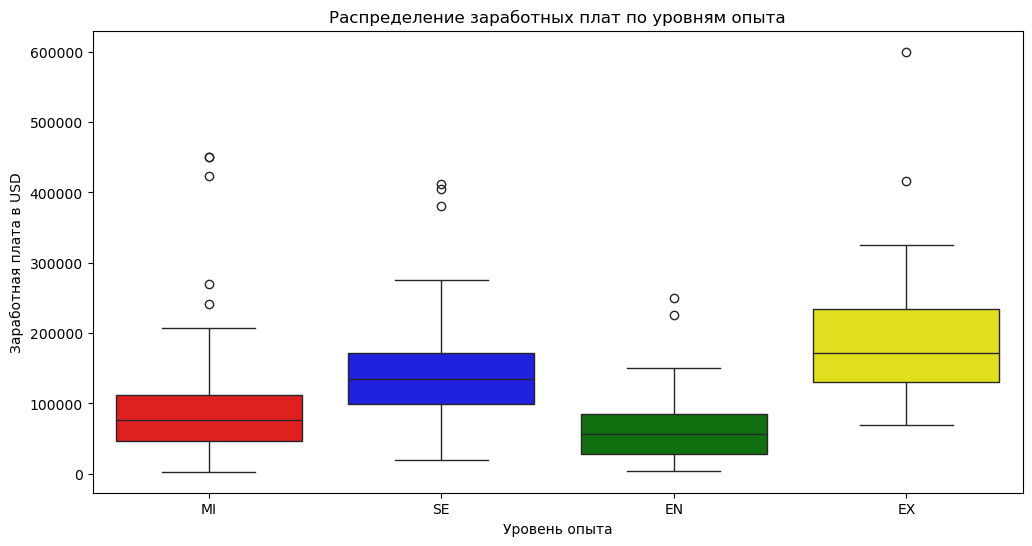

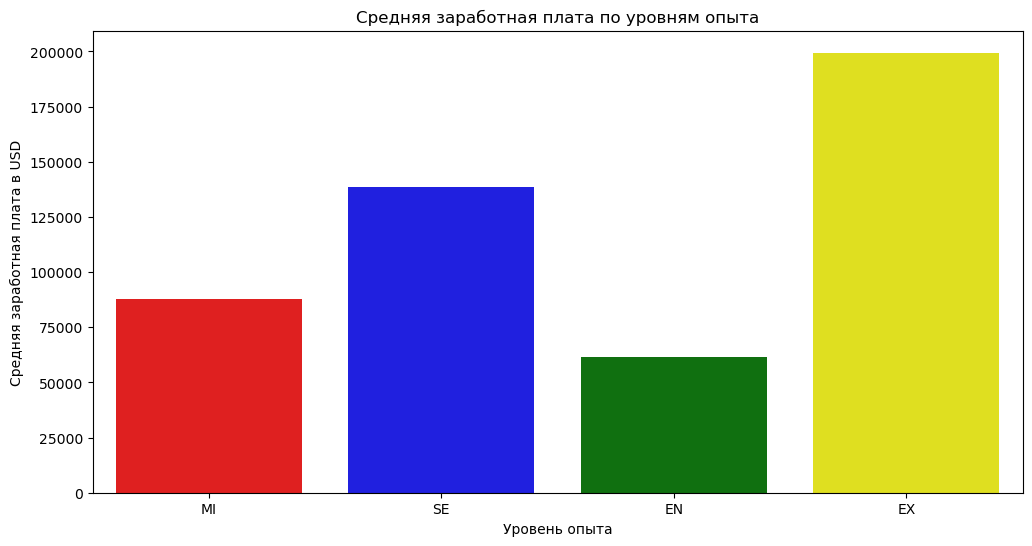

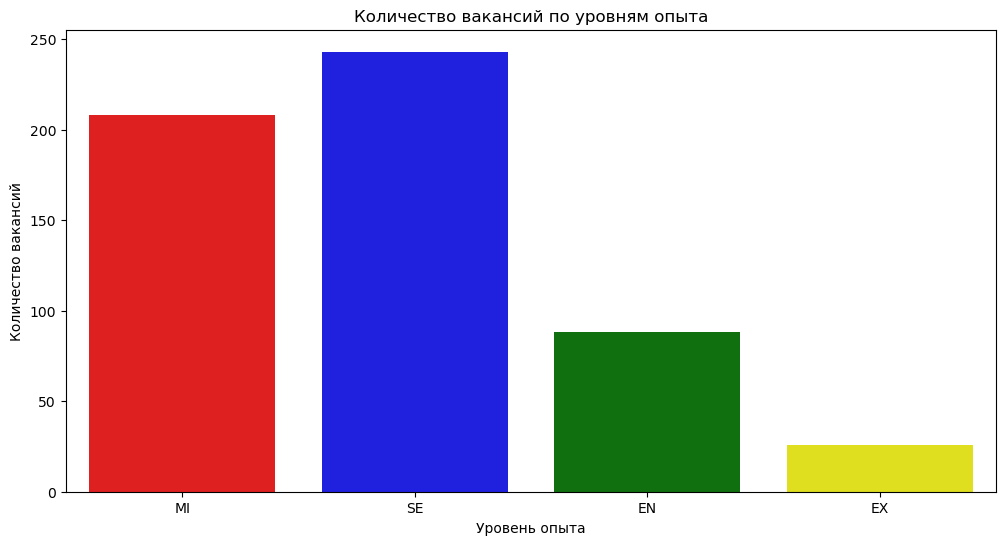

In [388]:
# Функция для построения графиков
def plot_chart(plot_func, title, xlabel, ylabel, palette, **kwargs):
    plt.figure(figsize=(12, 6))  # Размер графика
    plot_func(**kwargs, palette=palette)  # Построение графика с указанной палитрой
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.legend([], [], frameon=False)  # Скрытие легенды
    plt.show()  # Отображение графика

# 1. График распределения зарплат по уровню опыта
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат по уровням опыта',
    xlabel='Уровень опыта',
    ylabel='Заработная плата в USD',
    palette=['red', 'blue', 'green', 'yellow'],
    x='experience_level', y='salary_in_usd', data=df, hue='experience_level', dodge=False
)

# 2. График средней зарплаты по уровню опыта
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по уровням опыта',
    xlabel='Уровень опыта',
    ylabel='Средняя заработная плата в USD',
    palette=['red', 'blue', 'green', 'yellow'],
    x='experience_level', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, hue='experience_level', dodge=False
)

# 3. График количества вакансий по уровню опыта
plot_chart(
    sns.countplot,
    title='Количество вакансий по уровням опыта',
    xlabel='Уровень опыта',
    ylabel='Количество вакансий',
    palette=['red', 'blue', 'green', 'yellow'],
    x='experience_level', data=df, hue='experience_level', dodge=False
)


### **Выводы по графику распределения зарплат по уровням опыта**:

1. **Четкая градация зарплат по уровням опыта:**
   - На графике видно, что с увеличением уровня опыта зарплаты также растут. Специалисты уровня SE (Senior) и EX (Executive) получают значительно больше, чем специалисты уровней EN (Entry) и MI (Middle).
   - Медианные зарплаты для каждого уровня возрастают, что свидетельствует о логичной зависимости уровня зарплаты от опыта.

2. **Разброс зарплат:**
   - Разброс зарплат увеличивается с ростом уровня опыта. Уровни MI и EN имеют более узкий диапазон зарплат, в то время как у SE и EX наблюдаются более широкие "усы", что указывает на большие вариации зарплат в этих категориях.
   - На уровне EX есть значительный разброс зарплат, что может объясняться разнообразием позиций и ролей среди руководителей.

3. **Выбросы:**
   - Для уровней MI и SE наблюдаются выбросы, особенно в районе зарплат выше 300000 USD. Это может указывать на редкие случаи высоких зарплат, которые выбиваются из общего распределения.
   - На уровне EX также есть выбросы, что подтверждает существование отдельных очень высокооплачиваемых ролей на этом уровне.

4. **Уровень EN:**
   - Уровень EN (Entry) имеет наименьший разброс зарплат, что логично, так как новички обычно получают более стандартные зарплаты, не имея большого опыта для ведения переговоров о высоких ставках.

**Причины и гипотезы**:

1. **Рост зарплат с увеличением опыта:**
   - Естественный рост зарплат от уровня EN к EX может быть объяснен увеличением ценности специалиста для компании с увеличением его опыта и компетенций.
   - Специалисты уровня SE и EX часто занимают более ответственные роли, что объясняет широкий разброс зарплат.

2. **Выбросы для MI и SE:**
   - Наличие выбросов на уровнях MI и SE может свидетельствовать о том, что отдельные специалисты получают зарплаты выше средней, возможно, из-за редких и востребованных навыков или работы в высокооплачиваемых компаниях и регионах.

3. **Разброс на уровне EX:**
   - На уровне EX разброс зарплат может быть обусловлен разницей в управленческих позициях, от среднего менеджмента до топ-руководителей. Более высокие позиции могут предлагать значительно большие зарплаты.

**Рекомендации**:

1. **Карьерный рост для специалистов уровня MI:**
   - Специалистам уровня MI рекомендуется сосредоточиться на повышении квалификации и переходе на уровень SE, так как это существенно повысит их зарплаты. Движение в сторону более высокой ответственности и компетенций может привести к значительному улучшению финансового положения.

2. **Анализ факторов влияния на выбросы:**
   - Компании могут рассмотреть, какие факторы способствуют выбросам в зарплатах на уровнях MI и SE. Это может быть региональная специфика или наличие уникальных навыков, которые делают специалистов более высокооплачиваемыми.

3. **Управление ожиданиями для специалистов уровня EN:**
   - Новичкам рекомендуется учитывать, что на их уровне опыт и навыки играют ключевую роль для повышения зарплат. Стремление к быстрому накоплению опыта и развитию ключевых компетенций может привести к значительному улучшению заработной платы в будущем.

4. **Равномерность зарплат для EX:**
   - На уровне EX, несмотря на разброс зарплат, компании могут стремиться к большей прозрачности в оплате труда и более стандартизированным системам компенсации, чтобы уменьшить значительные вариации и обеспечить справедливость на этом уровне.

### **Выводы по графику средней заработной платы по уровням опыта**:

1. **Четкая зависимость зарплаты от уровня опыта:**
   - Видна явная градация зарплат по уровням опыта. Наименьшие средние зарплаты наблюдаются на уровне EN (Entry), а наибольшие — на уровне EX (Executive). Это подтверждает ожидаемую тенденцию, что зарплаты значительно увеличиваются с ростом опыта и ответственности.

2. **Наибольший скачок между уровнями SE и EX:**
   - Самый заметный рост зарплат происходит между уровнями SE (Senior) и EX (Executive). Средняя зарплата на уровне EX значительно превышает все остальные уровни, что может объясняться ответственностью, управленческими обязанностями и редкостью специалистов на уровне EX.
   
3. **Уровни MI и EN:**
   - Средняя зарплата на уровне MI (Middle) также значительно выше, чем у EN (Entry), что показывает ценность опыта даже на начальных этапах карьеры. Однако разрыв между уровнями MI и SE более значителен, что подчеркивает важность перехода от среднего уровня к старшему.

**Причины и гипотезы**:

1. **Рыночные условия и ответственность:**
   - Разница в зарплатах связана с увеличением ответственности и сложности работы на каждом уровне. Специалисты уровня EX управляют командами и проектами, что требует значительных навыков и опыта, а также объясняет высокие зарплаты на этом уровне.
   
2. **Редкость топ-специалистов (EX):**
   - Топ-менеджеры и специалисты уровня EX являются редкими, и компании готовы платить значительно выше средних зарплат, чтобы привлекать и удерживать таких специалистов. Это также может объяснять разницу между уровнями SE и EX.

3. **Более стандартные зарплаты на начальном уровне:**
   - Для уровня EN (Entry) наблюдается более низкая и, вероятно, более стандартная зарплата, поскольку на этом этапе специалисты еще не накопили значительного опыта и только начинают карьерный путь.

**Рекомендации**:

1. **Акцент на карьерный рост:**
   - Специалистам уровня MI и SE следует стремиться к карьерному росту, так как переход на следующий уровень (особенно к SE и EX) может значительно улучшить их финансовое положение. Необходимо развивать лидерские навыки и управленческий опыт для перехода на уровень EX.

2. **Поддержка развития для начинающих специалистов:**
   - Новичкам на уровне EN рекомендуется сосредоточиться на накоплении опыта и развитии ключевых компетенций. Это поможет им быстрее переходить на уровни MI и SE, где зарплаты заметно выше.

3. **Управление ожиданиями по зарплатам:**
   - Компаниям важно разрабатывать прозрачные зарплатные планы, особенно для уровней SE и EX, чтобы мотивировать сотрудников к карьерному росту и развитию. Обоснованные ожидания по уровню зарплат могут способствовать удержанию сотрудников на всех уровнях.

4. **Фокус на ключевые навыки:**
   - Специалистам следует обращать внимание на ключевые навыки, которые ценятся на каждом уровне опыта. Например, управленческие и лидерские навыки особенно важны для перехода к уровню EX, в то время как для SE требуются глубокие технические знания и опыт работы с комплексными проектами.

### **Выводы по графику количества вакансий по уровням опыта**:

1. **Наибольшее количество вакансий для уровней SE и MI:**
   - На графике видно, что уровни SE (Senior) и MI (Middle) имеют наибольшее количество вакансий. Это свидетельствует о высоком спросе на специалистов среднего и старшего уровня опыта, что соответствует рыночной тенденции, когда компании нуждаются в квалифицированных специалистах для выполнения сложных задач.
   - Количество вакансий для уровня SE немного выше, чем для уровня MI, что может указывать на более высокий спрос на опытных сотрудников.

2. **Меньшее количество вакансий для уровня EN:**
   - Количество вакансий для уровня EN (Entry) значительно ниже, чем для уровней SE и MI. Это может быть связано с тем, что компании предпочитают нанимать специалистов с определенным опытом, чтобы избежать затрат на обучение новичков.
   
3. **Редкие вакансии для уровня EX:**
   - Вакансий для уровня EX (Executive) крайне мало. Это объясняется тем, что топ-менеджеры и руководители высшего звена требуются реже, и эти позиции чаще заполняются за счет внутреннего роста или по рекомендациям, а не через открытый рынок труда.

**Причины и гипотезы**:

1. **Высокий спрос на квалифицированных специалистов:**
   - Большое количество вакансий для уровней MI и SE может быть связано с тем, что компании активно расширяют команды и нуждаются в квалифицированных специалистах для выполнения ключевых проектов и задач. Это может быть связано с ростом технологий, требующих участия опытных сотрудников.

2. **Меньший спрос на новичков:**
   - Меньшее количество вакансий для уровня EN может указывать на то, что компании предпочитают нанимать сотрудников с уже имеющимся опытом, так как обучение новичков требует дополнительных ресурсов. Однако это может также отражать общие тенденции на рынке труда, где опыт ценится выше, чем начальные навыки.

3. **Редкость вакансий для топ-менеджеров:**
   - Мало вакансий для уровня EX можно объяснить тем, что топовые позиции реже появляются на рынке, поскольку компании стараются удерживать руководителей или закрывают такие вакансии через рекомендации и внутренние переводы.

**Рекомендации**:

1. **Фокус на развитии для специалистов уровня MI:**
   - Специалистам уровня MI следует стремиться к повышению квалификации и накоплению опыта, чтобы быть востребованными на уровне SE, где зарплаты и перспективы лучше. Для них важно приобретать новые навыки и развивать лидерские качества, чтобы перейти на следующий уровень.

2. **Инвестиции в подготовку молодых специалистов:**
   - Компаниям рекомендуется рассмотреть возможность увеличения найма специалистов уровня EN, так как подготовка и развитие молодых кадров может создать долгосрочные выгоды. Разработка программ стажировок или наставничества может помочь компаниям привлечь перспективных новичков и развить их внутри компании.

3. **Поиск топ-менеджеров:**
   - Для кандидатов уровня EX рекомендуется использовать нетворкинг и внутренние каналы для поиска работы, так как такие позиции редко появляются на открытом рынке. Компании же могут активно поддерживать внутреннее продвижение сотрудников для заполнения топ-менеджерских вакансий.

4. **Поддержание баланса между опытом и потенциалом:**
   - Компании должны стремиться поддерживать баланс между наймом опытных сотрудников и развитием молодых специалистов, чтобы создать более гибкие команды, способные адаптироваться к различным вызовам.

### **2.3 Анализ признака job_title (должность работника)**

**Строим графики для отображения распределения зарплат, средней зарплаты и количества вакансий по должностям с использованием разных цветов и поворота меток по оси X на 90 градусов**

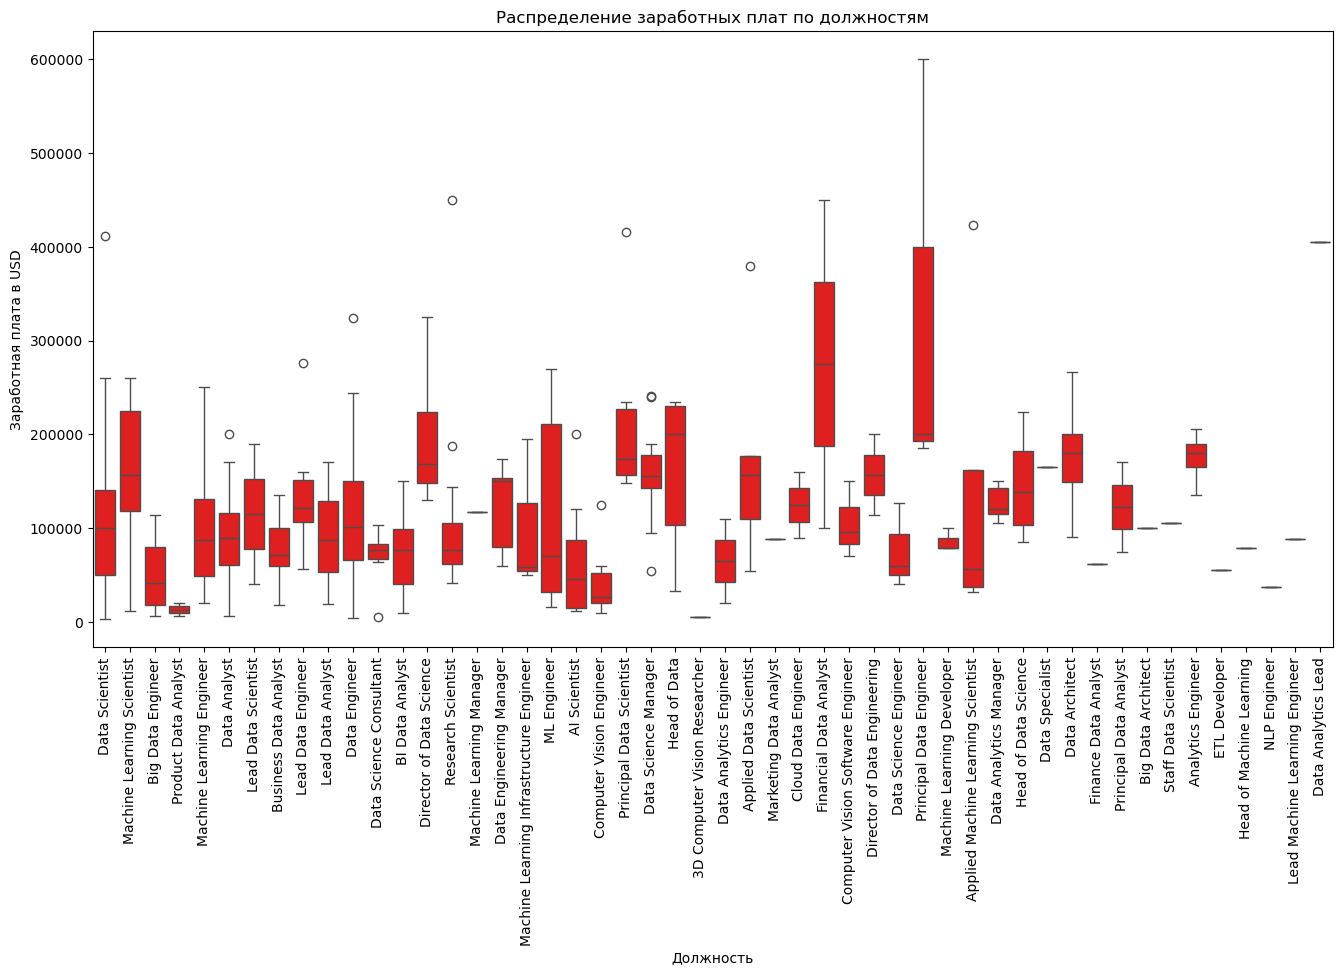

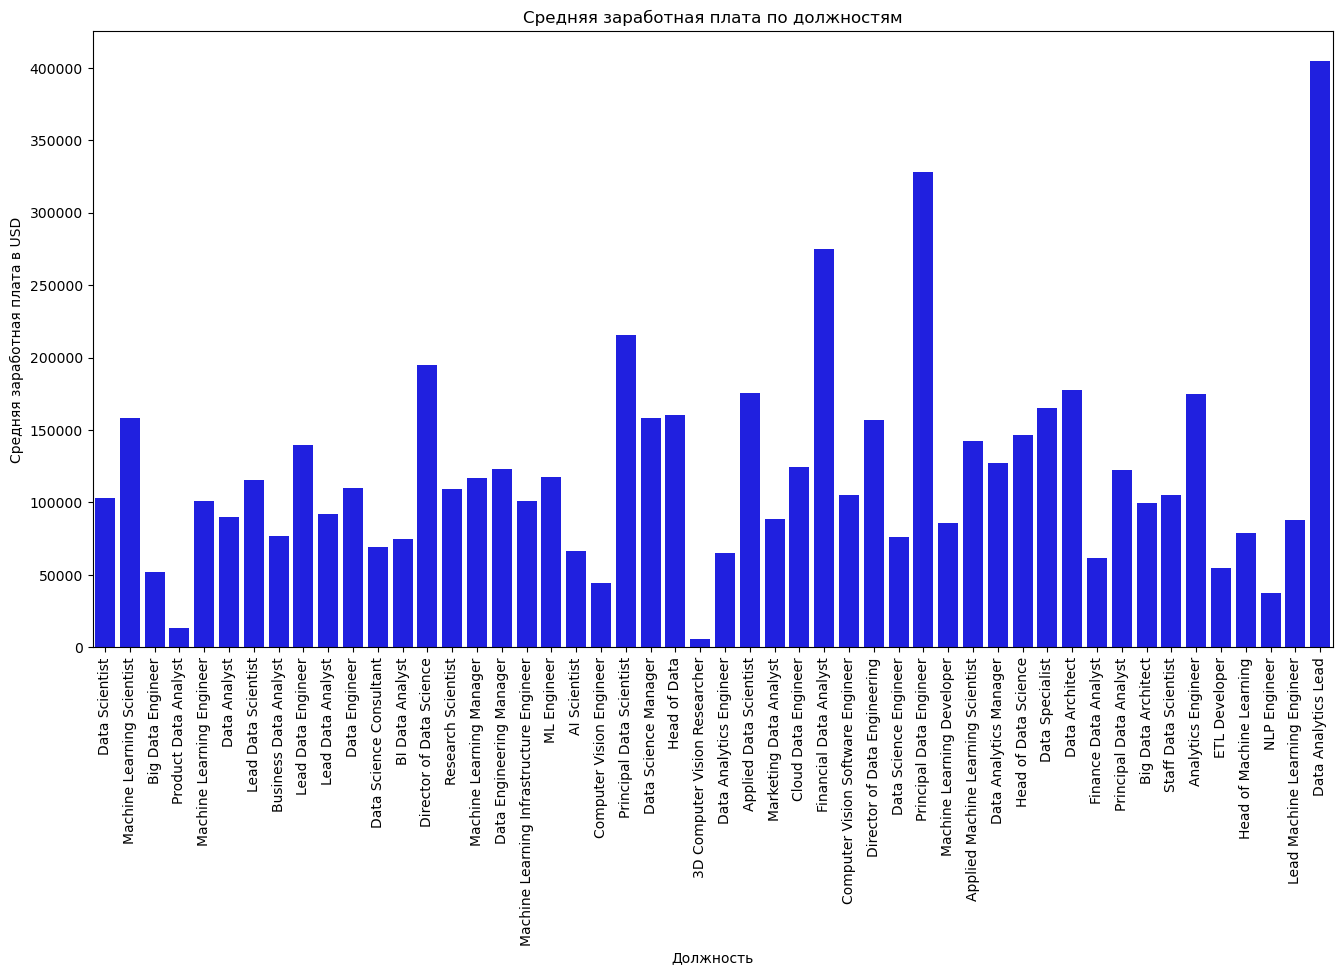

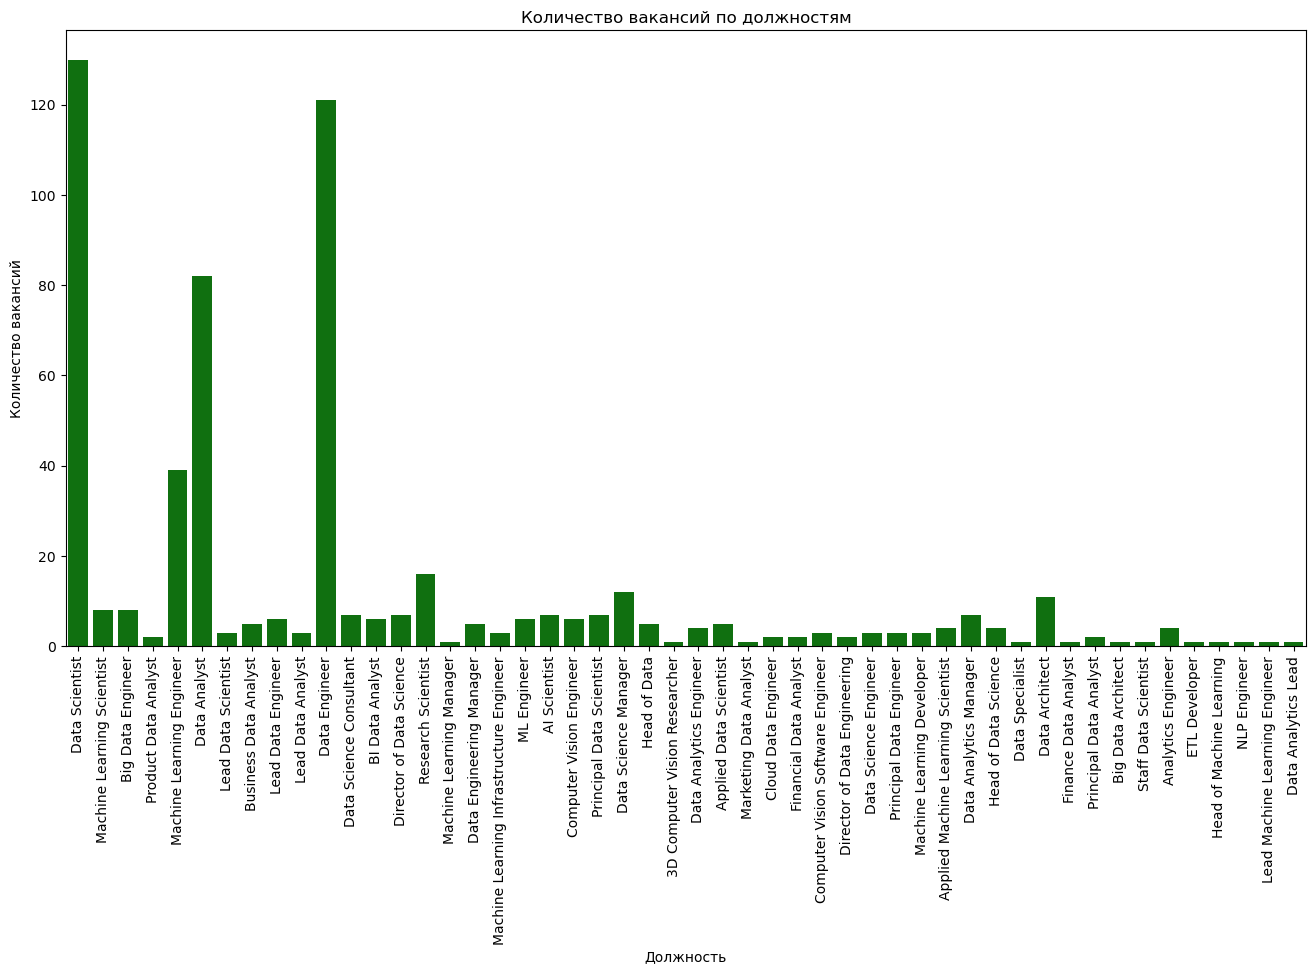

In [389]:
# Функция для построения графиков
def plot_chart(plot_func, title, xlabel, ylabel, color, rotation=0, **kwargs):
    plt.figure(figsize=(16, 8))  # Размер графика
    plot_func(**kwargs, color=color)  # Построение графика с указанным цветом
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.xticks(rotation=rotation)  # Поворот меток по оси X
    plt.show()  # Отображение графика

# 1. График распределения зарплат по должностям
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат по должностям',
    xlabel='Должность',
    ylabel='Заработная плата в USD',
    color='red',
    x='job_title', y='salary_in_usd', data=df, rotation=90
)

# 2. График средней зарплаты по должностям
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по должностям',
    xlabel='Должность',
    ylabel='Средняя заработная плата в USD',
    color='blue',
    x='job_title', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, rotation=90
)

# 3. График количества вакансий по должностям
plot_chart(
    sns.countplot,
    title='Количество вакансий по должностям',
    xlabel='Должность',
    ylabel='Количество вакансий',
    color='green',
    x='job_title', data=df, rotation=90
)


### **Выводы по графику распределения заработных плат по должностям**:

1. **Существенный разброс зарплат по должностям:**
   - График показывает значительный разброс зарплат между различными должностями. Должности, связанные с руководством или специфическими техническими навыками, как правило, имеют более высокие зарплаты. 
   - Самые высокие зарплаты наблюдаются для должностей уровня "Director of Data Engineering", "Applied Data Scientist" и "Principal Data Engineer". Это говорит о том, что руководящие и технически сложные роли оцениваются выше.

2. **Широкий диапазон зарплат для некоторых должностей:**
   - Для таких должностей, как "Data Scientist", "Machine Learning Engineer", "Lead Data Engineer", наблюдается широкий диапазон зарплат. Это может указывать на значительное разнообразие уровня опыта и навыков среди специалистов на этих позициях.
   - Роли с узкой специализацией, такие как "Computer Vision Engineer" и "AI Scientist", также демонстрируют большой разброс зарплат, что может быть связано с редкостью специалистов в этих областях.

3. **Низкий разброс зарплат для аналитических ролей:**
   - Должности вроде "Product Data Analyst" и "Finance Data Analyst" имеют более узкий диапазон зарплат, что может указывать на стандартизированность оплаты труда в этих профессиях.
   - Это может быть связано с тем, что такие роли имеют более четкие требования и уровни компетенций, что снижает вариативность зарплат.

4. **Выбросы в зарплатах:**
   - На графике для многих должностей есть выбросы, что указывает на отдельные случаи высоких зарплат. Например, должности "Principal Data Engineer" и "Machine Learning Engineer" имеют выбросы с зарплатами, превышающими 400000 USD.
   - Это может быть связано с наличием особо ценных специалистов, работающих в высокооплачиваемых компаниях или на уникальных проектах.

**Причины и гипотезы**:

1. **Высокие зарплаты для руководящих должностей:**
   - На руководящих позициях зарплаты обычно выше, что отражает уровень ответственности и управленческие задачи, связанные с такими ролями. Это объясняет высокие зарплаты для "Director" или "Lead"-должностей.
   
2. **Разброс в зарплатах технических специалистов:**
   - Широкий диапазон зарплат среди специалистов по машинному обучению и инженеров данных может быть связан с разнообразием навыков и опыта, а также с высокой ценностью специалистов, способных решать сложные задачи, связанные с анализом и обработкой больших данных.

3. **Специфические навыки и редкость специалистов:**
   - Роли, требующие узкоспециализированных знаний (например, в области компьютерного зрения или инфраструктуры машинного обучения), могут привлекать высокие зарплаты из-за редкости специалистов, обладающих такими компетенциями.

**Рекомендации**:

1. **Развитие уникальных и востребованных навыков:**
   - Специалистам рекомендуется развивать узкоспециализированные навыки, например, в областях машинного обучения, компьютерного зрения или инженерии данных, так как эти компетенции имеют высокий спрос и предлагают более высокие зарплаты.
   
2. **Фокус на руководящие роли:**
   - Для повышения зарплаты и карьерного роста стоит стремиться к руководящим позициям, таким как "Lead" или "Director". Это требует развития управленческих навыков и ответственности за проекты и команды.

3. **Мониторинг рыночных тенденций:**
   - Компании должны внимательно следить за рыночными трендами в зарплатах, особенно для технически сложных и руководящих ролей. Обеспечение конкурентоспособных зарплат позволит привлекать и удерживать лучших специалистов.

4. **Поддержка роста для аналитических ролей:**
   - Важно развивать карьерные пути для аналитиков данных, чтобы обеспечить их рост в компаниях. Хотя эти роли часто получают более стандартные зарплаты, развитие навыков в области анализа данных и управления проектами может улучшить их карьерные перспективы.

### **Выводы по графику средней заработной платы по должностям**:

1. **Высокие зарплаты на руководящих и технически сложных позициях:**
   - Наибольшие средние зарплаты наблюдаются у должностей уровня руководства и технически сложных ролей, таких как "Lead Machine Learning Engineer", "Principal Data Engineer", "Director of Data Engineering", "Applied Machine Learning Scientist". Это говорит о том, что высококвалифицированные специалисты и управленцы оцениваются гораздо выше на рынке труда.

2. **Средний уровень зарплат у аналитиков и инженеров данных:**
   - Должности, связанные с анализом данных (например, "Data Analyst", "Product Data Analyst") и инженерией данных (например, "Data Engineer", "Big Data Engineer"), имеют средние зарплаты, которые ниже, чем у руководителей, но значительно выше, чем у младших специалистов.

3. **Низкие зарплаты для младших и менее технических ролей:**
   - Такие роли, как "Finance Data Analyst", "Data Specialist", и "Business Data Analyst", имеют более низкие средние зарплаты, что может указывать на менее технический или менее специализированный характер работы на этих позициях.

4. **Широкий разброс между техническими ролями:**
   - Средние зарплаты для инженеров машинного обучения и специалистов по компьютерному зрению ("ML Engineer", "Computer Vision Engineer") также высоки, что подчеркивает ценность специалистов, работающих с передовыми технологиями и алгоритмами.

**Причины и гипотезы**:

1. **Высокие требования и редкость специалистов:**
   - Для таких должностей, как "Lead Machine Learning Engineer" или "Principal Data Engineer", требования к квалификации и навыкам значительно выше, а таких специалистов относительно мало на рынке труда. Это объясняет, почему такие позиции оплачиваются выше среднего.
   
2. **Руководящие роли требуют больших навыков управления:**
   - Руководящие должности, такие как "Director of Data Engineering" или "Head of Machine Learning", включают в себя управление большими командами и сложными проектами, что также оправдывает их высокую зарплату.

3. **Меньший спрос или стандартизация для аналитиков:**
   - Зарплаты аналитиков данных ниже по сравнению с техническими ролями, возможно, из-за более стандартизированных требований к квалификации и большего количества специалистов, готовых к выполнению таких задач.

**Рекомендации**:

1. **Развитие специализированных навыков:**
   - Специалистам рекомендуется развивать узкоспециализированные навыки, такие как машинное обучение, работа с большими данными или компьютерное зрение, поскольку такие роли предлагают значительно более высокие зарплаты.

2. **Стремление к руководящим позициям:**
   - Для повышения зарплаты и карьерного роста рекомендуется стремиться к руководящим ролям, что потребует развития управленческих навыков и способности вести команды и проекты.

3. **Молодым специалистам — акцент на развитие технических навыков:**
   - Тем, кто находится на начальном уровне или работает в менее оплачиваемых ролях, рекомендуется сосредоточиться на повышении технической квалификации, чтобы перейти на более высокооплачиваемые технические роли.

4. **Компании должны предлагать конкурентоспособные зарплаты:**
   - Работодателям рекомендуется следить за рынком зарплат, особенно для редких и высококвалифицированных специалистов, чтобы удерживать таланты и предлагать конкурентоспособные условия труда.

### **Выводы по графику количества вакансий по должностям**:

1. **Наибольшее количество вакансий для Data Scientist:**
   - На графике видно, что позиции "Data Scientist" занимают лидирующее место по количеству вакансий — их более 120. Это свидетельствует о высоком спросе на специалистов в области анализа данных и машинного обучения.
   - Вероятно, "Data Scientist" является базовой ролью в компаниях, внедряющих или развивающих аналитику данных.

2. **Высокий спрос на инженеров данных и специалистов по машинному обучению:**
   - Значительное количество вакансий также наблюдается для позиций "Data Engineer", "Machine Learning Engineer", "Lead Data Scientist". Это отражает актуальность технических ролей в сфере данных, особенно тех, которые связаны с обработкой больших данных и разработкой моделей машинного обучения.
   
3. **Низкий спрос на руководящие роли:**
   - Вакансии для должностей уровня "Director" и "Head" встречаются значительно реже. Это можно объяснить тем, что такие роли требуют гораздо большего опыта, и они открываются реже, чем вакансии для специалистов среднего уровня.

4. **Меньшее количество вакансий для специализированных ролей:**
   - Такие должности, как "Applied Data Scientist", "AI Scientist", "3D Computer Vision Engineer" и другие, имеют ограниченное количество вакансий. Это указывает на более узкий спрос на такие специализированные навыки.

**Причины и гипотезы**:

1. **Широкий спрос на специалистов Data Scientist:**
   - Рост спроса на специалистов по данным обусловлен тем, что все больше компаний внедряют аналитику и машинное обучение для принятия бизнес-решений. Data Scientist стал ключевой позицией для разработки моделей и анализа данных.
   
2. **Растущая роль инженеров данных:**
   - "Data Engineer" и "Machine Learning Engineer" занимают высокие позиции по количеству вакансий, что может быть связано с необходимостью создания и поддержки инфраструктуры для работы с большими данными и моделями. Эти роли часто связаны с подготовкой данных и обеспечением их доступности для аналитиков и машинного обучения.
   
3. **Ограниченный спрос на руководителей:**
   - Руководящие роли, такие как "Director" и "Head", открываются реже, так как компании предпочитают развивать специалистов внутри организации для заполнения таких вакансий. Кроме того, эти позиции требуют значительного опыта и уникальных навыков.

4. **Меньший спрос на узкоспециализированные позиции:**
   - Вакансии для таких ролей, как "AI Scientist" и "3D Computer Vision Engineer", встречаются реже, что может быть связано с редкостью проектов, требующих подобных навыков, или с тем, что такие позиции требуют специалистов с высокой квалификацией, которые сложнее найти.

**Рекомендации**:

1. **Развитие навыков Data Scientist:**
   - Специалистам, желающим получить работу в сфере данных, рекомендуется сосредоточиться на развитии навыков Data Scientist, так как спрос на эти позиции особенно высок. Это может включать изучение анализа данных, машинного обучения и программирования.

2. **Фокус на инженерные роли:**
   - Тем, кто интересуется техническими аспектами работы с данными, стоит обратить внимание на роли инженеров данных и инженеров машинного обучения, поскольку эти позиции также пользуются высоким спросом. Развитие навыков в области работы с большими данными и создания инфраструктуры станет отличным конкурентным преимуществом.

3. **Руководящие роли и внутренний рост:**
   - Компании могут сосредоточиться на развитии внутренних кадров для заполнения руководящих ролей, так как спрос на эти должности относительно низок. Это поможет повысить уровень удовлетворенности сотрудников и создать возможности для их карьерного роста.

4. **Анализ рынка для узкоспециализированных специалистов:**
   - Специалистам с узкими и специфическими навыками, такими как компьютерное зрение или ИИ, рекомендуется тщательно изучать рынок и выбирать проекты, которые могут предложить наиболее интересные и перспективные карьерные возможности.

### **2.4 Анализ признака employee_residence (место жительства сотрудника)**

**Строим графики, которые отображают распределение зарплат, среднюю зарплату и количество сотрудников по месту жительства, с заданными цветами и поворотом меток оси X на 90 градусов**

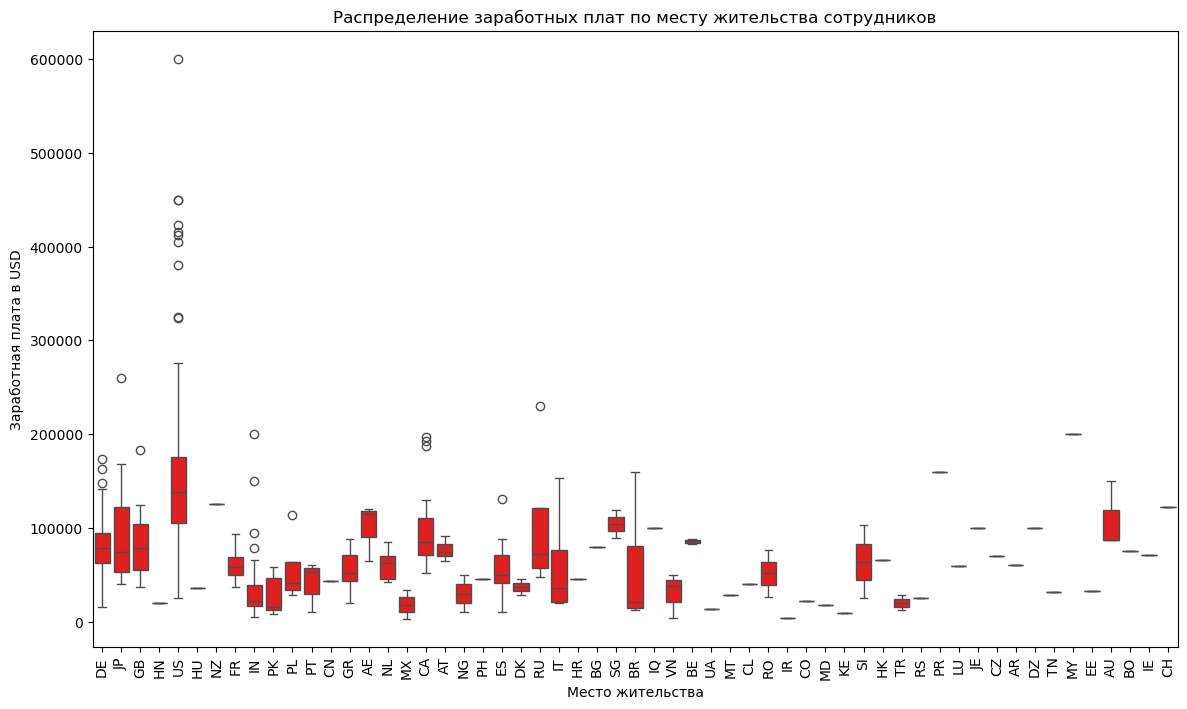

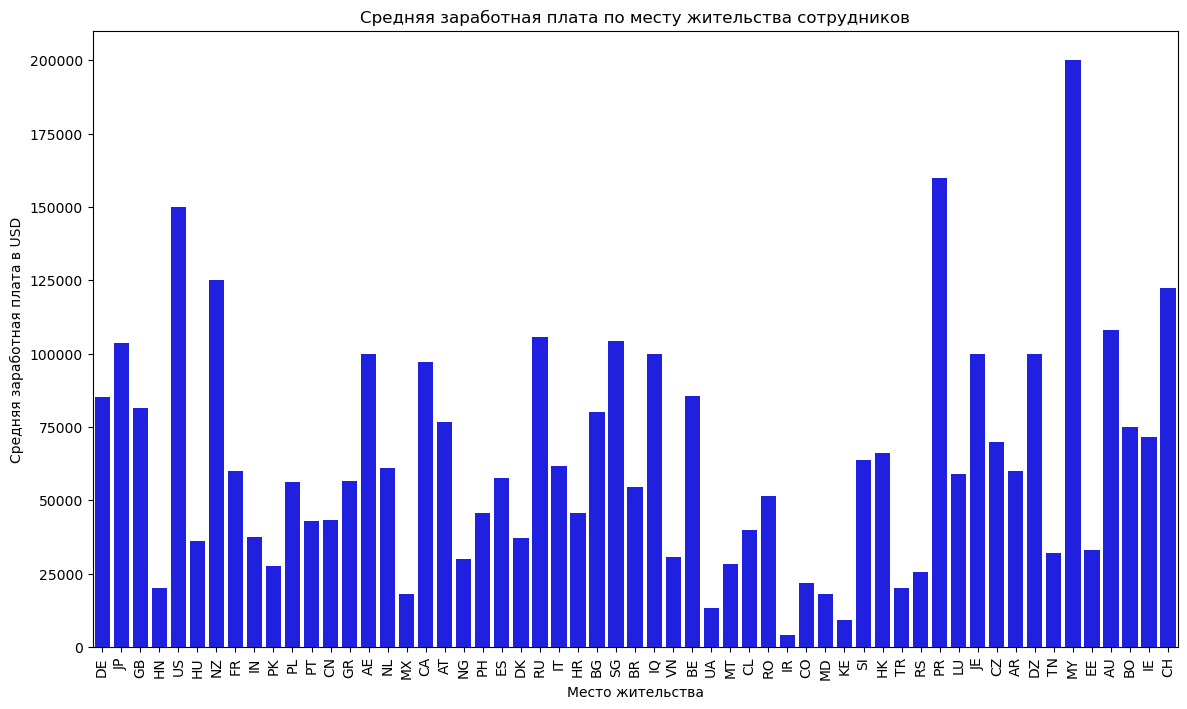

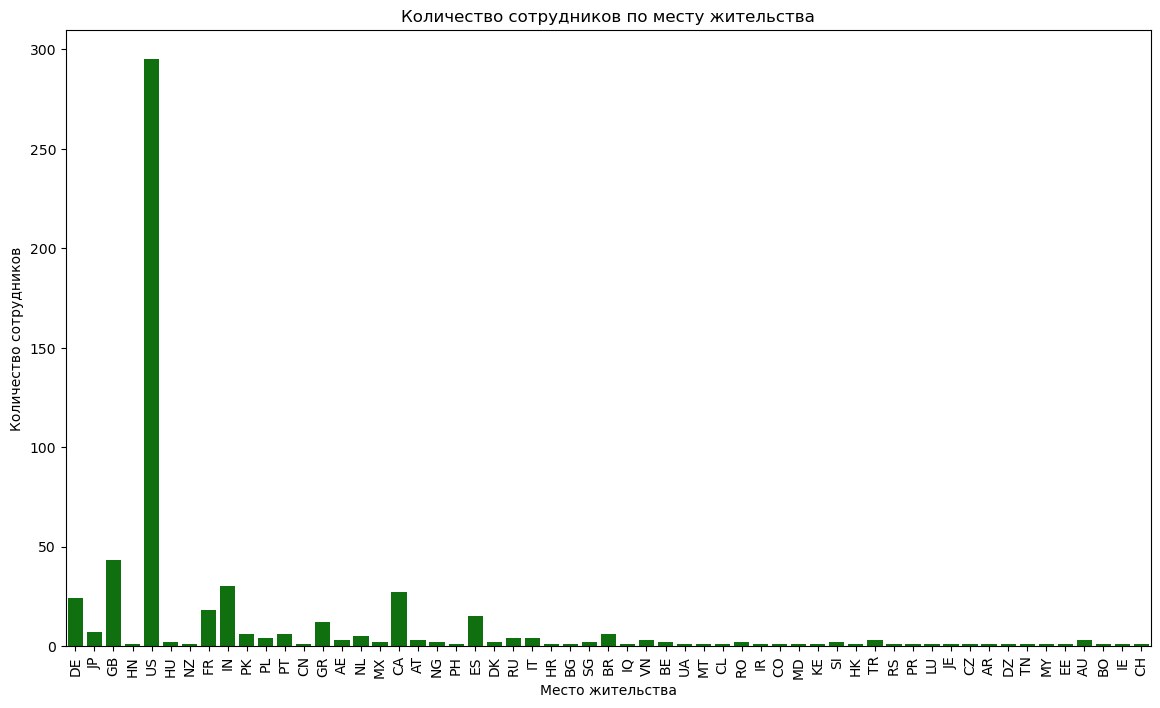

In [390]:
# Функция для построения графиков
def plot_chart(plot_func, title, xlabel, ylabel, color, rotation=0, **kwargs):
    plt.figure(figsize=(14, 8))  # Размер графика
    plot_func(**kwargs, color=color)  # Построение графика с указанным цветом
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.xticks(rotation=rotation)  # Поворот меток по оси X
    plt.show()  # Отображение графика

# 1. График распределения зарплат по месту жительства
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат по месту жительства сотрудников',
    xlabel='Место жительства',
    ylabel='Заработная плата в USD',
    color='red',
    x='employee_residence', y='salary_in_usd', data=df, rotation=90
)

# 2. График средней зарплаты по месту жительства сотрудников
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по месту жительства сотрудников',
    xlabel='Место жительства',
    ylabel='Средняя заработная плата в USD',
    color='blue',
    x='employee_residence', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, rotation=90
)

# 3. График количества сотрудников по месту жительства
plot_chart(
    sns.countplot,
    title='Количество сотрудников по месту жительства',
    xlabel='Место жительства',
    ylabel='Количество сотрудников',
    color='green',
    x='employee_residence', data=df, rotation=90
)


### **Выводы по графику распределения заработных плат по месту жительства сотрудников**:

1. **Высокие зарплаты в США и Великобритании:**
   - Самые высокие средние зарплаты наблюдаются в США (US) и Великобритании (GB). В США наблюдается значительный разброс зарплат с множеством выбросов, что свидетельствует о высоком уровне оплаты труда и возможных значительных бонусах или особых условиях для отдельных специалистов. Великобритания также показывает высокий уровень зарплат, хотя разброс зарплат несколько меньше.
   
2. **Заметные различия между странами:**
   - Зарплаты сотрудников значительно варьируются в зависимости от страны проживания. Например, в таких странах, как Германия (DE), Канада (CA), и Австралия (AU), зарплаты находятся на высоком уровне, в то время как в Индии (IN), Пакистане (PK) и России (RU) они значительно ниже.
   
3. **Выбросы в некоторых странах:**
   - В некоторых странах, таких как Германия (DE), Япония (JP), и Великобритания (GB), наблюдаются выбросы, что указывает на наличие высокооплачиваемых сотрудников, вероятно, работающих на уникальных проектах или в высокооплачиваемых компаниях.

4. **Низкие зарплаты в развивающихся странах:**
   - Зарплаты в странах, таких как Индия (IN), Пакистан (PK), и Нигерия (NG), находятся на низком уровне по сравнению с развитыми странами. Это может быть связано с экономическими факторами, локальными условиями рынка труда и стоимостью жизни в этих регионах.

**Причины и гипотезы**:

1. **Экономическая развитость страны:**
   - В странах с развитой экономикой (США, Великобритания, Германия) компании могут позволить себе платить более высокие зарплаты, так как они конкурируют за высококвалифицированных специалистов. Стоимость жизни и налоги также могут влиять на уровень зарплат.
   
2. **Региональные различия в стоимости жизни:**
   - В странах с низкой стоимостью жизни и менее развитой экономикой (например, Индия, Пакистан, Нигерия) уровень заработной платы ниже, что может отражать местные условия рынка труда и уровень спроса на специалистов.
   
3. **Наличие высокооплачиваемых компаний:**
   - Страны с большим количеством международных и технологических компаний (например, США и Великобритания) могут предлагать более высокие зарплаты, чтобы привлекать и удерживать талантливых специалистов. Выбросы в зарплатах могут быть результатом предложений от крупных корпораций или стартапов, ориентированных на передовые технологии.

4. **Различия в налогообложении и бонусах:**
   - В некоторых странах (например, в США) структура оплаты труда может включать значительные бонусы и компенсационные пакеты, что объясняет больший разброс зарплат.

**Рекомендации**:

1. **Анализ рынка труда перед переездом:**
   - Специалистам, рассматривающим возможность работы за границей, следует учитывать региональные различия в зарплатах. Работа в странах с высоким уровнем зарплат, таких как США или Великобритания, может значительно улучшить финансовое положение, особенно если учесть бонусные схемы и дополнительные компенсации.

2. **Развитие глобальных компетенций:**
   - Специалистам из стран с низким уровнем зарплат (например, Индия или Пакистан) рекомендуется развивать навыки и компетенции, востребованные на глобальном рынке, чтобы иметь возможность работать удаленно на компании из стран с более высоким уровнем оплаты труда.

3. **Оптимизация кадровой политики:**
   - Компании, работающие в странах с высокими зарплатами, могут привлекать удаленных сотрудников из регионов с более низкими затратами на оплату труда. Это позволит им снизить затраты и привлечь таланты из различных регионов мира.

4. **Оценка и компенсация стоимости жизни:**
   - При формировании зарплатных предложений работодателям рекомендуется учитывать региональную стоимость жизни, налоги и бонусные системы, чтобы предложить конкурентоспособные условия для привлечения лучших специалистов в своих регионах.

### **Выводы по графику средней заработной платы по месту жительства сотрудников**:

1. **Самые высокие средние зарплаты в Швейцарии, США и Великобритании:**
   - На графике видно, что Швейцария (CH), США (US) и Великобритания (GB) предлагают самые высокие средние зарплаты. Это подтверждает тот факт, что развитые экономики и высокая стоимость жизни в этих странах влияют на уровень заработной платы, особенно в технологических и научных сферах.

2. **Различия между развитыми и развивающимися странами:**
   - Страны с развивающейся экономикой, такие как Индия (IN), Пакистан (PK), Нигерия (NG), демонстрируют значительно более низкие средние зарплаты. Это может быть связано с экономическими условиями в этих странах, где заработные платы в технологической сфере ниже из-за стоимости жизни и локального спроса.

3. **Средние зарплаты в Европе:**
   - Европейские страны, такие как Германия (DE), Нидерланды (NL), и Испания (ES), показывают хорошие средние зарплаты, но ниже по сравнению с США и Великобританией. Это может быть связано с различиями в налогообложении и бонусах, а также с общей экономической политикой Европы, которая поддерживает высокий уровень жизни, но не всегда конкурентоспособна с точки зрения заработной платы на глобальном уровне.

4. **Низкие зарплаты в странах с низкой стоимостью жизни:**
   - В таких странах, как Индия, Пакистан и Филиппины (PH), средняя зарплата значительно ниже, что может отражать как местные условия рынка труда, так и низкую стоимость жизни.

**Причины и гипотезы**:

1. **Экономическая развитость и региональные различия:**
   - Высокие зарплаты в США, Швейцарии и Великобритании могут быть связаны с высоким уровнем экономической развитости этих стран, большим количеством международных компаний и высокими требованиями к квалификации специалистов.
   - Страны с более низким уровнем зарплат, как Индия и Пакистан, имеют другие экономические условия, в которых компании могут предлагать более низкие зарплаты, но это компенсируется меньшими затратами на жизнь.

2. **Налогообложение и бонусы:**
   - Различия в налоговых системах и структуре бонусов могут влиять на общий уровень зарплат. Например, США известны тем, что компании часто предлагают крупные бонусы, особенно в технологических компаниях, что может существенно увеличивать среднюю зарплату.

3. **Глобализация и удаленная работа:**
   - Влияние удаленной работы может быть значительным фактором в распределении зарплат. Многие компании из стран с высокими зарплатами нанимают удаленных сотрудников из стран с более низкой стоимостью жизни, предлагая при этом конкурентоспособные зарплаты по местным стандартам.

**Рекомендации**:

1. **Оценка зарплат перед переездом:**
   - Специалистам, рассматривающим возможность работы в другой стране, рекомендуется учитывать не только уровень зарплат, но и стоимость жизни в регионе, налоги и возможные бонусы. Это поможет лучше оценить реальную покупательную способность заработной платы в конкретной стране.

2. **Развитие глобальных навыков:**
   - Специалистам из стран с более низкими зарплатами стоит развивать навыки, востребованные на глобальном уровне, такие как программирование, аналитика данных и машинное обучение. Это может позволить им претендовать на удаленные позиции с более высокими зарплатами в международных компаниях.

3. **Компании могут использовать стратегию найма удаленных сотрудников:**
   - Работодателям стоит рассмотреть возможность найма сотрудников из регионов с более низкой стоимостью жизни, что позволит снизить расходы на оплату труда, не теряя при этом в качестве работы.

4. **Компании должны учитывать региональные различия в предложениях:**
   - При предложении работы сотрудникам из разных стран важно учитывать местные условия, включая налогообложение и уровень жизни, чтобы предложить конкурентоспособные условия труда, которые будут привлекательными для лучших специалистов.

### **Выводы по графику количества сотрудников по месту жительства**:

1. **Превосходство США по количеству сотрудников:**
   - На графике заметно, что подавляющее большинство сотрудников проживают в США (US). Это может быть связано с тем, что в США находятся главные офисы многих крупных технологических компаний, а также с тем, что в стране развит рынок труда в области данных и технологий.

2. **Другие страны с относительно большим количеством сотрудников:**
   - После США, Великобритания (GB), Германия (DE), Индия (IN) и Канада (CA) показывают относительно большое количество сотрудников. Это указывает на то, что эти страны также являются важными центрами в сфере технологий и данных.
   
3. **Небольшое количество сотрудников из других стран:**
   - Во многих странах количество сотрудников невелико, что может отражать либо низкий спрос на удаленную работу, либо низкую представленность таких специалистов в базе данных.

**Причины и гипотезы**:

1. **Концентрация технологических компаний в США:**
   - В США находятся крупные технологические хабы, такие как Силиконовая долина, что объясняет большое количество сотрудников из этой страны. Множество ведущих компаний в области данных и технологий базируются в США и нанимают сотрудников как локально, так и по всему миру.
   
2. **Быстро развивающийся рынок труда в Великобритании и Германии:**
   - Великобритания и Германия также являются важными центрами для технологических компаний в Европе. Эти страны предлагают развитую инфраструктуру, высокие зарплаты и значительные возможности для специалистов в сфере данных.
   
3. **Рост технологического рынка в Индии:**
   - Индия представляет собой быстро развивающийся рынок IT-услуг, с множеством квалифицированных специалистов в сфере данных, что объясняет большое количество сотрудников, проживающих в этой стране. 

4. **Удаленная работа:**
   - Увеличение удаленной работы могло позволить компаниям привлекать таланты из разных стран, однако, судя по графику, большая часть сотрудников все еще проживает в США. Это может означать, что удаленная работа не является основной формой занятости в этой базе данных или что компании все еще предпочитают сотрудников из стран с развитой инфраструктурой.

**Рекомендации**:

1. **Использование удаленного найма:**
   - Компаниям рекомендуется расширять свои программы удаленного найма, особенно на развивающихся рынках, таких как Индия и другие страны Азии, где имеется множество талантливых специалистов по данным. Это позволит сократить затраты и привлечь квалифицированных специалистов из регионов с более низкими затратами на жизнь.

2. **Поиск сотрудников в странах с низкой представленностью:**
   - Компании могут обратить внимание на страны с низким количеством сотрудников, где рынок труда может быть менее конкурентным, и предложить конкурентоспособные условия для привлечения талантов.

3. **Поддержка профессионального роста в развивающихся странах:**
   - Специалистам в странах с низкой представленностью в этой базе данных, таких как Россия, Филиппины или Бразилия, рекомендуется развивать глобально востребованные навыки, чтобы быть конкурентоспособными на международном рынке труда.

4. **Оптимизация налоговых и юридических факторов:**
   - Компании могут рассмотреть юридические и налоговые аспекты найма сотрудников в разных странах, чтобы предложить привлекательные условия для сотрудников, сохраняя при этом эффективность затрат для бизнеса.

### **2.5 Анализ признака remote_ratio (удаленная работа)**

**Рассчитываем и выводим подробную статистику по заработным платам в зависимости от уровня удаленной работы сотрудников (процент удаленной работы)**

In [391]:
from scipy import stats

# Получение уникальных значений для удаленной работы
remote_ratios = df['remote_ratio'].unique()

# Функция для расчета статистики
def calculate_stats(data):
    return {
        'count': data.shape[0],
        'mean': data['salary_in_usd'].mean(),
        'std': data['salary_in_usd'].std(),
        'min': data['salary_in_usd'].min(),
        'max': data['salary_in_usd'].max(),
        'quantiles': data['salary_in_usd'].quantile([0.25, 0.5, 0.75]).to_list(),
        'normaltest_pvalue': stats.normaltest(data['salary_in_usd'].dropna()).pvalue,
        'mad': (data['salary_in_usd'] - data['salary_in_usd'].median()).abs().median(),
        'skewness': data['salary_in_usd'].skew(),
        'kurtosis': data['salary_in_usd'].kurtosis()
    }

# Создание словаря для хранения статистики по удаленной работе
salary_stats_by_remote = {ratio: calculate_stats(df[df['remote_ratio'] == ratio]) for ratio in remote_ratios}

# Функция для вывода статистики
def print_stats(ratio, stats):
    print(f"Статистика для удаленной работы {ratio}%:")
    print(f"Количество записей: {stats['count']}")
    print(f"Средняя заработная плата: {stats['mean']} USD")
    print(f"Стандартное отклонение: {stats['std']} USD")
    print(f"Минимальная заработная плата: {stats['min']} USD")
    print(f"Максимальная заработная плата: {stats['max']} USD")
    print(f"Квантили: {stats['quantiles']}")
    print(f"P-значение теста на нормальность: {stats['normaltest_pvalue']}")
    print(f"Медианное абсолютное отклонение (МАО): {stats['mad']} USD")
    print(f"Коэффициент асимметрии: {stats['skewness']}")
    print(f"Коэффициент эксцесса: {stats['kurtosis']}\n")

# Вывод статистики по каждому уровню удаленной работы
for ratio, stats in salary_stats_by_remote.items():
    print_stats(ratio, stats)


Статистика для удаленной работы 0%:
Количество записей: 121
Средняя заработная плата: 105785.40495867768 USD
Стандартное отклонение: 68392.50033953268 USD
Минимальная заработная плата: 2859 USD
Максимальная заработная плата: 450000 USD
Квантили: [62000.0, 98158.0, 136000.0]
P-значение теста на нормальность: 2.2651036894646952e-10
Медианное абсолютное отклонение (МАО): 37842.0 USD
Коэффициент асимметрии: 1.383575110414945
Коэффициент эксцесса: 4.394519005573814

Статистика для удаленной работы 50%:
Количество записей: 98
Средняя заработная плата: 80721.89795918367 USD
Стандартное отклонение: 57639.09669489899 USD
Минимальная заработная плата: 5409 USD
Максимальная заработная плата: 423000 USD
Квантили: [50000.5, 68010.5, 99925.75]
P-значение теста на нормальность: 1.6297106711352018e-18
Медианное абсолютное отклонение (МАО): 26282.0 USD
Коэффициент асимметрии: 2.6972009914964103
Коэффициент эксцесса: 12.570110550505943

Статистика для удаленной работы 100%:
Количество записей: 346
Средн

### **Выводы**:

1. **Уровень зарплат для сотрудников с различной долей удаленной работы:**
   - Сотрудники с **0% удаленной работы** имеют наибольшую среднюю заработную плату — 105785 USD, что может быть связано с тем, что компании готовы платить больше за сотрудников, находящихся в офисе.
   - Для сотрудников с **50% удаленной работы** средняя зарплата составляет 80721 USD, что является самым низким значением среди представленных категорий. Это может быть связано с тем, что такие сотрудники выполняют менее квалифицированные задачи или работают в компаниях с гибкой политикой занятости, которая не требует присутствия на высокооплачиваемых проектах.
   - Сотрудники с **100% удаленной работой** также получают относительно высокую среднюю зарплату, но ниже, чем сотрудники с 0% удаленной работы. Это указывает на то, что компании готовы платить больше за удаленную работу, но, возможно, не всегда на уровне офисных позиций.

2. **Более высокий уровень разброса зарплат среди сотрудников с 0% удаленной работы:**
   - Для сотрудников с 0% удаленной работы стандартное отклонение составляет 68392 USD, что является самым высоким значением среди групп. Это указывает на более широкий диапазон зарплат в этой категории, возможно, связанный с различными должностями и уровнем квалификации, представленными среди офисных сотрудников.

3. **Наиболее высокий уровень асимметрии и эксцесса для сотрудников с 50% удаленной работы:**
   - Зарплаты для сотрудников с 50% удаленной работы демонстрируют высокую асимметрию (2.697) и эксцесс (12.570), что говорит о наличии значительного числа высокооплачиваемых сотрудников и выбросов в данной категории. Это может свидетельствовать о том, что в данной категории есть сотрудники, получающие гораздо больше средней заработной платы, возможно, благодаря редким навыкам или уникальным условиям работы.

4. **Необычно высокие значения эксцесса для всех категорий:**
   - Во всех категориях наблюдается высокий коэффициент эксцесса, что говорит о наличии выбросов в распределении зарплат. Это указывает на то, что отдельные сотрудники получают значительно больше остальных, что может быть связано с бонусами или уникальными условиями труда.

**Причины и гипотезы**:

1. **Спрос на офисных сотрудников с высокой квалификацией:**
   - Сотрудники с 0% удаленной работы, скорее всего, работают на позициях, требующих постоянного присутствия, таких как руководители или специалисты, участвующие в управлении проектами и командами. Компании готовы платить больше за такие позиции, поскольку они требуют более высокой ответственности.

2. **Гибкость и снижение заработной платы для частично удаленной работы:**
   - Низкий уровень зарплат для сотрудников с 50% удаленной работы может быть связан с тем, что такие сотрудники работают на гибких позициях с частичной занятостью или выполняют менее квалифицированные задачи. Возможно, компании предоставляют возможность частичной удаленной работы в обмен на более низкую оплату.

3. **Конкуренция за квалифицированных удаленных сотрудников:**
   - Сотрудники с 100% удаленной работой, вероятно, обладают высоко востребованными навыками, которые позволяют им работать на удаленной основе. Компании, стремящиеся нанять таких сотрудников, могут быть готовы платить конкурентоспособные зарплаты, хотя их уровень все же ниже, чем у офисных сотрудников.

**Рекомендации**:

1. **Анализ возможностей для повышения зарплат для удаленных сотрудников:**
   - Компании должны рассмотреть возможность повышения зарплат для сотрудников с полной или частичной удаленной работой, чтобы привлечь и удержать таланты, особенно если они работают в области технологий и данных, где удаленная работа стала нормой.

2. **Развитие гибких условий работы:**
   - Сотрудникам рекомендуется развивать навыки, позволяющие работать удаленно, так как это открывает больше возможностей на международном рынке труда. При этом стоит учитывать, что работа в офисе может предлагать более высокие зарплаты.

3. **Оптимизация кадровой политики:**
   - Работодатели должны рассмотреть возможность внедрения гибкой политики занятости, чтобы сбалансировать спрос на сотрудников с 0% удаленной работы и тех, кто работает полностью удаленно. Введение гибридных моделей работы с конкурентными зарплатами может увеличить удовлетворенность сотрудников.

4. **Анализ рынка труда для работников с частичной удаленной занятостью:**
   - Для сотрудников с 50% удаленной работой стоит оценить рынок и понять, какие навыки позволят повысить заработную плату. Возможно, стоит сосредоточиться на развитии специализированных навыков, чтобы претендовать на более высокие позиции даже при частичной удаленной работе.

**Создаем визуализации, показывая распределение зарплат, среднюю зарплату и количество сотрудников в зависимости от уровня удаленной работы (процент удаленной работы)**

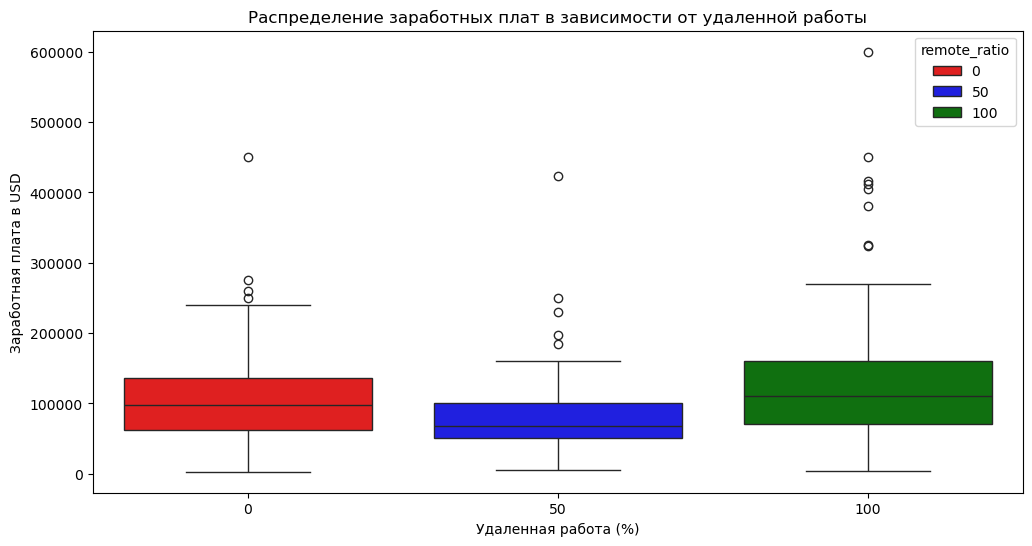

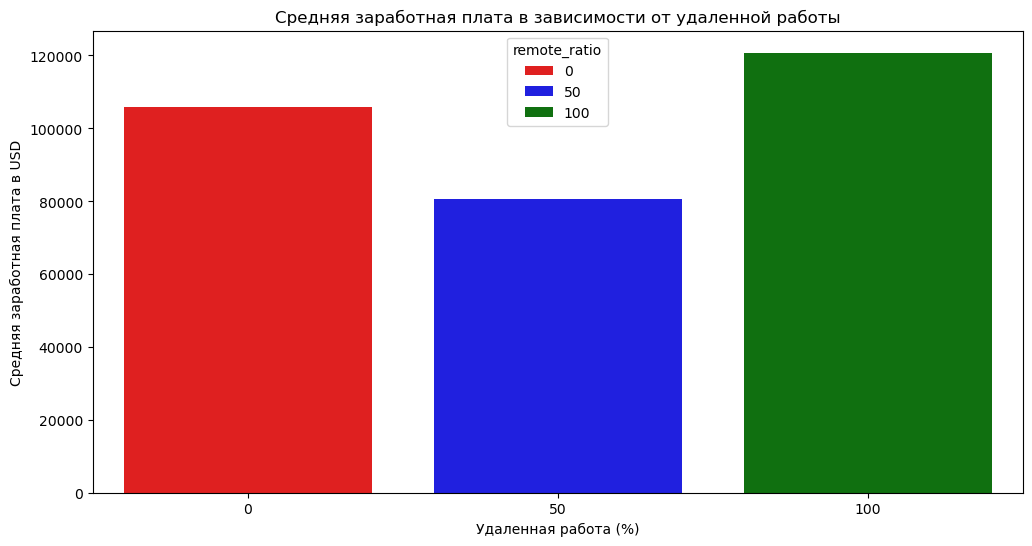

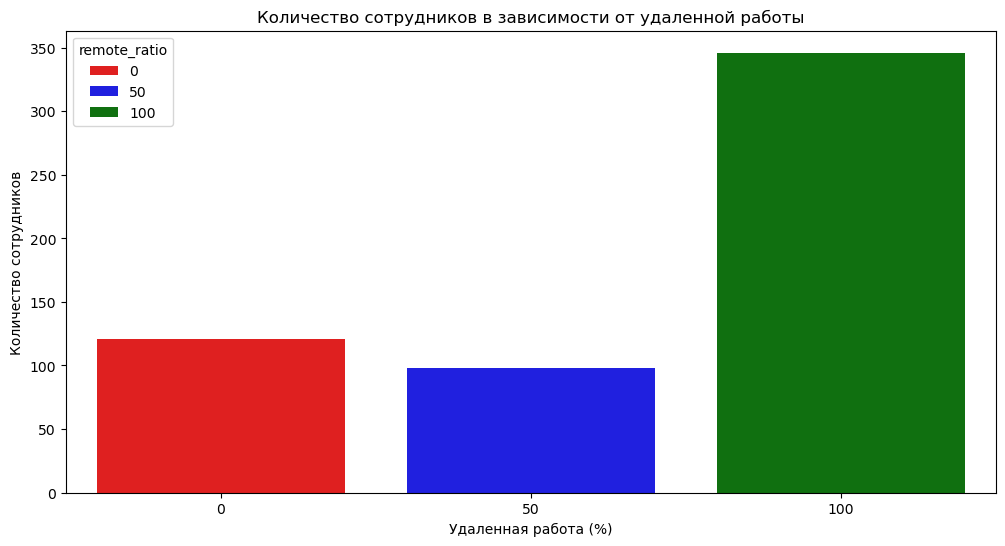

In [392]:
# Функция для создания графиков
def plot_chart(plot_func, title, xlabel, ylabel, palette, **kwargs):
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    plot_func(**kwargs, palette=palette)  # Построение графика с указанной палитрой
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.show()  # Отображение графика

# 1. График распределения зарплат по уровню удаленной работы
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат в зависимости от удаленной работы',
    xlabel='Удаленная работа (%)',
    ylabel='Заработная плата в USD',
    palette=['red', 'blue', 'green'],
    x='remote_ratio', y='salary_in_usd', data=df, hue='remote_ratio'
)

# 2. График средней зарплаты по уровням удаленной работы
plot_chart(
    sns.barplot,
    title='Средняя заработная плата в зависимости от удаленной работы',
    xlabel='Удаленная работа (%)',
    ylabel='Средняя заработная плата в USD',
    palette=['red', 'blue', 'green'],
    x='remote_ratio', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, hue='remote_ratio'
)

# 3. График количества сотрудников по уровням удаленной работы
plot_chart(
    sns.countplot,
    title='Количество сотрудников в зависимости от удаленной работы',
    xlabel='Удаленная работа (%)',
    ylabel='Количество сотрудников',
    palette=['red', 'blue', 'green'],
    x='remote_ratio', data=df, hue='remote_ratio'
)


### **Выводы по графику распределения заработных плат в зависимости от удаленной работы**:

1. **Средняя зарплата**: Средняя зарплата выше для тех, кто работает удаленно на 100% (зеленый цвет), по сравнению с теми, кто работает удаленно на 0% (красный цвет) и 50% (синий цвет).

2. **Разброс зарплат**: Разброс зарплат (межквартильный размах) также выше для 100% удаленной работы, что указывает на большую вариативность в зарплатах.

3. **Выбросы**: Есть несколько выбросов, особенно для 0% и 100% удаленной работы, что указывает на наличие высокооплачиваемых позиций в этих категориях.

**Причины и гипотезы**:

1. **Гибкость и производительность**: Работники, работающие удаленно на 100%, могут быть более продуктивными и гибкими, что может приводить к более высоким зарплатам.

2. **Снижение затрат**: Компании могут экономить на офисных расходах и перенаправлять эти средства на зарплаты сотрудников, работающих удаленно.

3. **Конкуренция за таланты**: В условиях глобального рынка труда компании могут предлагать более высокие зарплаты, чтобы привлекать и удерживать удаленных сотрудников.

**Рекомендации**:

1. **Поддержка удаленной работы**: Компаниям следует рассмотреть возможность увеличения доли удаленной работы для повышения удовлетворенности сотрудников и привлечения талантов.

2. **Анализ производительности**: Провести анализ производительности сотрудников, работающих удаленно, чтобы определить, как это влияет на их эффективность и зарплаты.

3. **Обучение и развитие**: Инвестировать в обучение и развитие навыков сотрудников для повышения их производительности и, соответственно, зарплат.

### **Выводы по графику средней заработной платы в зависимости от удаленной работы**:

**1. Средняя зарплата**: Наивысшая средняя зарплата у сотрудников, работающих удаленно на 100% (около 120 000 USD). Те, кто работает удаленно на 50%, имеют среднюю зарплату около 80 000 USD, а те, кто работает полностью офлайн — чуть более 100 000 USD.

**2. Разброс зарплат**: Разброс зарплат наиболее велик среди тех, кто работает удаленно на 100%, что указывает на большую вариативность в зарплатах в этой категории.

**Причины и гипотезы**:

1. **Гибкость и производительность**: Сотрудники, работающие удаленно на 100%, могут быть более продуктивными и гибкими, что может привести к более высоким зарплатам.

2. **Снижение затрат**: Компании могут экономить на офисных расходах и перенаправлять эти средства на зарплаты сотрудников, работающих удаленно.

3. **Конкуренция за таланты**: В условиях глобального рынка труда компании могут предлагать более высокие зарплаты, чтобы привлекать и удерживать удаленных сотрудников.

**Рекомендации**:

1. **Поддержка удаленной работы**: Компаниям следует рассмотреть возможность увеличения доли удаленной работы для повышения удовлетворенности сотрудников и привлечения талантов.

2. **Анализ производительности**: Провести анализ производительности сотрудников, работающих удаленно, чтобы определить, как это влияет на их эффективность и зарплаты.

3. **Обучение и развитие**: Инвестировать в обучение и развитие навыков сотрудников для повышения их производительности и, соответственно, зарплат.

### **Выводы по графику количества сотрудников в зависимости от удаленной работы**:

1. **Преобладание удаленной работы**: Большинство сотрудников предпочитают работать удаленно на 100% (около 325 сотрудников).

2. **Средний уровень удаленной работы**: У сотрудников с 50% удаленной работы меньшее количество (около 100 сотрудников).

3. **Минимальная удаленная работа**: Самое малое количество сотрудников работает без удаленной работы (около 125 сотрудников).

**Причины и гипотезы**:
1. **Гибкость и удобство**: Сотрудники, работающие удаленно на 100%, ценят гибкость и удобство, что может объяснять их преобладание.

2. **Оптимизация ресурсов**: Компании могут оптимизировать затраты, позволяя большему количеству сотрудников работать удаленно.

3. **Технологическая готовность**: Развитие технологий позволяет большему количеству сотрудников эффективно работать удаленно.

**Рекомендации**:
1. **Поддержка удаленной работы**: Поощрять и поддерживать 100% удаленную работу, чтобы сохранить уровень удовлетворенности сотрудников.

2. **Смешанные модели**: Рассмотреть возможность внедрения смешанных моделей работы (например, 50%), чтобы адаптироваться к различным потребностям сотрудников.

3. **Инвестиции в технологии**: Вкладывать в технологии, которые позволяют эффективнее работать удаленно, улучшая производительность и удовлетворенность сотрудников.

### **2.6 Анализ признака company_location (местоположение компании)**

**Создаем визуализации, показывая распределение зарплат, среднюю зарплату и количество вакансий в зависимости от местоположения компаний**

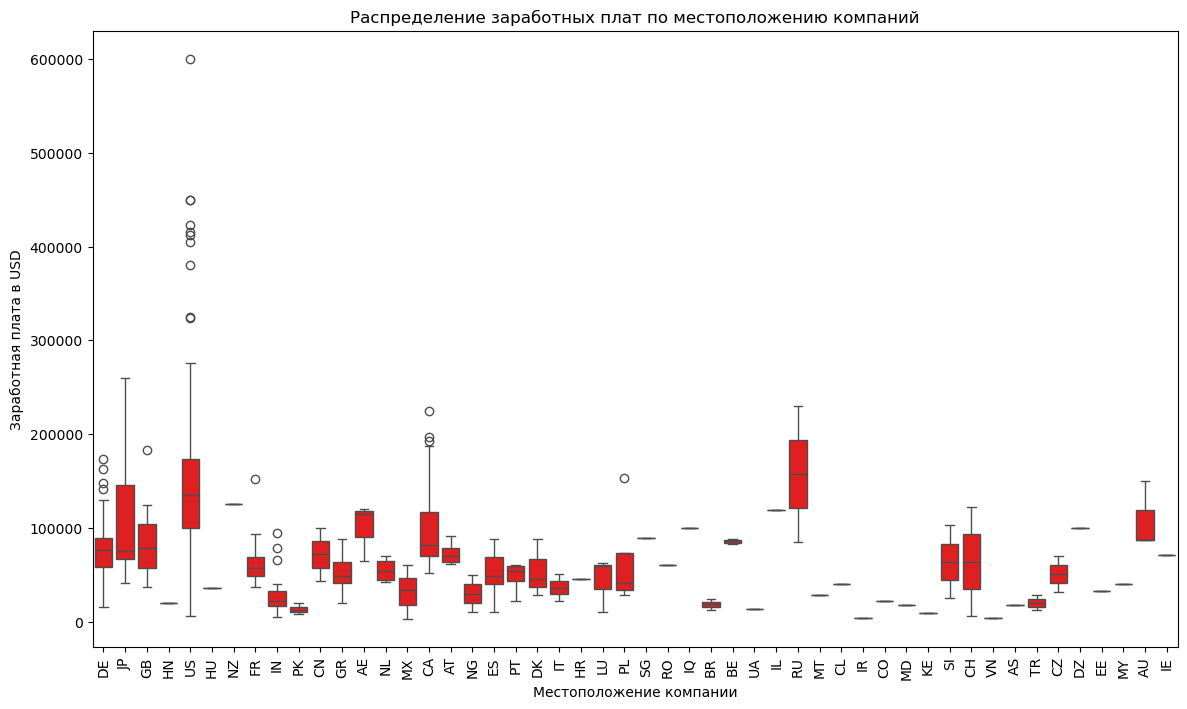

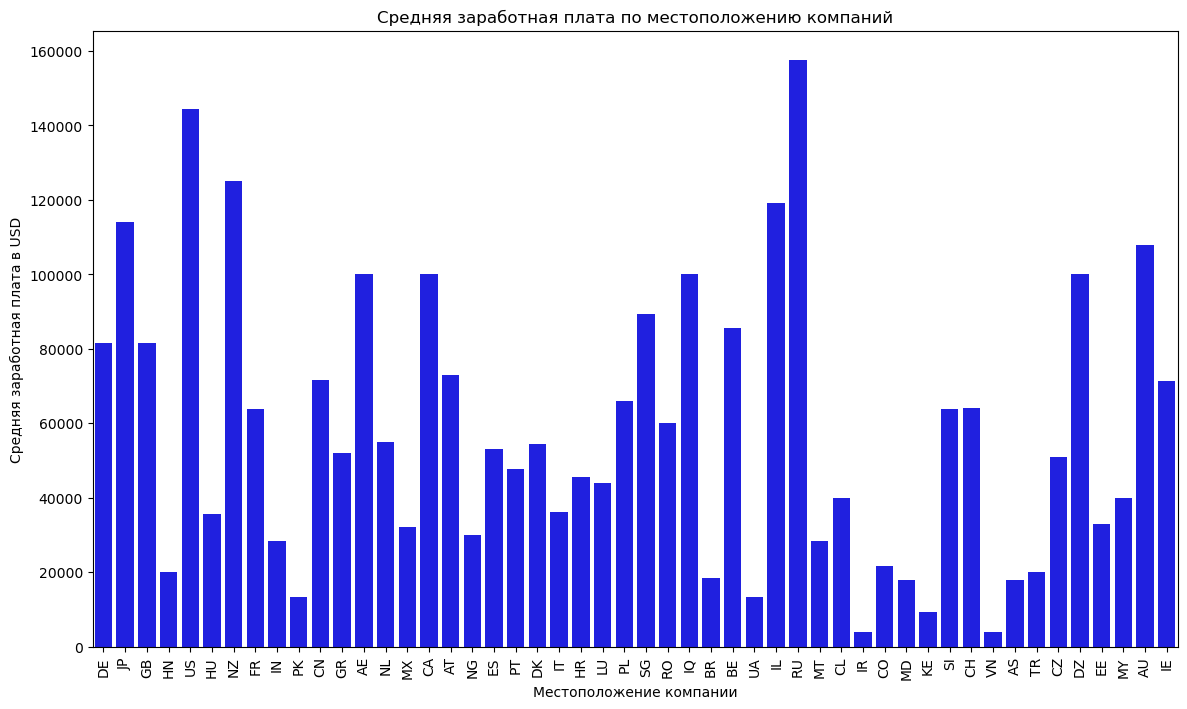

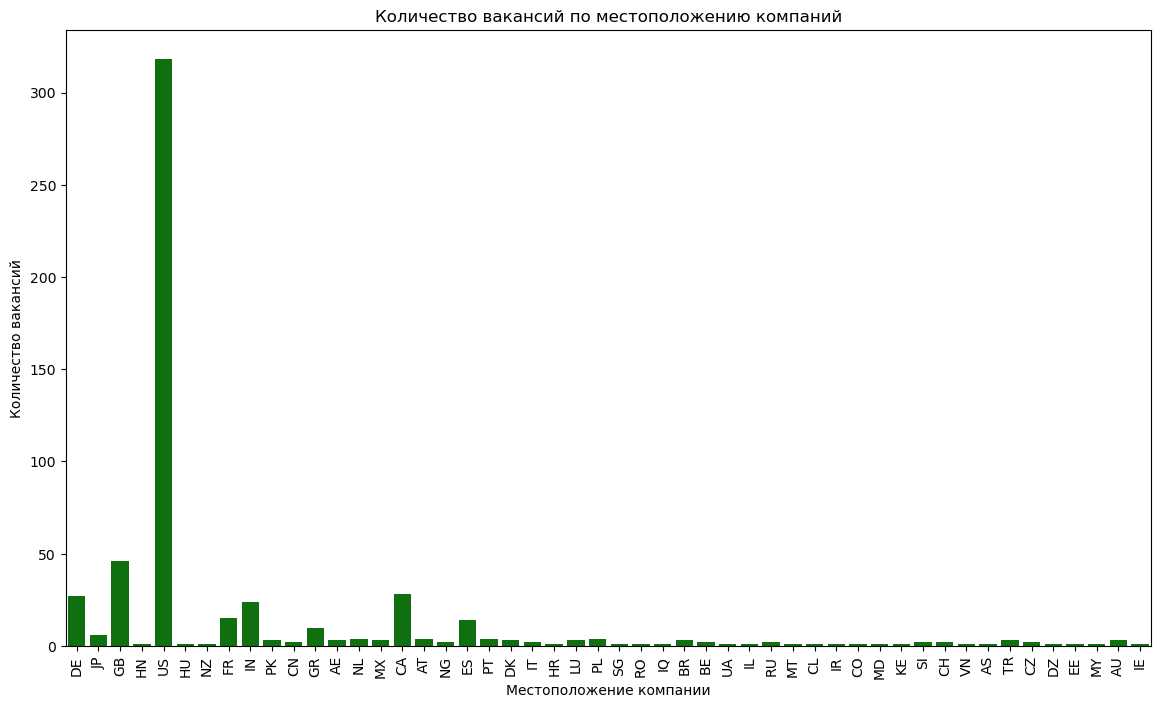

In [393]:
# Функция для создания графиков
def plot_chart(plot_func, title, xlabel, ylabel, color, rotation=0, **kwargs):
    plt.figure(figsize=(14, 8))  # Размер графика
    plot_func(**kwargs, color=color)  # Построение графика с указанным цветом
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.xticks(rotation=rotation)  # Поворот меток оси X
    plt.show()  # Отображение графика

# 1. График распределения зарплат по местоположению компаний
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат по местоположению компаний',
    xlabel='Местоположение компании',
    ylabel='Заработная плата в USD',
    color='red',
    x='company_location', y='salary_in_usd', data=df, rotation=90
)

# 2. График средней зарплаты по местоположению компаний
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по местоположению компаний',
    xlabel='Местоположение компании',
    ylabel='Средняя заработная плата в USD',
    color='blue',
    x='company_location', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, rotation=90
)

# 3. График количества вакансий по местоположению компаний
plot_chart(
    sns.countplot,
    title='Количество вакансий по местоположению компаний',
    xlabel='Местоположение компании',
    ylabel='Количество вакансий',
    color='green',
    x='company_location', data=df, rotation=90
)


### **Выводы по графику распределения заработных плат по местоположению компаний**:

1. **Высокие зарплаты в США**: Согласно данным, компании в США предлагают самые высокие медианные зарплаты, с несколькими выбросами, указывающими на очень высокие зарплаты.

2. **Высокие зарплаты в развитых странах**: Германия, Япония, Великобритания и Швейцария также демонстрируют высокие медианные зарплаты с некоторыми выбросами.

3. **Низкие зарплаты в развивающихся странах**: Индия, Иран и Пакистан показывают более низкие медианные зарплаты с меньшей вариативностью.

**Причины и гипотезы**:

1. **Экономическое развитие**: Высокие зарплаты в США и других развитых странах могут быть связаны с уровнем экономического развития и жизненным стандартом.

2. **Развитие технологий**: В странах с высоким уровнем технологий и инноваций (например, США, Германия, Япония) зарплаты могут быть выше из-за спроса на квалифицированных специалистов.

3. **Глобальные компании**: Наличие глобальных корпораций и их штаб-квартир в развитых странах может способствовать высоким зарплатам в этих регионах.

**Рекомендации**:

1. **Повышение квалификации**: Работникам в развивающихся странах рекомендуется повышать свои квалификации и навыки, чтобы быть конкурентоспособными на глобальном рынке труда.

2. **Поддержка стартапов**: Правительствам развивающихся стран следует поддерживать развитие стартапов и инноваций, чтобы стимулировать экономический рост и повышение зарплат.

3. **Глобальные партнёрства**: Компаниям в развитых странах следует рассматривать возможность сотрудничества и инвестиций в развивающиеся регионы для создания рабочих мест и повышения зарплат.

### **Выводы по графику средняя заработная плата по местоположению компаний**:

1. **Высокие зарплаты в Израиле (IL)**: Средняя зарплата превышает 160 000 USD, что делает его лидером среди представленных локаций.

2. **Высокие зарплаты в США, Люксембурге и Ирландии (US, LU, IE)**: Средняя зарплата составляет около или выше 100 000 USD, указывая на высокий уровень оплаты труда в этих странах.

3. **Низкие зарплаты в Индии, Иране и Пакистане (IN, IR, PK)**: Средняя зарплата ниже 40 000 USD, что показывает значительные различия в зарплатах в разных регионах.

**Причины и гипотезы**:

1. **Экономическое развитие**: Высокие зарплаты в развитых странах могут быть связаны с уровнем экономического развития и жизненным стандартом.

2. **Развитие технологий**: В странах с высоким уровнем технологий и инноваций (например, Израиль, США) зарплаты могут быть выше из-за спроса на квалифицированных специалистов.

3. **Глобальные компании**: Наличие глобальных корпораций и их штаб-квартир в развитых странах может способствовать высоким зарплатам в этих регионах.

**Рекомендации**:

1. **Повышение квалификации**: Работникам в развивающихся странах рекомендуется повышать свои квалификации и навыки, чтобы быть конкурентоспособными на глобальном рынке труда.

2. **Поддержка стартапов**: Правительствам развивающихся стран следует поддерживать развитие стартапов и инноваций, чтобы стимулировать экономический рост и повышение зарплат.

3. **Глобальные партнёрства**: Компаниям в развитых странах следует рассматривать возможность сотрудничества и инвестиций в развивающиеся регионы для создания рабочих мест и повышения зарплат.

### **Выводы по графику количество вакансий по местоположению компаний**:

1. **Преобладание вакансий в США**: Большинство вакансий сосредоточено в США, с числом более 300 вакансий.

2. **Наличие вакансий в Великобритании, Германии и Венгрии**: В этих странах также наблюдается значительное количество вакансий, хотя и значительно меньше, чем в США.

3. **Меньшее количество вакансий в других странах**: В других странах количество вакансий значительно меньше, что может свидетельствовать о концентрации рабочих мест в определенных регионах.

**Причины и гипотезы**:

1. **Экономические факторы**: США может иметь больше вакансий из-за своей большой экономики и большого количества компаний.

2. **Концентрация индустрий**: Определенные индустрии, которые нанимают сотрудников, могут быть более сосредоточены в США.

3. **Спрос на рынке**: В США может быть более высокий спрос на рабочие места, что приводит к большему количеству вакансий.

4. **Штаб-квартиры компаний**: Многие международные компании имеют свои штаб-квартиры в США, что также может способствовать большему числу вакансий.

**Рекомендации**:

1. **Искатели работы**: Людям, ищущим работу, следует сосредоточить свои поиски на США, учитывая большое количество вакансий.

2. **Компании**: Компании в странах с меньшим количеством вакансий могут рассмотреть возможность расширения своих операций или размещения вакансий, чтобы привлечь больше талантов.

3. **Политики**: Правительствам в странах с меньшим количеством вакансий стоит исследовать причины низких показателей и внедрять меры по стимулированию роста занятости.

4. **Дополнительные исследования**: Провести дополнительные исследования для понимания конкретных индустрий и ролей, которые способствуют высокому числу вакансий в США.

### **2.7 Анализ признака company_sizes (размер компании)**

**Извлекаем уникальные размеры компаний, рассчитываем для них основные статистические показатели по зарплатам и выводим результаты для каждого размера компании**

In [394]:
from scipy import stats

# Получение уникальных размеров компаний
company_sizes = df['company_size'].unique()

# Функция для расчета статистики
def calculate_stats(data):
    return {
        'count': data.shape[0],
        'mean': data['salary_in_usd'].mean(),
        'std': data['salary_in_usd'].std(),
        'min': data['salary_in_usd'].min(),
        'max': data['salary_in_usd'].max(),
        'quantiles': data['salary_in_usd'].quantile([0.25, 0.5, 0.75]).to_list(),
        'normaltest_pvalue': stats.normaltest(data['salary_in_usd'].dropna()).pvalue,
        'mad': (data['salary_in_usd'] - data['salary_in_usd'].median()).abs().median(),
        'skewness': data['salary_in_usd'].skew(),
        'kurtosis': data['salary_in_usd'].kurtosis()
    }

# Создание словаря с статистикой по размеру компаний
salary_stats_by_company_size = {size: calculate_stats(df[df['company_size'] == size]) for size in company_sizes}

# Функция для вывода статистики
def print_stats(size, stats):
    print(f"Статистика для размера компании {size}:")
    print(f"Количество записей: {stats['count']}")
    print(f"Средняя заработная плата: {stats['mean']} USD")
    print(f"Стандартное отклонение: {stats['std']} USD")
    print(f"Минимальная заработная плата: {stats['min']} USD")
    print(f"Максимальная заработная плата: {stats['max']} USD")
    print(f"Квантили: {stats['quantiles']}")
    print(f"P-значение теста на нормальность: {stats['normaltest_pvalue']}")
    print(f"Медианное абсолютное отклонение (МАО): {stats['mad']} USD")
    print(f"Коэффициент асимметрии: {stats['skewness']}")
    print(f"Коэффициент эксцесса: {stats['kurtosis']}\n")

# Вывод статистики для каждого размера компании
for size, stats in salary_stats_by_company_size.items():
    print_stats(size, stats)


Статистика для размера компании L:
Количество записей: 193
Средняя заработная плата: 118213.88082901554 USD
Стандартное отклонение: 86753.27098498998 USD
Минимальная заработная плата: 5882 USD
Максимальная заработная плата: 600000 USD
Квантили: [60000.0, 100000.0, 153667.0]
P-значение теста на нормальность: 2.4004065265931784e-22
Медианное абсолютное отклонение (МАО): 46808.0 USD
Коэффициент асимметрии: 2.037051689268489
Коэффициент эксцесса: 6.601037687108795

Статистика для размера компании S:
Количество записей: 82
Средняя заработная плата: 77872.09756097561 USD
Стандартное отклонение: 63814.51606227199 USD
Минимальная заработная плата: 2859 USD
Максимальная заработная плата: 416000 USD
Квантили: [41816.0, 65511.0, 100000.0]
P-значение теста на нормальность: 1.9270736316518693e-14
Медианное абсолютное отклонение (МАО): 32268.5 USD
Коэффициент асимметрии: 2.422366035485632
Коэффициент эксцесса: 9.61623331234222

Статистика для размера компании M:
Количество записей: 290
Средняя зараб

### **Выводы**:

1. **Компания L**:
   - Средняя зарплата самая высокая среди всех категорий (118,213.88 USD), но при этом наблюдается большое стандартное отклонение (86,753.27 USD), что говорит о значительной разнице в уровнях зарплат среди сотрудников.
   - Коэффициент асимметрии (2.04) и эксцесса (6.60) указывают на значительную правостороннюю асимметрию и резкий пик распределения. Это означает, что значительная часть зарплат сосредоточена ниже среднего уровня, с наличием очень высоких зарплат, сильно превышающих медиану.
   - P-значение теста на нормальность (2.4e-22) крайне мало, что свидетельствует о том, что распределение зарплат далеко от нормального.

2. **Компания S**:
   - Средняя зарплата (77,872.10 USD) ниже, чем в компаниях L и M, что соответствует ожиданиям для небольших компаний.
   - Стандартное отклонение также велико (63,814.52 USD), что указывает на значительные различия в зарплатах.
   - Коэффициент асимметрии (2.42) и эксцесса (9.62) показывают ещё более сильную асимметрию и высокую "кучность" данных. Это говорит о том, что большинство зарплат сосредоточены в нижней части диапазона, а верхние значения выбиваются значительно выше.
   - P-значение (1.9e-14) также говорит о ненормальном распределении зарплат.

3. **Компания M**:
   - По сравнению с компаниями L и S, распределение зарплат ближе к нормальному: коэффициент асимметрии (0.84) и эксцесса (2.59) указывают на менее выраженную правостороннюю асимметрию.
   - Медианное абсолютное отклонение (40360 USD) меньше, чем у компаний L и S, что может свидетельствовать о меньшем разбросе зарплат.
   - Хотя распределение зарплат в компании M всё ещё не является нормальным (p-значение мало), оно ближе к нормальному распределению, чем в других категориях компаний.

**Причины и гипотезы**:

1. **Влияние размера компании на зарплату**:
   - В крупных компаниях (L) есть больше возможностей для высокооплачиваемых должностей, что приводит к широкому разбросу зарплат. Очень высокая максимальная зарплата (600,000 USD) может указывать на наличие высококвалифицированных специалистов или руководителей, получающих значительно больше среднего уровня.
   - В небольших компаниях (S) зарплаты более сжаты, но присутствуют выбросы, которые могут быть связаны с редкими случаями высоких зарплат, возможно, из-за руководящих ролей или специализированных позиций.
   - Компании среднего размера (M) имеют более сбалансированное распределение зарплат, что может быть связано с тем, что эти компании предоставляют равномерные возможности для карьерного роста и зарплатных уровней.

2. **Асимметрия и эксцесс**:
   - Высокие значения коэффициентов асимметрии и эксцесса указывают на наличие значительных выбросов в виде очень высоких зарплат. Это особенно характерно для компаний S и L, где возможно наличие топ-менеджеров или специалистов с редкими навыками, получающих зарплаты, выходящие за общие рамки распределения.

**Рекомендации**:

1. **Для компаний категории L**:
   - Рассмотреть возможности улучшения прозрачности в системе вознаграждений, чтобы уменьшить разрыв между высокооплачиваемыми и среднеоплачиваемыми сотрудниками.
   - Внедрить программы поддержки и развития для сотрудников с низкими и средними зарплатами, чтобы увеличить их мотивацию и производительность.

2. **Для компаний категории S**:
   - Поскольку небольшие компании характеризуются более низкими средними зарплатами и сильной правосторонней асимметрией, стоит фокусироваться на выравнивании зарплат среди сотрудников. Можно внедрить стратегии по удержанию ключевых сотрудников, предлагая конкурентные компенсационные пакеты.
   - Сфокусироваться на сокращении зарплатных разрывов, предлагая больше возможностей для роста и повышения квалификации.

3. **Для компаний категории M**:
   - Поскольку распределение зарплат ближе к нормальному, можно поддерживать уже существующий баланс. Однако стоит внимательно рассматривать отклонения и продолжать выравнивать зарплаты для сотрудников разных должностей, чтобы избегать значительных разрывов.

4. **Гипотеза о связи зарплат и структуры компании**:
   - В крупных компаниях существует тенденция к большему разбросу зарплат, связанная с более широкой структурой должностей и карьерных возможностей. Средние компании более сбалансированы, что делает их привлекательными для сотрудников, ищущих стабильность.

**Создаем функцию для построения графиков и используем её для визуализации распределения зарплат, средней зарплаты и количества вакансий по размеру компаний с помощью заданных цветовых палитр**

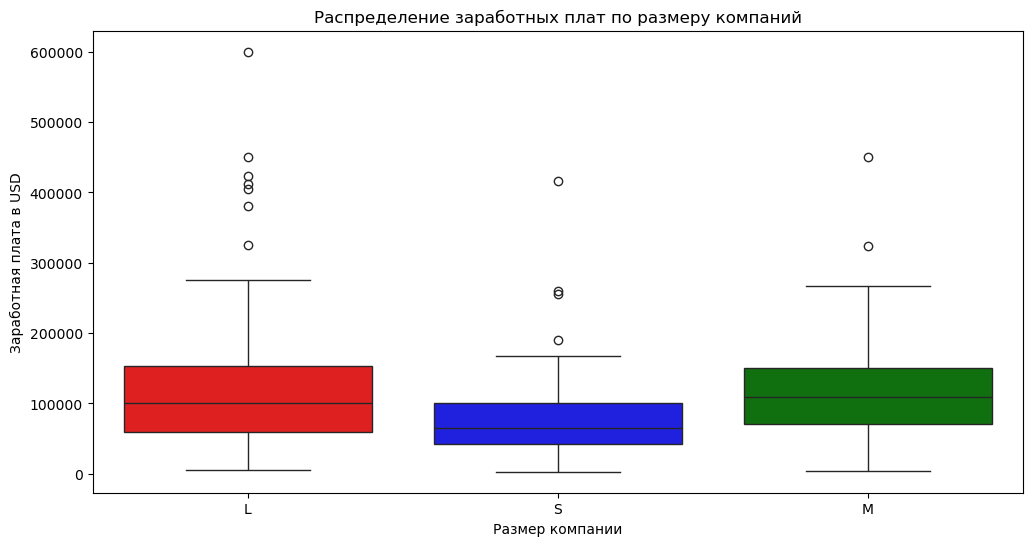

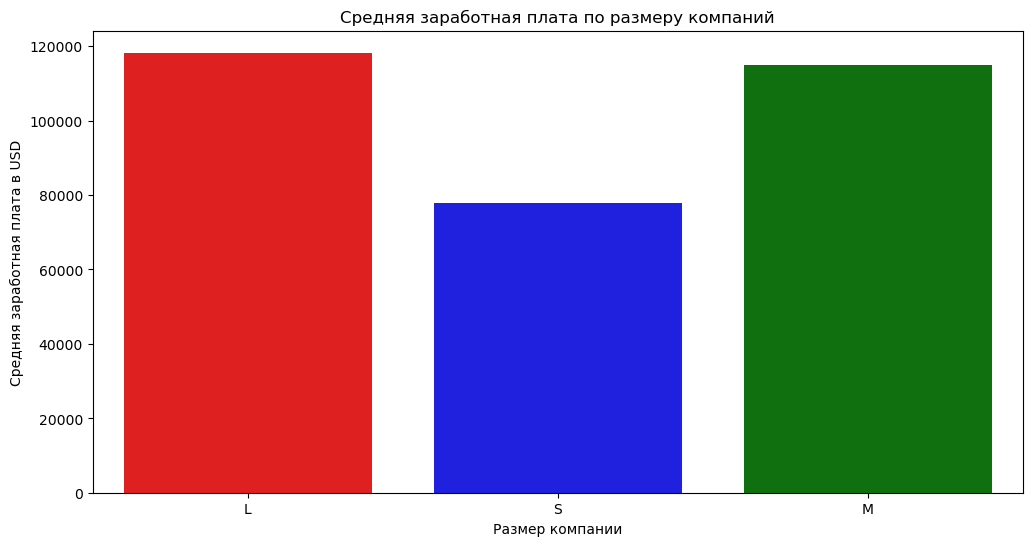

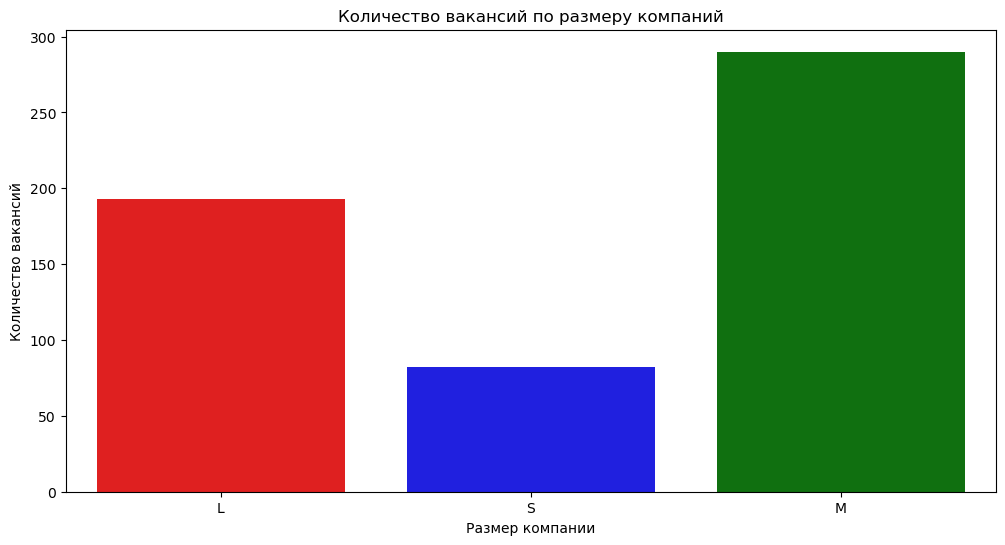

In [395]:
# Функция для построения графиков
def plot_chart(plot_func, title, xlabel, ylabel, palette, **kwargs):
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    plot_func(**kwargs, palette=palette)  # Построение графика с указанной палитрой
    plt.title(title)  # Заголовок графика
    plt.xlabel(xlabel)  # Подпись оси X
    plt.ylabel(ylabel)  # Подпись оси Y
    plt.show()  # Отображение графика

# 1. График распределения зарплат по размеру компаний
plot_chart(
    sns.boxplot,
    title='Распределение заработных плат по размеру компаний',
    xlabel='Размер компании',
    ylabel='Заработная плата в USD',
    palette=['red', 'blue', 'green'],
    x='company_size', y='salary_in_usd', data=df, hue='company_size'
)

# 2. График средней зарплаты по размеру компаний
plot_chart(
    sns.barplot,
    title='Средняя заработная плата по размеру компаний',
    xlabel='Размер компании',
    ylabel='Средняя заработная плата в USD',
    palette=['red', 'blue', 'green'],
    x='company_size', y='salary_in_usd', data=df, estimator=np.mean, errorbar=None, hue='company_size'
)

# 3. График количества вакансий по размеру компаний
plot_chart(
    sns.countplot,
    title='Количество вакансий по размеру компаний',
    xlabel='Размер компании',
    ylabel='Количество вакансий',
    palette=['red', 'blue', 'green'],
    x='company_size', data=df, hue='company_size'
)


### **Выводы по графику распределения заработных плат по размеру компаний**:

1. **Компании категории L (Крупные компании)**:
   - Диапазон зарплат значителен, что подтверждается большим разрывом между первым и третьим квартилями (межквартильный размах), а также наличием множества выбросов в виде высоких зарплат, превышающих 300,000 USD. Это соответствует ранее сделанным выводам о высокой вариативности зарплат в крупных компаниях.
   - Медиана заработных плат в крупных компаниях выше, чем у средних и малых компаний, что отражает более высокую среднюю заработную плату.

2. **Компании категории S (Малые компании)**:
   - Диапазон зарплат в малых компаниях меньше, чем в компаниях других категорий. На графике можно увидеть, что медиана заработных плат в малых компаниях заметно ниже, а также присутствуют выбросы, указывающие на редкие высокие зарплаты.
   - Верхняя граница зарплат у компаний категории S намного ниже, чем у компаний L и M, что может свидетельствовать о меньших возможностях для высокооплачиваемых должностей в малых компаниях.

3. **Компании категории M (Средние компании)**:
   - Распределение зарплат в средних компаниях более сбалансировано по сравнению с компаниями категории L и S. Медиана зарплат и межквартильный размах указывают на умеренную разбросанность зарплат, а выбросы встречаются реже, чем в других категориях.
   - Диапазон зарплат в компаниях категории M меньше, чем в крупных компаниях, но выше, чем в малых.

**Причины и гипотезы**:

1. **Влияние размера компании на разброс зарплат**:
   - Крупные компании, как правило, предлагают более широкий диапазон заработных плат из-за наличия большого количества должностей разного уровня, от начальных позиций до топ-менеджмента. Это объясняет наличие выбросов в виде высоких зарплат в компаниях категории L.
   - Малые компании имеют ограниченные возможности по оплате труда, что сказывается на меньшем диапазоне зарплат и их более низкой медиане. Однако наличие выбросов указывает на то, что некоторые сотрудники на специализированных должностях могут получать значительно больше остальных.
   - Средние компании предлагают более сбалансированные возможности для карьерного роста и заработной платы, что объясняет меньший разброс и отсутствие большого количества выбросов.

2. **Асимметрия и распределение зарплат**:
   - Для малых и крупных компаний характерна большая правосторонняя асимметрия, что подтверждается выбросами в виде высоких зарплат. Это может быть связано с редкими, но высокооплачиваемыми позициями, которые существенно превышают типичный уровень зарплат в данных категориях компаний.

**Рекомендации**:

1. **Для крупных компаний (L)**:
   - Учитывая значительный разброс зарплат, стоит пересмотреть подход к управлению компенсацией сотрудников. Возможно, стоит уменьшить разрыв между высокооплачиваемыми и среднеоплачиваемыми сотрудниками для повышения удовлетворённости персонала.
   - Важно разработать программы профессионального развития для сотрудников с более низкими зарплатами, чтобы обеспечить равные возможности для карьерного роста.

2. **Для малых компаний (S)**:
   - Необходимо рассмотреть возможность создания более прозрачной системы вознаграждений, чтобы уменьшить расслоение зарплат и удерживать талантливых сотрудников.
   - Стоит сфокусироваться на программах по развитию сотрудников, что может помочь уменьшить разрыв между средней зарплатой и зарплатами высококвалифицированных специалистов.

3. **Для средних компаний (M)**:
   - Средним компаниям рекомендуется поддерживать уже существующий баланс в структуре зарплат, однако важно регулярно пересматривать компенсационные пакеты, чтобы избежать значительных отклонений и обеспечить конкурентоспособность на рынке труда.
   - Важно продолжать предлагать возможности карьерного роста и профессионального развития, чтобы удерживать высококвалифицированных сотрудников.

4. **Гипотеза о зависимости зарплат от размера компании**:
   - Крупные компании предлагают больше высоких зарплат, но также имеют значительный разброс в зависимости от уровня должности. Средние компании сбалансированы и стабильны в своей политике зарплат, тогда как малые компании имеют ограниченные ресурсы для оплаты труда, что ведёт к более узкому диапазону зарплат.

### **Выводы по графику средней заработной платы по размкру компаний**:

1. **Крупные компании (L)**:
   - Средняя заработная плата в крупных компаниях значительно выше по сравнению с другими категориями, достигая примерно 120,000 USD. Это подтверждает тенденцию, что в крупных организациях сотрудники могут рассчитывать на более высокие зарплаты, особенно на старших и руководящих позициях.

2. **Малые компании (S)**:
   - В малых компаниях средняя заработная плата составляет около 77,000 USD, что существенно ниже, чем в компаниях других категорий. Это может быть связано с ограниченными финансовыми ресурсами малых компаний и их неспособностью предлагать конкурентные пакеты вознаграждения.

3. **Средние компании (M)**:
   - Средняя зарплата в средних компаниях составляет около 100,000 USD, что делает их промежуточным вариантом между малыми и крупными компаниями. Они предлагают зарплаты, которые выше, чем в малых компаниях, но все же ниже, чем в крупных.

**Причины и гипотезы**:

1. **Влияние размера компании на среднюю зарплату**:
   - **Крупные компании** могут предложить более высокие зарплаты из-за своих ресурсов, большого количества сотрудников и возможности нанимать высококвалифицированных специалистов на ключевые роли. Также в крупных компаниях есть больше возможностей для роста и продвижения по карьерной лестнице, что может объяснять наличие высоких зарплат.
   - **Малые компании** часто имеют ограниченные бюджеты и меньше возможностей для предложения конкурентоспособных зарплат. Это ограничивает их способности нанимать специалистов с высоким уровнем квалификации или опыта.
   - **Средние компании** находятся в более сбалансированном положении, предлагая зарплаты выше, чем малые компании, но не достигая уровня зарплат в крупных компаниях. Это может быть связано с более ограниченными финансовыми ресурсами по сравнению с крупными компаниями, но с наличием стабильного роста и увеличения возможностей для найма специалистов.

2. **Структура зарплат**:
   - Крупные компании, как правило, предоставляют более высокие зарплаты на всех уровнях, что подтверждается средним значением зарплат. В то время как малые компании имеют более сжатую структуру зарплат с акцентом на сотрудников с меньшим опытом или должностями более низкого уровня.

**Рекомендации**:

1. **Крупные компании (L)**:
   - Продолжать поддерживать систему оплаты труда, направленную на привлечение и удержание высококвалифицированных специалистов. Однако необходимо контролировать разрыв между высокооплачиваемыми и среднеоплачиваемыми сотрудниками, чтобы избежать демотивации последних.
   - Активно предлагать возможности для карьерного роста и повышения зарплат, чтобы поддерживать конкурентоспособность на рынке труда.

2. **Малые компании (S)**:
   - Чтобы привлечь и удержать талантливых сотрудников, малым компаниям следует рассмотреть возможность введения других форм компенсации, таких как бонусы, опционы на акции или гибкий график работы, которые могут компенсировать более низкие зарплаты.
   - Разработать стратегии повышения зарплат сотрудников, особенно для ключевых позиций, чтобы повысить привлекательность компании на рынке труда.

3. **Средние компании (M)**:
   - Поддерживать баланс между зарплатами, которые выше, чем в малых компаниях, и конкурентоспособностью с крупными компаниями. Это может быть достигнуто за счет предоставления дополнительных возможностей для карьерного роста и обучения, а также через конкурентные компенсационные пакеты для ключевых позиций.
   - Рассмотреть возможности более гибкой системы оплаты труда, чтобы сделать предложения компании более привлекательными для кандидатов с высоким потенциалом.

4. **Гипотеза о зависимости зарплат от размера компании**:
   - Крупные компании платят больше за счет большого бюджета и сложной структуры. Малые компании сталкиваются с ограничениями по ресурсам, что объясняет более низкие зарплаты. Средние компании находятся между этими двумя крайностями, предлагая более сбалансированные условия.

### **Выводы по графику количества вакансий по размеру компаний**:

1. **Крупные компании (L)**:
   - Количество вакансий в крупных компаниях составляет чуть более 200. Это свидетельствует о том, что крупные компании могут позволить себе нанимать значительное количество сотрудников, предлагая большое количество вакансий по разным направлениям.

2. **Малые компании (S)**:
   - Малые компании открывают гораздо меньше вакансий (около 50), что может быть связано с ограниченными ресурсами или меньшими потребностями в найме новых сотрудников. Малые компании часто работают с небольшой командой и могут иметь менее активный процесс расширения.

3. **Средние компании (M)**:
   - Средние компании предлагают наибольшее количество вакансий, около 300. Это может свидетельствовать о том, что средние компании находятся в стадии активного роста и расширения, что требует значительного увеличения численности персонала.

**Причины и гипотезы**:

1. **Крупные компании**:
   - Количество вакансий в крупных компаниях относительно велико, но оно может быть ограничено их зрелостью и стабильностью. Такие компании могут иметь устоявшуюся структуру, и процессы найма в них могут быть более консервативными и зависеть от конкретных проектов и задач.

2. **Малые компании**:
   - Малое количество вакансий объясняется ограниченными ресурсами и небольшими масштабами бизнеса. Небольшие компании часто работают с минимальными командами и могут не иметь возможности или необходимости нанимать большое количество новых сотрудников.

3. **Средние компании**:
   - Средние компании находятся в стадии активного роста, что отражает большое количество открытых вакансий. Они могут стремиться к расширению, как на национальном, так и на международном уровне, что требует постоянного пополнения штата.

**Рекомендации**:

1. **Крупные компании (L)**:
   - Крупным компаниям рекомендуется поддерживать активный процесс найма, чтобы привлекать молодых специалистов и обновлять штат. Это позволит им оставаться конкурентоспособными и гибкими на рынке труда.
   - Следует рассмотреть возможность повышения активности найма, особенно в высокотехнологичных направлениях, где постоянно требуются новые кадры.

2. **Малые компании (S)**:
   - Малым компаниям стоит рассмотреть возможность активизации найма, особенно для ключевых позиций, что позволит поддерживать и ускорять рост бизнеса.
   - Могут быть предложены альтернативные методы найма, такие как сотрудничество с фрилансерами или проектная занятость, чтобы компенсировать недостаток ресурсов.

3. **Средние компании (M)**:
   - Средним компаниям рекомендуется продолжать активный процесс найма для поддержания роста и расширения бизнеса. Важно сосредоточиться на привлечении высококвалифицированных специалистов, которые смогут ускорить рост компании.
   - Следует обратить внимание на развитие кадрового резерва и внутренних программ повышения квалификации, чтобы повысить эффективность процессов и поддерживать стабильность в условиях расширения.

**Гипотезы**:

- **Средние компании**, вероятно, находятся в самой активной стадии роста, что объясняет высокое количество открытых вакансий. Они стремятся быстро расширять бизнес и могут искать сотрудников для широкого спектра задач.
- **Крупные компании**, возможно, поддерживают более консервативный подход к найму, заполняя вакансии только в случаях необходимости, что ограничивает их активность на рынке труда.
- **Малые компании** имеют ограниченные возможности для расширения штата и фокусируются на минимально необходимом количестве сотрудников для выполнения бизнес-задач.

### **2.9 Сравнение и анализ признаков job_title, work_year, company_size, salary_in_usd, experience_level в контексте должностей Data Scientist и Data Engineer**

**Фильтруем данные о зарплатах *Data Scientist* и *Data Engineer* за 2022 год и строим столбчатую диаграмму, показывающую средние зарплаты по уровням опыта для этих должностей**

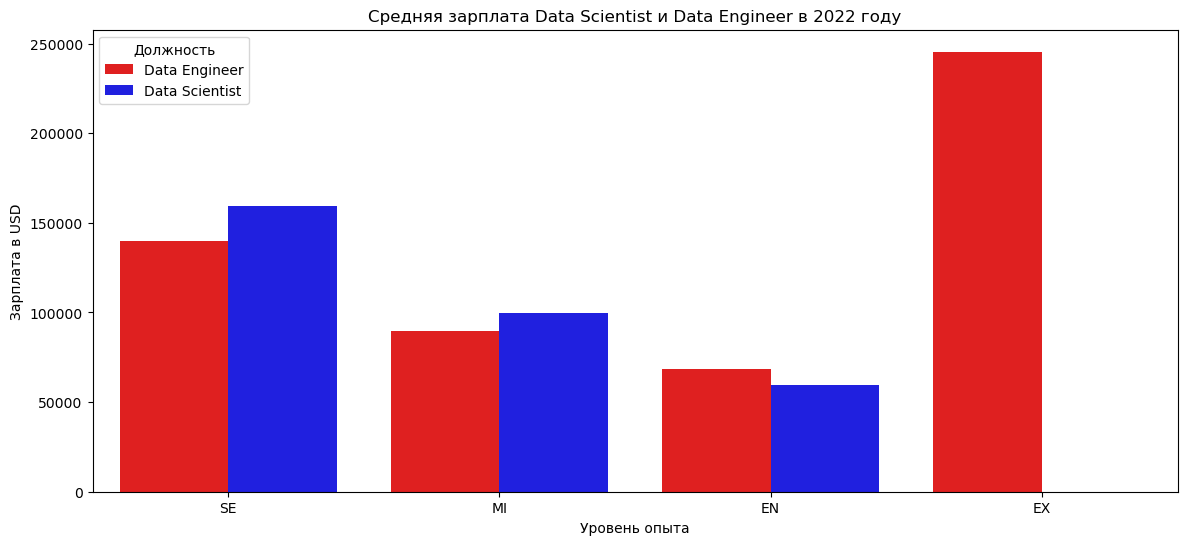

In [396]:
# Фильтрация данных о зарплатах за 2022 год для Data Scientist и Data Engineer
salaries_2022 = df[df['job_title'].isin(['Data Scientist', 'Data Engineer']) & (df['work_year'] == 2022)]

# Объединение данных для Data Scientist и Data Engineer
plt.figure(figsize=(14, 6))

# Построение столбчатой диаграммы средней зарплаты по уровням опыта
sns.barplot(x='experience_level', y='salary_in_usd', hue='job_title', data=salaries_2022, estimator=np.mean, errorbar=None, palette=['red', 'blue'])

# Настройка заголовков и подписей
plt.title('Средняя зарплата Data Scientist и Data Engineer в 2022 году')
plt.xlabel('Уровень опыта')
plt.ylabel('Зарплата в USD')
plt.legend(title='Должность')

# Отображение графика
plt.show()


### **Выводы по графику средней зарплаты Data Scientist и Data Engineer в 2022 году**:

1. **Уровень опыта SE (Начальный опыт)**:
   - Data Scientist с начальным уровнем опыта (SE) зарабатывают больше, чем Data Engineer на этом же уровне. Это указывает на то, что для начинающих специалистов в сфере Data Science зарплаты могут быть выше, вероятно, из-за спроса на специалистов с аналитическими навыками.

2. **Уровень опыта MI (Средний опыт)**:
   - Data Scientist по-прежнему зарабатывают больше, чем Data Engineer. Разрыв в зарплатах сохраняется, хотя и уменьшается по сравнению с начальным уровнем опыта.

3. **Уровень опыта EN (Специалисты)**:
   - На уровне профессионалов (EN) зарплаты Data Scientist и Data Engineer близки друг к другу, но Data Engineer чуть отстают. Этот результат может говорить о том, что для квалифицированных специалистов зарплаты более конкурентоспособны и схожи в обеих профессиях.

4. **Уровень опыта EX (Эксперты)**:
   - Для экспертов (EX) ситуация меняется: Data Engineer зарабатывают значительно больше, чем Data Scientist. Это может свидетельствовать о высокой востребованности технических навыков на уровне эксперта, особенно в области архитектуры данных и управления крупными системами.

**Причины и гипотезы**:

1. **Зарплаты начинающих специалистов (SE)**:
   - Data Scientist могут получать больше на начальном этапе карьеры, поскольку аналитические и статистические навыки востребованы, и компании готовы платить больше за возможность внедрения продвинутого анализа данных.
   
2. **Равенство на среднем уровне (MI)**:
   - На этом этапе специалисты обеих профессий начинают набирать опыт, и их зарплаты становятся более сбалансированными. Компании оценивают не только технические навыки, но и умение работать с данными на системном уровне.

3. **Снижение разрыва на уровне специалистов (EN)**:
   - Разница в зарплатах между Data Scientist и Data Engineer уменьшается, что говорит о сходных требованиях к обеим профессиям в плане опыта и навыков. Важным становится умение интегрировать работу с данными в бизнес-процессы.

4. **Высокие зарплаты для экспертов Data Engineer (EX)**:
   - Эксперты Data Engineer зарабатывают значительно больше, что может объясняться высоким спросом на архитекторов данных и руководителей крупных технических команд, работающих с системами обработки больших данных.

**Рекомендации**:

1. **Начинающие специалисты (SE)**:
   - Для начинающих Data Scientist рекомендуется продолжать развивать навыки анализа данных, машинного обучения и статистики, так как рынок готов платить за такие навыки. Data Engineer могут сосредоточиться на изучении архитектуры данных и системного администрирования, чтобы увеличить свои шансы на повышение зарплаты в будущем.

2. **Средний уровень (MI)**:
   - Data Engineer стоит продолжать развивать свои технические навыки и ориентироваться на роли, связанные с оптимизацией и масштабированием данных. Data Scientist могут сосредоточиться на более углубленном анализе и внедрении машинного обучения.

3. **Специалисты (EN)**:
   - Для обеих категорий важно развивать навыки взаимодействия с бизнесом и умение интегрировать свои технические знания в практическую деятельность компаний. Это поможет им конкурировать на равных условиях и оставаться востребованными.

4. **Экспертный уровень (EX)**:
   - Экспертам Data Scientist рекомендуется расширять технические компетенции в области инженерии данных, чтобы конкурировать с Data Engineer на высоких позициях. Эксперты Data Engineer могут сосредоточиться на развитии лидерских навыков и управлении проектами, чтобы укрепить свои позиции в управлении крупными техническими командами.

**Гипотезы**:

- Спрос на экспертов Data Engineer может быть выше из-за возросшей сложности данных и технических систем, что требует привлечения специалистов для создания устойчивой и масштабируемой инфраструктуры.
- Начальные позиции в Data Science оплачиваются выше из-за более общего спроса на специалистов, которые могут решать бизнес-задачи с помощью данных, тогда как инженерия данных требует больше практических навыков, которые приобретаются со временем.

**Фильтруем данные о зарплатах *Data Scientist* и *Data Engineer* за 2022 год, объединяем их и строим график, показывающий среднюю зарплату в зависимости от уровня опыта для обеих должностей**

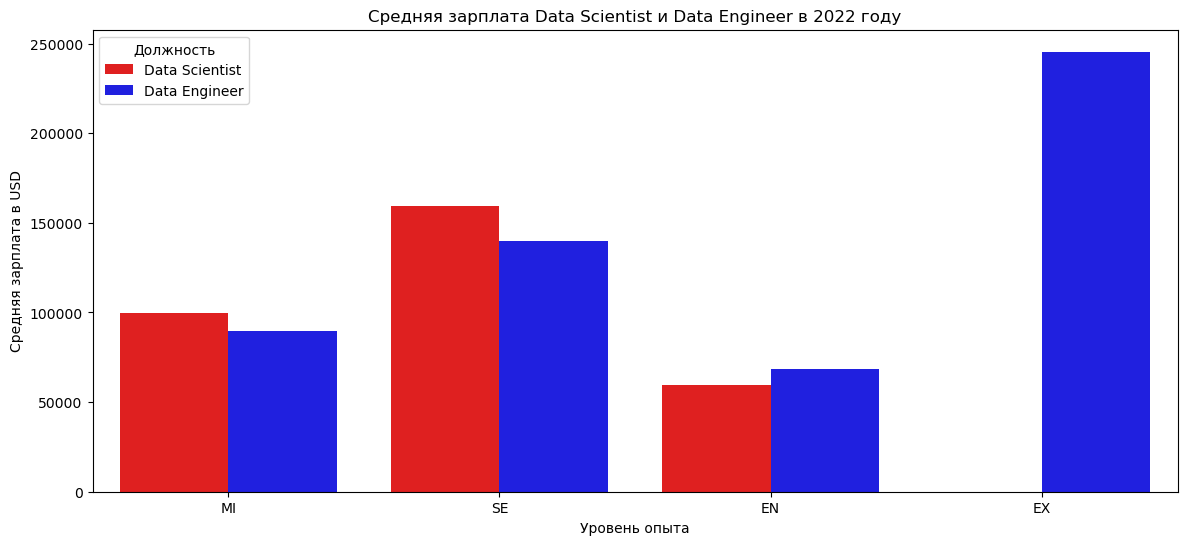

In [397]:
# Фильтрация данных для Data Scientist и Data Engineer за 2022 год
ds_salaries_2022 = df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == 2022)]
de_salaries_2022 = df[(df['job_title'] == 'Data Engineer') & (df['work_year'] == 2022)]

# Объединение данных по двум должностям
combined_data = pd.concat([ds_salaries_2022, de_salaries_2022])

# Построение графика зарплат Data Scientist и Data Engineer в зависимости от уровня опыта
plt.figure(figsize=(14, 6))  # Устанавливаем размер графика
sns.barplot(
    x='experience_level', 
    y='salary_in_usd', 
    hue='job_title', 
    data=combined_data, 
    estimator=np.mean, 
    errorbar=None, 
    palette=['red', 'blue']
)
plt.title('Средняя зарплата Data Scientist и Data Engineer в 2022 году')
plt.xlabel('Уровень опыта')
plt.ylabel('Средняя зарплата в USD')
plt.legend(title='Должность')
plt.show()  # Отображение графика


### **Выводы по графику средней зарплаты Data Scientist и Data Engineer в 2022 году**:

1. **Уровень опыта MI (Junior)**:
   - Data Scientist на этом уровне зарабатывают больше, чем Data Engineer. Разница незначительная, но это может говорить о более высокой начальной стоимости аналитических навыков.

2. **Уровень опыта SE (Senior)**:
   - Data Scientist на уровне Senior зарабатывают больше, чем Data Engineer, хотя разрыв уменьшается по сравнению с уровнем MI. Это может говорить о сбалансированном спросе на аналитические и инженерные навыки.

3. **Уровень опыта EN (Entry-level/Experienced)**:
   - Data Engineer на уровне EN зарабатывают больше, чем Data Scientist, что может свидетельствовать о том, что инженеры данных на этом уровне ценятся больше, особенно за их технические навыки, связанные с управлением инфраструктурой данных.

4. **Уровень опыта EX (Expert)**:
   - Data Engineer на уровне экспертов зарабатывают значительно больше, чем Data Scientist. Это может быть связано с востребованностью экспертов по архитектуре данных и управлению крупными техническими системами.

**Причины и гипотезы**:

1. **Различия на уровне MI**:
   - Data Scientist могут получать больше на младших уровнях (MI) за счет того, что аналитические навыки и знание моделей машинного обучения востребованы на начальном этапе.
   
2. **Разрыв на уровне SE**:
   - На уровне Senior специалисты обеих профессий уже получают сравнимые зарплаты. Это может быть связано с тем, что как инженерные, так и аналитические навыки в равной степени важны для организаций.

3. **Перевес на уровне EN**:
   - Data Engineer на уровне EN получают больше, что может объясняться потребностью в специалистах, способных поддерживать и оптимизировать данные системы на ранних этапах их развития.

4. **Превосходство инженеров на уровне EX**:
   - Высокие зарплаты Data Engineer на уровне EX могут быть связаны с редкостью экспертов в данной области, а также с их важностью для компании в контексте управления крупными объемами данных и проектированием надежных систем.

**Рекомендации**:

1. **Для специалистов уровня MI**:
   - Data Scientist могут продолжать развивать свои аналитические и математические навыки, поскольку они пользуются спросом. Data Engineer следует сосредоточиться на изучении работы с данными и системами, чтобы увеличить свои возможности по росту зарплаты.

2. **Для специалистов уровня SE**:
   - Обеим категориям рекомендуется развивать навыки взаимодействия с бизнесом, а также повышать технические и аналитические компетенции, чтобы оставаться востребованными в условиях роста зарплат.

3. **Для специалистов уровня EN**:
   - Data Scientist должны ориентироваться на изучение инженерных навыков и расширение знаний в области архитектуры данных, чтобы конкурировать с Data Engineer. Data Engineer должны развивать навыки управления данными и оптимизации систем.

4. **Для экспертов уровня EX**:
   - Data Scientist следует расширять свой технический набор навыков, возможно, сосредотачиваясь на архитектуре данных и инженерии. Data Engineer могут сосредоточиться на развитии лидерских навыков и управлении крупными проектами.

**Гипотезы**:

- Эксперты Data Engineer зарабатывают больше из-за высокого спроса на управление данными и сложными системами. Это может быть связано с необходимостью поддержания сложной инфраструктуры.
- Data Scientist имеют более высокие зарплаты на младших уровнях благодаря востребованности навыков машинного обучения и анализа данных, но с ростом опыта спрос на архитекторов данных становится более значительным.

**Фильтруем данные для *Data Scientist* и *Data Engineer*, объединяем их и строим график распределения сотрудников по размерам компаний для обеих должностей**

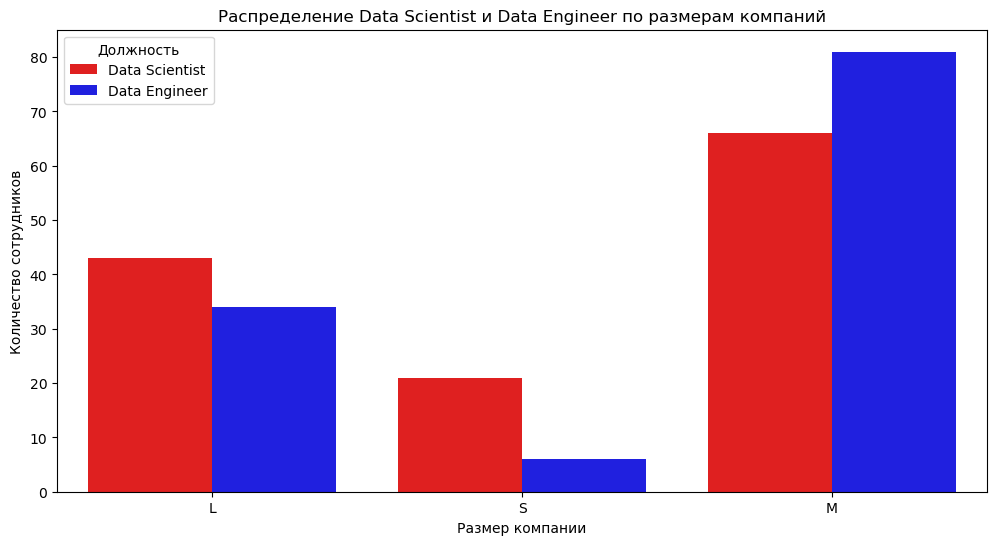

In [398]:
# Фильтрация данных для Data Scientist и Data Engineer
ds_data = df[df['job_title'] == 'Data Scientist']
de_data = df[df['job_title'] == 'Data Engineer']

# Объединение данных по двум должностям
combined_data = pd.concat([ds_data, de_data])

# Построение графика распределения Data Scientist и Data Engineer по размеру компании
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
sns.countplot(
    x='company_size', 
    data=combined_data, 
    hue='job_title', 
    palette=['red', 'blue']
)
plt.title('Распределение Data Scientist и Data Engineer по размерам компаний')
plt.xlabel('Размер компании')
plt.ylabel('Количество сотрудников')
plt.legend(title='Должность')
plt.show()  # Отображение графика


### **Выводы по графику распределения Data Scientist и Data Engineer по размерам компаний**:

1. **Компании категории L (крупные компании)**:
   - В крупных компаниях наблюдается баланс между количеством Data Scientist и Data Engineer. Хотя Data Scientist немного больше, количество Data Engineer также значительно высоко, что может говорить о необходимости как аналитических, так и инженерных навыков в крупных организациях.

2. **Компании категории S (малые компании)**:
   - В малых компаниях количество сотрудников обеих категорий значительно ниже, причем Data Scientist больше, чем Data Engineer. Это может объясняться тем, что малые компании больше нуждаются в анализе данных для принятия решений, чем в создании сложной инженерной инфраструктуры.

3. **Компании категории M (средние компании)**:
   - В средних компаниях Data Engineer составляют большинство, что может свидетельствовать о том, что средние компании сосредоточены на создании и поддержании инфраструктуры данных. Data Scientist также необходимы, но их меньше, чем инженеров данных.

**Причины и гипотезы**:

1. **Крупные компании (L)**:
   - В крупных компаниях присутствует развитая инженерная инфраструктура и одновременно требуются аналитические специалисты для обработки больших объемов данных и построения моделей. Это объясняет сбалансированное распределение сотрудников обеих профессий.
   
2. **Малые компании (S)**:
   - Малые компании часто только начинают строить свою инфраструктуру данных, что объясняет меньшее количество Data Engineer. Тем не менее, наличие Data Scientist помогает им анализировать данные для стратегического принятия решений на ранних этапах роста.

3. **Средние компании (M)**:
   - Средние компании нуждаются в большем количестве Data Engineer, поскольку они активно расширяют свою инфраструктуру данных для дальнейшего роста. Это может быть связано с масштабированием их систем и увеличением объемов данных. Количество Data Scientist меньше, что может свидетельствовать о том, что фокус делается больше на обработку данных и поддержку инфраструктуры.

**Рекомендации**:

1. **Крупные компании (L)**:
   - Крупным компаниям стоит поддерживать баланс между аналитическими и инженерными компетенциями, чтобы обеспечить эффективное использование данных и поддержание инфраструктуры.
   - Важно продолжать найм специалистов обеих профессий для поддержания гибкости в обработке и управлении данными.

2. **Малые компании (S)**:
   - Малые компании могут сосредоточиться на найме Data Scientist для быстрой реализации аналитических проектов, которые могут улучшить их бизнес-показатели на начальных этапах.
   - Постепенно стоит увеличивать найм Data Engineer по мере роста компании и необходимости в создании устойчивой инфраструктуры данных.

3. **Средние компании (M)**:
   - Средним компаниям стоит продолжать расширение штата Data Engineer для поддержки роста инфраструктуры данных. Однако также важно увеличивать количество Data Scientist, чтобы эффективно использовать имеющиеся данные для принятия стратегических решений.
   - Рекомендуется сфокусироваться на интеграции обеих профессий, чтобы аналитики могли работать в связке с инженерами для оптимальной обработки данных.

**Гипотезы**:

- В **крупных компаниях** баланс между Data Scientist и Data Engineer может быть результатом зрелости их инфраструктуры, где требуются как технические специалисты, так и аналитики для интерпретации данных.
- В **малых компаниях** приоритет отдается анализу данных для оперативного принятия решений, тогда как инженерная составляющая развивается медленнее.
- В **средних компаниях** высокое количество Data Engineer указывает на активную стадию роста и необходимость масштабирования систем, что требует усиленной инженерной поддержки.

## **3. Статистический анализ данных**

**Устанавливаем и выводим уровень значимости для статистических тестов, равный 0.05**

In [399]:
# Устанавливаем уровень значимости для статистических тестов
alpha = 0.05

# Вывод уровня значимости
print(f"Значение уровня значимости = {alpha}")


Значение уровня значимости = 0.05


**Выполняем анализ данных, включая проверку гипотез, статистические тесты, оценку корреляций и мультиколлинеарности, а также сравнение групп по различным признакам**

In [400]:
### 1. Анализ данных ###

# Функция для подсчета наблюдений по каждой подгруппе
def count_observations(df, job_title):
    df_filtered = df[df['job_title'] == job_title]  # Фильтрация данных по должности
    variables = ['work_year', 'experience_level', 'employment_type', 'employee_residence', 
                 'remote_ratio', 'company_location', 'company_size']  # Переменные для подсчета
    for var in variables:
        group_counts = df_filtered[var].value_counts()  # Подсчет значений в каждой группе
        print(f"Количество наблюдений по каждой подгруппе для {var}:\n{group_counts}\n")

# Анализ корреляций для закодированных категориальных переменных
def analyze_correlations(df, job_title, target_column, method='kendall'):
    df_filtered = df[df['job_title'] == job_title]
    cols_df = [x for x in df_filtered.columns if df_filtered[x].dtype == 'object']  # Выборка категориальных столбцов
    ord_encoder = OrdinalEncoder()  # Кодировщик
    df_encoded = df_filtered.copy()
    df_encoded[cols_df] = ord_encoder.fit_transform(df_filtered[cols_df])  # Кодирование категориальных признаков
    data_corr = df_encoded.corr(method=method)  # Рассчет корреляции
    return df_encoded, ord_encoder, cols_df, data_corr

# Вывод значимых корреляций
def print_significant_correlations(data_corr, job_title, target_column, threshold=0.2):
    significant_correlations = data_corr[target_column].drop(target_column).sort_values(key=abs, ascending=False)
    print(f'Факторы и их корреляции с {target_column} у {job_title}:')
    print(significant_correlations[abs(significant_correlations) > threshold])  # Вывод значимых корреляций

### 2. Проверка гипотез ###

# Функция для проверки нормальности распределения
def check_normality(label, data, alpha=0.05):
    stat, p_value = stats.shapiro(data)
    if p_value > alpha:
        print(f"{label}: Статистика={stat:.2f}, p-значение={p_value:.18f}. p-значение больше {alpha}, распределение нормальное.")
    else:
        print(f"{label}: Статистика={stat:.2f}, p-значение={p_value:.18f}. p-значение меньше {alpha}, распределение ненормальное.")

# Функция для проверки гипотезы с использованием теста Краскела-Уоллиса
def test_hypothesis_kruskal(data_groups, alpha=0.05):
    stat, p_value = stats.kruskal(*data_groups)
    if p_value > alpha:
        print(f"Статистика={stat:.2f}, p-значение={p_value:.18f}. p-значение больше {alpha}. Принимаем нулевую гипотезу.")
    else:
        print(f"Статистика={stat:.2f}, p-значение={p_value:.18f}. p-значение меньше {alpha}. Отвергаем нулевую гипотезу.")

# Проверка равенства дисперсий
def check_variances(label, data1, data2, alpha=0.05):
    stat, p_value = stats.levene(data1, data2)
    if p_value > alpha:
        print(f"{label}: Статистика={stat:.2f}, p-значение={p_value:.18f}. Дисперсии равны.")
    else:
        print(f"{label}: Статистика={stat:.2f}, p-значение={p_value:.18f}. Дисперсии различаются.")

# Тест хи-квадрат для категориальных данных
def perform_chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2, p_value, contingency_table, expected

# Рассчет стандартизированных остатков
def calculate_standardized_residuals(contingency_table, expected):
    residuals = (contingency_table - expected) / np.sqrt(expected)
    return residuals

### 3. Тесты для парных сравнений ###

# Тест Тьюки
def perform_tukey_test(data, group_labels, alpha=0.05):
    tukey_result = pairwise_tukeyhsd(endog=data, groups=group_labels, alpha=alpha)
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    return tukey_df

# Тест Геймса-Хауэлла
def perform_games_howell_test(data, group_labels, alpha=0.05):
    games_howell_result = pg.pairwise_gameshowell(data=pd.DataFrame({'data': data, 'group': group_labels}), dv='data', between='group')
    return games_howell_result

# Тест Даннетта-Т3
def perform_dunnetts_t3_test(data, group_labels, alpha=0.05):
    df = pd.DataFrame({'data': data, 'group': group_labels})
    dunnetts_t3_result = sp.posthoc_dunn(df, val_col='data', group_col='group', p_adjust='bonferroni')
    return dunnetts_t3_result

### 4. Мультиколлинеарность и коррекции ###

# Рассчет VIF для анализа мультиколлинеарности
def calculate_vif(df):
    X = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Коррекция Бонферрони
def bonferroni_correction(p_value, num_tests, alpha=0.05):
    bonferroni_alpha = alpha / num_tests
    return p_value < bonferroni_alpha

### 5. Рассчет Cramer's V ###

# Рассчет Cramer's V
def calculate_cramers_v(chi2, n, phi2_min):
    return np.sqrt(chi2 / n / phi2_min)

# Полный рассчет Cramer's V
def compute_cramers_v(contingency_table, chi2_stat):
    phi2_min = min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)
    cramers_v_value = calculate_cramers_v(chi2_stat, contingency_table.values.sum(), phi2_min)
    return cramers_v_value

### 6. Сравнение пропорций ###

# Сравнение пропорций двух групп
def compare_proportions(count1, nobs1, count2, nobs2):
    stat, p_value = proportions_ztest([count1, count2], [nobs1, nobs2])
    return stat, p_value


**Вызываем функцию для подсчета количества наблюдений в каждой подгруппе для должности *Data Scientist***

In [401]:
# Вызов функции для подсчета наблюдений по каждой подгруппе для должности 'Data Scientist'
count_observations(df, 'Data Scientist')


Количество наблюдений по каждой подгруппе для work_year:
work_year
2022    65
2021    44
2020    21
Name: count, dtype: int64

Количество наблюдений по каждой подгруппе для experience_level:
experience_level
MI    59
SE    49
EN    22
Name: count, dtype: int64

Количество наблюдений по каждой подгруппе для employment_type:
employment_type
FT    127
PT      2
FL      1
Name: count, dtype: int64

Количество наблюдений по каждой подгруппе для employee_residence:
employee_residence
US    66
GB    11
IN     9
FR     8
DE     6
CA     6
ES     3
BR     2
RU     1
AU     1
JP     1
PL     1
DZ     1
TR     1
RS     1
VN     1
UA     1
CL     1
MX     1
SG     1
HU     1
NG     1
AT     1
IT     1
PH     1
GR     1
CH     1
Name: count, dtype: int64

Количество наблюдений по каждой подгруппе для remote_ratio:
remote_ratio
100    68
0      38
50     24
Name: count, dtype: int64

Количество наблюдений по каждой подгруппе для company_location:
company_location
US    72
GB    11
IN     8
FR     7


Из-за ограниченного числа наблюдений в некоторых подгруппах рекомендуем следующие тесты:

- **Dunnett’s T3**: для признаков `employment_type`, `employee_residence`, `company_location` (недостаток наблюдений в группах).  
- **Games-Howell**: для признаков `work_year`, `experience_level`, `remote_ratio`, `company_size` (достаточное количество наблюдений в группах).

Оба теста не требуют нормального распределения и подходят для неравных дисперсий.

### **3.1 Вопрос №1 - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

**Проверка на нормальность распределения:**

**Нулевая гипотеза (H0):** Распределение зарплат у специалистов Data Scientist в данном году является нормальным.  
**Альтернативная гипотеза (H1):** Распределение зарплат у специалистов Data Scientist в данном году не является нормальным.

Проверим нормальность распределения зарплат по годам с помощью теста Шапиро-Уилка, который эффективен для небольших выборок. Поскольку наша выборка меньше 5000 наблюдений, этот тест подходит для анализа.

**Фильтруем данные для *Data Scientist*, выбираем зарплаты по годам (2020, 2021, 2022) и проверяем нормальность их распределения для каждого года**

In [402]:
from scipy import stats

# Фильтрация данных для Data Scientist
df_ds = df[df['job_title'] == 'Data Scientist']

# Выбор данных о зарплатах по годам для Data Scientist
data_by_year = {year: df_ds[df_ds['work_year'] == year]['salary_in_usd'] for year in [2020, 2021, 2022]}

# Проверка нормальности распределения зарплат для каждого года
normality_results = {year: check_normality(year, data) for year, data in data_by_year.items()}


2020: Статистика=0.59, p-значение=0.000001717291638334. p-значение меньше 0.05, распределение ненормальное.
2021: Статистика=0.96, p-значение=0.107240986916494696. p-значение больше 0.05, распределение нормальное.
2022: Статистика=0.99, p-значение=0.676181234197021697. p-значение больше 0.05, распределение нормальное.


**Проверка равенства дисперсий:**

**Нулевая гипотеза (H0):** Дисперсии зарплат за 2020, 2021 и 2022 годы равны.  
**Альтернативная гипотеза (H1):** Дисперсии зарплат за 2020, 2021 и 2022 годы различаются.  

Проведем тест Левена для проверки равенства дисперсий, который устойчив к отклонениям от нормальности и оценивает равенство дисперсий между группами.

**Выбираем данные о зарплатах по годам для *Data Scientist* и проверяем равенство дисперсий между парами годов (2020 и 2021, 2020 и 2022, 2021 и 2022)**

In [403]:
# Выбор данных о зарплатах по годам для Data Scientist
data_by_year = {year: df_ds[df_ds['work_year'] == year]['salary_in_usd'] for year in [2020, 2021, 2022]}

# Проверка дисперсий между парами годов (2020 vs 2021, 2020 vs 2022, 2021 vs 2022)
comparisons = [(2020, 2021), (2020, 2022), (2021, 2022)]  # Пары для сравнения
for year1, year2 in comparisons:
    check_variances(f'{year1} vs {year2}', data_by_year[year1], data_by_year[year2])


2020 vs 2021: Статистика=0.08, p-значение=0.772932237606241079. Дисперсии равны.
2020 vs 2022: Статистика=0.07, p-значение=0.798298718164674015. Дисперсии равны.
2021 vs 2022: Статистика=1.26, p-значение=0.263857884478352012. Дисперсии равны.


**Воспользуемся тестом Краскела-Уоллиса для анализа изменения зарплат:**

Поскольку зарплаты за 2020 год не имеют нормального распределения, оправдано применение непараметрического теста Краскела-Уоллиса. Этот тест также подходит для анализа смешанных данных, поэтому его можно использовать и для 2021 и 2022 годов, даже если распределения нормальные.

**Нулевая гипотеза (H0):** Медианные зарплаты Data Scientist не изменились с 2020 по 2022 год.  
**Альтернативная гипотеза (H1):** Медианные зарплаты Data Scientist изменились с 2020 по 2022 год.  

**Проверяем гипотезу о равенстве распределений зарплат между 2020, 2021 и 2022 годами с помощью теста Краскела-Уоллиса**

In [404]:
# Проверка гипотезы о равенстве распределений зарплат между годами 2020, 2021 и 2022 с помощью теста Краскела-Уоллиса
test_hypothesis_kruskal([data_2020, data_2021, data_2022])


Статистика=33.06, p-значение=0.000000066245683885. p-значение меньше 0.05. Отвергаем нулевую гипотезу.


**Пост-хок анализа с использованием теста Тьюки:**

Тест Краскела-Уоллиса выявляет различия, но не указывает, между какими конкретно группами. Для этого используется пост-хок анализ, например, тест Тьюки, который помогает определить значимые различия между группами. Тест Тьюки корректирует уровень значимости для множественных сравнений, предотвращая ложноположительные результаты, и его можно применять при условии равенства дисперсий, что было подтверждено ранее.

Результаты пост-хок анализа с тестом Тьюки приведены в таблице, где:

- **group1 и group2**: Группы, между которыми сравниваются зарплаты (в данном случае, годы).
- **meandiff**: Средняя разница зарплат между группами. Положительное значение означает, что зарплата в group2 выше, чем в group1.
- **p-adj**: Скорректированное p-value для оценки статистической значимости.
- **lower и upper**: Границы 95% доверительного интервала. Если интервал не включает 0, различия значимы.
- **reject**: Указывает, отклоняется ли нулевая гипотеза. True — различия значимы, False — нет.

**Выполняем пост-хок анализ с использованием теста Тьюки для сравнения зарплат *Data Scientist* по годам работы и выводим результаты теста**

In [405]:
# Пост-хок анализ: Тест Тьюки для сравнения зарплат по годам работы Data Scientist
tukey_df = perform_tukey_test(df_ds['salary_in_usd'], df_ds['work_year'], alpha=0.05)

# Вывод результатов теста Тьюки
print(tukey_df)


   group1  group2    meandiff   p-adj       lower       upper  reject
0    2020    2021 -15754.7511  0.5592 -52020.0340  20510.5319   False
1    2020    2022  45396.4147  0.0060  11075.9406  79716.8887    True
2    2021    2022  61151.1657  0.0000  34457.9676  87844.3639    True


**Сравнение между 2020 и 2021 годами** показывает, что средняя разница в зарплатах не является статистически значимой (p-adj = 0.5592), так как доверительный интервал включает 0. Это означает, что значительных изменений в зарплатах Data Scientist между этими годами нет.

**Сравнение между 2020 и 2022 годами** показывает статистически значимую разницу (p-adj = 0.0060), где зарплаты в 2022 году были значительно выше, чем в 2020 году. Это подтверждается тем, что доверительный интервал не включает 0.

**Сравнение между 2021 и 2022 годами** также демонстрирует значимые различия (p-adj = 0.0000), с более высокими зарплатами в 2022 году. Доверительный интервал указывает на значительный рост зарплат по сравнению с 2021 годом.

**Вывод**:

Зарплаты Data Scientist оставались относительно стабильными между 2020 и 2021 годами, но в 2022 году наблюдается существенный рост по сравнению с обоими предыдущими годами. Это может свидетельствовать об увеличении спроса на специалистов в этой области или улучшении экономической ситуации в 2022 году.

**P-value в тесте Краскела-Уоллиса** и **скорректированное p-value (p-adj)** в пост-хок анализе с тестом Тьюки имеют разные цели и методы расчета:

**P-value** в тесте Краскела-Уоллиса показывает вероятность получения таких результатов, если нулевая гипотеза (равенство медиан всех групп) верна. Это одно значение для всех групп, и в нашем случае p-value=0.0000000029 указывает на наличие статистически значимых различий между хотя бы двумя группами.

**P-adj** в пост-хок анализе (Тест Тьюки) — это скорректированное p-value для каждой пары групп, учитывающее множественные сравнения. Оно снижает риск ложноположительных результатов за счет контроля общей ошибки первого рода (FWER). P-adj используется для проверки, между какими конкретными группами есть значимые различия.

**Заключение**: 

**p-value** оценивает различия между всеми группами в целом, а **p-adj** корректируется для каждого парного сравнения с учетом множественных тестов. 

### **3.2 Вопрос №2 - Какие факторы влияют на зарплату у специалистов Data Scientist?**

**Проведем корреляционный анализ признаков:**

**Выполняем анализ корреляций для *Data Scientist* с закодированными категориальными переменными и выводим значимые корреляции для зарплаты**

In [406]:
# Анализ корреляций для Data Scientist с закодированными категориальными переменными
df_ds_encoded, ord_encoder, cols_df, data_corr = analyze_correlations(df, 'Data Scientist', 'salary_in_usd')

# Вывод значимых корреляций для зарплаты Data Scientist
print_significant_correlations(data_corr, 'Data Scientist', 'salary_in_usd')


Факторы и их корреляции с salary_in_usd у Data Scientist:
experience_level      0.484706
employee_residence    0.397024
company_location      0.394188
work_year             0.364126
Name: salary_in_usd, dtype: float64


**Извлекаем столбец корреляций с зарплатой (`'salary_in_usd'`) из матрицы корреляций**

In [407]:
# Извлечение столбца корреляций с зарплатой 'salary_in_usd' из матрицы корреляций
data_corr['salary_in_usd']


work_year             0.364126
experience_level      0.484706
employment_type      -0.061500
job_title                  NaN
salary_in_usd         1.000000
employee_residence    0.397024
remote_ratio          0.114137
company_location      0.394188
company_size         -0.112314
Name: salary_in_usd, dtype: float64

### **Выводы**:

1. **Высокая корреляция**:
   - **salary_in_usd** наиболее сильно коррелирует с **experience_level** (0.48) и **work_year** (0.36). Это указывает на то, что с ростом уровня опыта и с течением времени зарплаты Data Scientist увеличиваются.

2. **Низкая или отрицательная корреляция**:
   - **employment_type** (-0.06) и **company_size** (-0.11) имеют слабую отрицательную корреляцию с зарплатой, что говорит о том, что тип занятости и размер компании не оказывают значительного влияния на уровень заработной платы.
   - **remote_ratio** (0.11) также имеет слабую положительную корреляцию с зарплатой, что указывает на незначительное влияние удаленной работы на уровень зарплат.

3. **Отсутствие данных**:
   - Для **job_title** данные о корреляции отсутствуют (NaN), что может указывать на недостаток информации или её отсутствие в наборе данных.

**Причины и гипотезы**:

1. **Зависимость зарплат от опыта**:
   - Сильная корреляция с уровнем опыта объяснима: более опытные специалисты получают более высокие зарплаты, поскольку они приносят больше ценности компаниям.
   
2. **Незначительное влияние типа занятости и размера компании**:
   - Отрицательная корреляция с размером компании и типом занятости может быть связана с тем, что зарплаты в разных типах занятости или в компаниях разных размеров варьируются незначительно.

3. **Remote_ratio и зарплаты**:
   - Слабая корреляция с долей удаленной работы может указывать на то, что удаленная занятость не сильно влияет на уровень зарплат, но может быть некоторым фактором для определенных позиций.

**Рекомендации**:

1. **Фокус на уровне опыта**:
   - Компаниям стоит уделять внимание опытным специалистам, поскольку опыт коррелирует с более высокими зарплатами, что может отражать повышенную ценность этих сотрудников.

2. **Анализ влияния других факторов**:
   - Провести дополнительные исследования влияния таких факторов, как должность (**job_title**) и другие возможные переменные, которые могут объяснять уровень зарплат.

3. **Удаленная работа**:
   - Компаниям следует продолжать предлагать гибкие условия работы, так как удаленная занятость, хотя и не сильно коррелирует с зарплатой, остается актуальной для сотрудников.

Тест **Games-Howell** — это пост-хок тест для сравнения средних между группами с неравными дисперсиями и/или разным размером выборок. Он является более гибкой версией теста Тьюки, учитывая различия в дисперсиях.

Описание столбцов теста Games-Howell:

- **A** и **B**: Группы, которые сравниваются (например, годы).
- **mean(A)** и **mean(B)**: Средние значения для групп A и B.
- **diff**: Разница между средними значениями (mean(A) - mean(B)).
- **se**: Стандартная ошибка разницы средних, показывающая точность оценки.
- **T**: Статистика теста, измеряющая значимость различий между группами.
- **df**: Степени свободы, указывающие на надежность оценки.
- **pval**: P-значение, определяющее статистическую значимость различий.
- **hedges**: Коэффициент Хеджеса, измеряющий размер эффекта между группами.

**Выполняем тест Games-Howell для переменных, влияющих на зарплату *Data Scientist*, и выводим результаты с маппингом категорий обратно в исходные значения**

In [408]:
# Анализ корреляций для Data Scientist
df_ds_encoded, ord_encoder, cols_df, data_corr = analyze_correlations(df, 'Data Scientist', 'salary_in_usd')

# Переменные для проведения теста Games-Howell
variables = ['work_year', 'experience_level', 'remote_ratio', 'company_size']

# Создание словаря с маппингом категорий из OrdinalEncoder
category_mappings = {var: list(ord_encoder.categories_[i]) for i, var in enumerate(cols_df)}

# Цикл по переменным для проведения теста Games-Howell
for var in variables:
    # Выполнение теста Games-Howell для каждой переменной
    games_howell_df = perform_games_howell_test(data=df_ds_encoded['salary_in_usd'], group_labels=df_ds_encoded[var], alpha=0.05)
    
    # Если переменная закодирована, выполняется маппинг категорий обратно
    if var in category_mappings:
        games_howell_df['A'] = games_howell_df['A'].map(lambda x: category_mappings[var][int(x)])  # Маппинг первой группы
        games_howell_df['B'] = games_howell_df['B'].map(lambda x: category_mappings[var][int(x)])  # Маппинг второй группы
    
    # Вывод результатов теста Games-Howell
    print(f'Результаты теста Games-Howell для {var}:')  # Перефразировано для ясности
    print(games_howell_df.to_string(index=False))  # Вывод результата в формате строки
    print("\n")


Результаты теста Games-Howell для work_year:
   A    B      mean(A)       mean(B)          diff           se         T         df         pval    hedges
2020 2021 85970.523810  70215.772727  15754.751082 19067.537291  0.826260  26.228351 6.903558e-01  0.261636
2020 2022 85970.523810 131366.938462 -45396.414652 19070.472055 -2.380456  26.334600 6.211555e-02 -0.715834
2021 2022 70215.772727 131366.938462 -61151.165734  9779.658265 -6.252894 102.925643 2.780489e-08 -1.167297


Результаты теста Games-Howell для experience_level:
 A  B      mean(A)       mean(B)          diff           se         T        df         pval    hedges
EN MI 55330.909091  81891.762712 -26560.853621  9066.823098 -2.929455 57.084597 1.331536e-02 -0.603698
EN SE 55330.909091 150710.857143 -95379.948052 11186.845528 -8.526081 68.192316 7.149725e-12 -1.707967
MI SE 81891.762712 150710.857143 -68819.094431 10892.362292 -6.318106 87.600949 3.200088e-08 -1.244515


Результаты теста Games-Howell для remote_ratio:
 A   B 

### **Выводы**:

1. **work_year**:
   - **2020 vs 2021**: Разница в средних зарплатах между 2020 и 2021 годами не является значимой (p = 0.69).
   - **2020 vs 2022**: Разница значительна (p = 0.06), но на грани статистической значимости. Зарплаты в 2022 году выше, чем в 2020 году.
   - **2021 vs 2022**: Разница значительна (p < 0.00001), с существенным ростом зарплат в 2022 году по сравнению с 2021.

2. **experience_level**:
   - **EN vs MI**: Разница значима (p = 0.013), с более высокими зарплатами у специалистов уровня MI.
   - **EN vs SE**: Очень значительная разница (p < 0.00001), зарплаты у специалистов уровня SE гораздо выше.
   - **MI vs SE**: Разница также значительна (p < 0.00001), с более высокими зарплатами у уровня SE по сравнению с MI.

3. **remote_ratio**:
   - **0% vs 50%**: Разница не является значимой (p = 0.11), хотя зарплаты при частичной удаленной работе (50%) немного ниже.
   - **0% vs 100%**: Разница незначительна (p = 0.34), зарплаты при полной удаленной работе чуть выше.
   - **50% vs 100%**: Разница значительна (p = 0.0009), зарплаты при полной удаленной работе значительно выше, чем при частичной.

4. **company_size**:
   - **L vs M**: Разница не является значимой (p = 0.39), зарплаты в крупных и средних компаниях близки.
   - **L vs S**: Разница значительна (p = 0.0009), зарплаты в крупных компаниях значительно выше, чем в малых.
   - **M vs S**: Разница значительна (p < 0.00001), зарплаты в средних компаниях значительно выше, чем в малых.

**Причины и гипотезы**:

1. **Рост зарплат с годами (work_year)**:
   - С 2021 на 2022 год наблюдается значительный рост зарплат, что может быть связано с увеличением спроса на специалистов Data Science и развитием технологий.

2. **Влияние уровня опыта (experience_level)**:
   - Зарплаты значительно растут с повышением уровня опыта, особенно на уровне Senior (SE), что подтверждает высокую ценность опыта и квалификации.

3. **Удаленная работа (remote_ratio)**:
   - Полностью удаленная работа коррелирует с более высокими зарплатами, особенно по сравнению с частичной удаленкой. Это может объясняться тем, что компании готовы платить больше за гибкие условия работы.

4. **Размер компании (company_size)**:
   - В малых компаниях зарплаты значительно ниже, чем в средних и крупных. Это может быть связано с меньшими ресурсами и ограниченными возможностями для выплаты высоких зарплат.

**Рекомендации**:

1. **Увеличение зарплат в малых компаниях**:
   - Малые компании должны рассмотреть возможность повышения зарплат, чтобы конкурировать за специалистов, особенно учитывая значительные различия с крупными и средними компаниями.

2. **Фокус на удаленную работу**:
   - Компаниям следует предлагать полностью удаленные условия для привлечения сотрудников, так как это связано с более высокими зарплатами и гибкими условиями работы.

3. **Поддержка роста зарплат с повышением уровня опыта**:
   - Компании должны предоставлять возможности для профессионального роста и повышения квалификации сотрудников, чтобы мотивировать и удерживать опытных специалистов, особенно на уровне Senior.

4. **Мониторинг изменений зарплат**:
   - Регулярно анализировать изменения зарплат по годам, чтобы своевременно адаптировать компенсационные пакеты в условиях растущего спроса на специалистов.

Тест **Dunnett’s T3** — это метод для множественных сравнений средних, используемый при нарушении предположения о равенстве дисперсий. Он является непараметрическим аналогом теста Тьюки и подходит для данных с неоднородными дисперсиями или неравными размерами выборок.

**Выполняем тест Dunnett’s T3 для переменных, влияющих на зарплату *Data Scientist*, маппируем закодированные категории обратно в исходные значения и выводим отфильтрованные результаты теста**

In [409]:
# Анализ корреляций для Data Scientist
df_ds_encoded, ord_encoder, cols_df, data_corr = analyze_correlations(df, 'Data Scientist', 'salary_in_usd')

# Переменные для проведения теста Dunnett’s T3
variables = ['employment_type', 'employee_residence', 'company_location']

# Создание словаря с маппингом категорий из OrdinalEncoder
category_mappings = {var: list(ord_encoder.categories_[i]) for i, var in enumerate(cols_df)}

# Цикл по переменным для проведения теста Dunnett’s T3
for var in variables:
    # Выполнение теста Dunnett’s T3 для каждой переменной
    dunnetts_t3_df = perform_dunnetts_t3_test(data=df_ds_encoded['salary_in_usd'], group_labels=df_ds_encoded[var], alpha=0.05)
    
    # Если переменная закодирована, выполняется маппинг категорий обратно
    if var in category_mappings:
        dunnetts_t3_df.index = dunnetts_t3_df.index.map(lambda x: category_mappings[var][int(x)])  # Маппинг индексов
        dunnetts_t3_df.columns = dunnetts_t3_df.columns.map(lambda x: category_mappings[var][int(x)])  # Маппинг столбцов
    
    # Фильтрация и вывод результатов теста Dunnett’s T3
    print(f'Результаты теста Dunnett’s T3 для {var}:')
    dunnetts_t3_df_filtered = dunnetts_t3_df.dropna(how='all')  # Удаление строк, где все значения NaN
    if not dunnetts_t3_df_filtered.empty:  # Проверка на наличие непустых данных
        print(dunnetts_t3_df_filtered.to_string())  # Вывод отфильтрованных данных
    print("\n")


Результаты теста Dunnett’s T3 для employment_type:
     FL        FT        PT
FL  1.0  1.000000  1.000000
FT  1.0  1.000000  0.921531
PT  1.0  0.921531  1.000000


Результаты теста Dunnett’s T3 для employee_residence:
     AT   AU   BR   CA   CH   CL   DE   DZ        ES        FR   GB   GR   HU            IN   IT   JP   MX   NG   PH   PL   RS   RU   SG   TR   UA            US   VN
AT  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.000000  1.0  1.0  1.0  1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000e+00  1.0
AU  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.000000  1.0  1.0  1.0  1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000e+00  1.0
BR  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.000000  1.0  1.0  1.0  1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000e+00  1.0
CA  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.000000  1.0  1.0  1.0  1.000000e+00  1.0  1.0  1.0  1.0  1.0 

**Интерпретация матрицы p-значений (парные сравнения):**

Таблица отображает p-значения для каждого сравнения между категориями переменной. Каждая ячейка показывает p-значение для сравнения двух групп. Например, значение на пересечении строк "FT" и "PT" — это p-значение для сравнения полной занятости (FT) с частичной (PT).

Если p-значение меньше 0.05, различия между группами значимы. Если больше, различий нет.

### **Выводы**:

1. **employment_type**:
   - Нет значимых различий в зарплатах между различными типами занятости (FL, FT, PT), так как все p-значения превышают 0.05. Это свидетельствует о том, что форма занятости (полная, частичная, контрактная) не оказывает значимого влияния на зарплаты сотрудников.

2. **employee_residence**:
   - Значимых различий в зарплатах между большинством стран нет, за исключением некоторых пар, например, **US и IN**, **US и FR**, где p-значения меньше 0.05. Это говорит о том, что зарплаты в США значительно отличаются от некоторых других стран, таких как Индия и Франция.
   
3. **company_location**:
   - Большинство пар стран не имеют значимых различий в зарплатах, за исключением некоторых сравнений, таких как **US и FR**, **US и IN**, где p-значения меньше 0.05. Это указывает на то, что зарплаты в США могут быть выше по сравнению с Францией и Индией.

**Причины и гипотезы**:

1. **employment_type**:
   - Отсутствие значимых различий между типами занятости может свидетельствовать о том, что зарплаты сотрудников, работающих на разных условиях (полная или частичная занятость), достаточно схожи в данной отрасли. Это может быть связано с тем, что работодатели предлагают конкурентоспособные зарплаты вне зависимости от типа занятости.

2. **employee_residence**:
   - Различия в зарплатах между странами, особенно США и другими странами, могут быть связаны с экономическими факторами, уровнем жизни и спросом на специалистов в данных странах. Зарплаты в США традиционно выше, что может объяснять значимые различия с Индией и Францией.

3. **company_location**:
   - Различия в зарплатах, зависящие от местоположения компаний, также могут быть связаны с различиями в экономике и уровне жизни между странами. Зарплаты в компаниях, расположенных в США, выше, что объясняется более высоким спросом на специалистов и конкурентоспособной экономикой.

**Рекомендации**:

1. **Для компаний с различными типами занятости**:
   - Несмотря на отсутствие значимых различий в зарплатах, компаниям рекомендуется продолжать поддерживать конкурентоспособные условия для всех типов занятости, чтобы привлекать как штатных сотрудников, так и фрилансеров.

2. **Для компаний, работающих в международных локациях**:
   - Компаниям в странах с более низкими зарплатами (например, Индия, Франция) следует учитывать международные стандарты и рассматривать возможность повышения зарплат для привлечения талантливых специалистов.

3. **Международные компании**:
   - Для компаний, имеющих офисы в разных странах, важно адаптировать компенсационные пакеты в зависимости от региона, чтобы обеспечить конкурентоспособность и удовлетворенность сотрудников на глобальном уровне.

Для проверки мультиколлинеарности можно использовать анализ VIF, который показывает степень корреляции между независимыми переменными в регрессионной модели.

**Удаляем колонку с зарплатой, рассчитываем VIF для оставшихся признаков для выявления мультиколлинеарности, и выводим результаты расчета VIF**

In [410]:
# Удаление колонки с зарплатой для расчета VIF (исключаем зависимую переменную)
df_for_vif = df_ds_encoded.drop(columns=['salary_in_usd'])

# Рассчет VIF для выявления мультиколлинеарности среди оставшихся признаков
vif_data = calculate_vif(df_for_vif)

# Вывод данных по VIF для всех признаков
print(vif_data)


              feature           VIF
0               const  9.141421e+06
1           work_year  1.224353e+00
2    experience_level  1.278908e+00
3     employment_type  1.126605e+00
4           job_title           NaN
5  employee_residence  5.832284e+00
6        remote_ratio  1.054485e+00
7    company_location  5.962468e+00
8        company_size  1.035277e+00


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


### **Выводы**:

1. **Высокий VIF для константы**: Значение VIF для константы чрезвычайно велико (9,141,421), что указывает на проблемы с мультиколлинеарностью или неправильную интерпретацию модели.
2. **Умеренно высокий VIF для `employee_residence` (5.83) и `company_location` (5.96)**: Это может свидетельствовать о значительной корреляции между этими признаками, что может вызвать проблемы мультиколлинеарности в модели.
3. **Низкие значения VIF для остальных признаков**: Для остальных переменных значения VIF близки к 1, что указывает на отсутствие сильной мультиколлинеарности между ними.

**Причины и гипотезы**:

1. **Взаимосвязь между `employee_residence` и `company_location`**: Вероятно, существует корреляция между местом проживания сотрудников и расположением компании, что объясняет высокие значения VIF.
2. **Отсутствие значений для `job_title`**: Признак `job_title` имеет значение NaN, что может указывать на недостающие данные или на невозможность расчета VIF для этой переменной.

**Рекомендации**:

1. **Проверка и коррекция мультиколлинеарности**: Следует пересмотреть признаки `employee_residence` и `company_location` для возможного удаления или трансформации, чтобы снизить мультиколлинеарность.
2. **Проверка константы в модели**: Необходимо проверить правильность включения константы в модель, поскольку её высокий VIF может быть вызван неверной настройкой модели.
3. **Обработка пропущенных значений в `job_title`**: Нужно выяснить причину отсутствия данных для `job_title` и скорректировать их, чтобы включить в анализ.

**Ответ**:

На зарплату Data Scientist наибольшее влияние оказывают уровень опыта (**experience_level**), место жительства (**employee_residence**), местоположение компании (**company_location**) и год работы (**work_year**).

### **3.3 Вопрос №3 - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

**Проверка на нормальность распределения:**

**Нулевая гипотеза (H0):** Средние зарплаты специалистов Data Scientist не различаются в компаниях различных размеров.

**Альтернативная гипотеза (H1):** Существует хотя бы одна пара групп, в которых средние зарплаты специалистов Data Scientist статистически значимо различаются.

**Фильтруем данные для *Data Scientist*, извлекаем зарплаты по размерам компаний (малые, средние, крупные) и проверяем нормальность распределений зарплат для каждой категории размера компании**

In [411]:
# Фильтрация данных для Data Scientist
data_scientists = df[df['job_title'] == 'Data Scientist']

# Извлечение данных о зарплатах по размерам компаний (Small, Medium, Large)
company_size_salary = {
    'Small': data_scientists[data_scientists['company_size'] == 'S']['salary_in_usd'],
    'Medium': data_scientists[data_scientists['company_size'] == 'M']['salary_in_usd'],
    'Large': data_scientists[data_scientists['company_size'] == 'L']['salary_in_usd']
}

# Проверка нормальности распределений зарплат для каждой категории размера компании
normality_results = {size: check_normality(size, salary) for size, salary in company_size_salary.items()}


Small: Статистика=0.94, p-значение=0.189028025063010863. p-значение больше 0.05, распределение нормальное.
Medium: Статистика=0.99, p-значение=0.896507235431620031. p-значение больше 0.05, распределение нормальное.
Large: Статистика=0.84, p-значение=0.000038677400886092. p-значение меньше 0.05, распределение ненормальное.


**Проверка равенства дисперсий**

Для проверки равенства дисперсий зарплат Data Scientist в компаниях разных размеров можно применить тест Левена. Он проверяет гипотезу о равенстве дисперсий между группами и устойчив к отклонениям от нормальности, что делает его подходящим для наших данных.

**Нулевая гипотеза (H0):** Дисперсии зарплат специалистов Data Scientist равны в компаниях различных размеров. Это предполагает, что нет статистически значимых различий в изменчивости зарплат между малыми, средними и крупными компаниями. 

**Альтернативная гипотеза (H1):** Дисперсии зарплат специалистов Data Scientist не равны хотя бы в одной из групп компаний определенного размера. Это означает, что существуют статистически значимые различия в изменчивости зарплат между малыми, средними или крупными компаниями.

**Извлекаем данные о зарплатах *Data Scientist* по размерам компаний (малые, средние, крупные) и проверяем равенство дисперсий зарплат между каждой парой размеров компаний**

In [412]:
# Извлечение данных о зарплатах Data Scientist по размерам компаний (Small, Medium, Large)
ds_company_size_salary = {
    'Small': df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'S')]['salary_in_usd'],
    'Medium': df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'M')]['salary_in_usd'],
    'Large': df[(df['job_title'] == 'Data Scientist') & (df['company_size'] == 'L')]['salary_in_usd']
}

# Проверка дисперсий между парами размеров компаний
comparisons = [('Малые vs Средние компании', 'Small', 'Medium'), 
               ('Малые vs Крупные компании', 'Small', 'Large'), 
               ('Средние vs Крупные компании', 'Medium', 'Large')]

# Цикл для проведения тестов проверки дисперсий для каждой пары компаний
for label, size1, size2 in comparisons:
    check_variances(label, ds_company_size_salary[size1], ds_company_size_salary[size2])


Малые vs Средние компании: Статистика=5.81, p-значение=0.018119741686887063. Дисперсии различаются.
Малые vs Крупные компании: Статистика=5.03, p-значение=0.028550609659232149. Дисперсии различаются.
Средние vs Крупные компании: Статистика=0.94, p-значение=0.334421403916679960. Дисперсии равны.


Из-за неравенства дисперсий результаты теста Тьюки могут быть некорректны, поэтому рекомендуется использовать альтернативы, например, тест Games-Howell.

**Выполняем тест Games-Howell для анализа различий в зарплатах *Data Scientist* в зависимости от размера компании, преобразуя закодированные значения обратно в категории и выводя результаты**

In [413]:
# Анализ корреляций для Data Scientist
df_ds_encoded, ord_encoder, cols_df, data_corr = analyze_correlations(df, 'Data Scientist', 'salary_in_usd')

# Переменная для проведения теста Games-Howell
variable = 'company_size'

# Создание маппинга категорий для закодированных переменных
category_mappings = {var: list(ord_encoder.categories_[i]) for i, var in enumerate(cols_df)}

# Выполнение теста Games-Howell для переменной company_size
games_howell_df = perform_games_howell_test(data=df_ds_encoded['salary_in_usd'], group_labels=df_ds_encoded[variable], alpha=0.05)

# Преобразование закодированных значений обратно в категории
if variable in category_mappings:
    games_howell_df[['A', 'B']] = games_howell_df[['A', 'B']].applymap(lambda x: category_mappings[variable][int(x)])

# Вывод результатов теста Games-Howell
print(f'Результаты теста Games-Howell для {variable}:')
print(games_howell_df.to_string(index=False))


Результаты теста Games-Howell для company_size:
A B       mean(A)       mean(B)          diff           se         T        df         pval    hedges
L M 102743.418605 120080.575758 -17337.157153 13149.207193 -1.318494 73.559379 3.895313e-01 -0.271011
L S 102743.418605  51925.761905  50817.656700 13316.666994  3.816094 61.804255 9.110034e-04  0.794628
M S 120080.575758  51925.761905  68154.813853 10032.263250  6.793563 58.343069 1.895622e-08  1.303028


C:\Users\Администратор\AppData\Local\Temp\ipykernel_5976\295520608.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  games_howell_df[['A', 'B']] = games_howell_df[['A', 'B']].applymap(lambda x: category_mappings[variable][int(x)])


### **Выводы**:

1. **Сравнение L и M (Крупные и средние компании)**:
   - Разница в зарплатах между крупными и средними компаниями (-17,337 USD) не является статистически значимой (p = 0.389). Это указывает на то, что зарплаты Data Scientist в крупных и средних компаниях практически одинаковы.

2. **Сравнение L и S (Крупные и малые компании)**:
   - Разница в зарплатах между крупными и малыми компаниями значительна (p = 0.0009), с зарплатами в крупных компаниях на 50,818 USD выше. Это говорит о том, что Data Scientist в крупных компаниях получают существенно больше, чем в малых.

3. **Сравнение M и S (Средние и малые компании)**:
   - Разница в зарплатах между средними и малыми компаниями также значительна (p < 0.00001), с зарплатами в средних компаниях на 68,155 USD выше. Это подтверждает, что Data Scientist в малых компаниях получают значительно меньше, чем в средних и крупных.

**Причины и гипотезы**:

1. **Малые компании** могут не иметь достаточных ресурсов для выплаты высоких зарплат, что объясняет значительную разницу по сравнению с крупными и средними компаниями.
2. **Отсутствие значимых различий между крупными и средними компаниями** может свидетельствовать о схожих возможностях и структурах оплаты труда в этих типах организаций.

**Рекомендации**:

1. **Малым компаниям** следует пересмотреть свои компенсационные пакеты, чтобы оставаться конкурентоспособными на рынке труда, либо предложить другие преимущества, такие как гибкий график или возможность карьерного роста.
2. **Крупным и средним компаниям** рекомендуется поддерживать текущие уровни зарплат, чтобы сохранять мотивацию сотрудников и привлекать таланты.
3. **Компании всех размеров** могут использовать данные о разнице в зарплатах для формирования конкурентных предложений на рынке труда, учитывая размер компании и доступные ресурсы.

**Ответ**  

**Крупные vs Средние компании:** Различий в зарплатах нет.  
**Крупные vs Малые компании:** Зарплаты в крупных компаниях значительно выше.  
**Средние vs Малые компании:** Зарплаты в средних компаниях значительно выше. 

### **3.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**

Для анализа связи между должностями Data Scientist, Data Engineer и размером компании (L, M, S) можно применить статистические тесты для проверки гипотез.

**Нулевая гипотеза (H0):** Нет взаимосвязи между должностью (Data Scientist или Data Engineer) и размером компании (L, M, S). Это означает, что распределение должностей Data Scientist и Data Engineer одинаково независимо от размера компании.

**Альтернативная гипотеза (H1):** Существует взаимосвязь между должностью (Data Scientist или Data Engineer) и размером компании (L, M, S). Это означает, что распределение должностей Data Scientist и Data Engineer различается в зависимости от размера компании.

Для проверки гипотез можно использовать хи-квадрат тест независимости, чтобы выявить статистически значимую связь между категориальными переменными — должностью и размером компании.

**Проводим хи-квадрат тест для проверки зависимости между должностью (*Data Scientist* и *Data Engineer*) и размером компании, выводя таблицу сопряжённости и результаты теста**

In [414]:
# Фильтрация данных по должностям Data Scientist и Data Engineer
filtered_df = df[df['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Создание таблицы сопряжённости для должностей и размера компании
contingency_table = pd.crosstab(filtered_df['job_title'], filtered_df['company_size'])
print(contingency_table)

# Выполнение хи-квадрат теста для проверки зависимости между должностью и размером компании
chi2, p_value, contingency_table, expected = perform_chi_square_test(filtered_df, 'job_title', 'company_size')

# Вывод результатов хи-квадрат теста
print(f"Статистика хи-квадрат: {chi2}, p-значение: {p_value}")

# Проверка статистической значимости p-значения
if p_value < 0.05:
    print("Отклоняем нулевую гипотезу: есть статистически значимая взаимосвязь между должностью и размером компании.")
else:
    print("Принимаем нулевую гипотезу: нет статистически значимой взаимосвязи между должностью и размером компании.")


company_size     L   M   S
job_title                 
Data Engineer   34  81   6
Data Scientist  43  66  21
Статистика хи-квадрат: 10.606821592417818, p-значение: 0.004974597599284174
Отклоняем нулевую гипотезу: есть статистически значимая взаимосвязь между должностью и размером компании.


### **Выводы**:

- Результаты хи-квадрат теста (p = 0.00497) показывают наличие статистически значимой взаимосвязи между должностью (Data Engineer и Data Scientist) и размером компании (L, M, S). Это означает, что распределение должностей зависит от размера компании.

**Причины и гипотезы**:

- В крупных компаниях (L) большее количество вакансий для Data Scientist, что может свидетельствовать о потребности в аналитиках данных для управления большими объемами данных.
- В малых компаниях (S) наблюдается больше вакансий для Data Scientist, чем для Data Engineer, что может указывать на начальную стадию построения аналитических процессов и меньшее внимание к инфраструктуре данных.
- Средние компании (M) имеют сбалансированное распределение между Data Engineer и Data Scientist, что может быть связано с необходимостью как в аналитике, так и в поддержке инфраструктуры данных.

**Рекомендации**:

1. **Крупным компаниям** следует продолжать фокусироваться на найме Data Scientist для поддержки расширенных аналитических задач.
2. **Малым компаниям** рекомендуется уделять больше внимания найму Data Engineer для создания и поддержки инфраструктуры данных.
3. **Средним компаниям** важно поддерживать баланс между специалистами, чтобы эффективно решать задачи по анализу и обработке данных.

После установления связи с помощью хи-квадрат теста, следующий шаг — анализ стандартизированных остатков. Этот анализ помогает выявить, какие комбинации должностей и размеров компаний вносят наибольший вклад в общую статистику. Значительные остатки указывают на отклонения от ожидаемых значений в этих категориях.

**Вычисляем и выводим стандартизированные остатки на основе таблицы сопряжённости и ожидаемых значений**

In [415]:
# Рассчет стандартизированных остатков на основе таблицы сопряжённости и ожидаемых значений
residuals = calculate_standardized_residuals(contingency_table, expected)

# Вывод стандартизированных остатков
print(residuals)


company_size           L         M         S
job_title                                   
Data Engineer  -0.512020  1.204007 -1.944679
Data Scientist  0.493978 -1.161582  1.876156


### **Выводы**:

1. **Data Engineer**:
   - В малых компаниях (S) наблюдается отрицательный значительный остаток (-1.94), что указывает на меньшее количество Data Engineer, чем ожидалось.
   - В средних компаниях (M) положительный остаток (1.20) предполагает большее количество Data Engineer, чем ожидалось.

2. **Data Scientist**:
   - В малых компаниях (S) положительный значительный остаток (1.88) показывает, что Data Scientist больше, чем ожидалось.
   - В средних компаниях (M) отрицательный остаток (-1.16) свидетельствует о том, что Data Scientist меньше, чем ожидалось.

**Причины и гипотезы**:

1. Малые компании чаще нанимают Data Scientist, чем Data Engineer, возможно, из-за фокуса на анализ данных, а не на создание инфраструктуры.
2. Средние компании предпочитают нанимать больше Data Engineer, вероятно, для поддержки развивающейся инфраструктуры данных.

**Рекомендации**:

1. **Малым компаниям** стоит уделить внимание найму Data Engineer для укрепления инфраструктуры данных.
2. **Средним компаниям** рекомендуется увеличить найм Data Scientist для поддержания баланса между аналитикой и инженерией данных.

Для более глубокого анализа различий в пропорциях *Data Scientist* и *Data Engineer* внутри каждой категории размера компании используется Z-тест для сравнения пропорций. Этот тест помогает оценить различия между пропорциями двух должностей и выявить статистически значимые отличия, если они имеются.

**Упрощаем расчет и вывод пропорций для сравнения количества *Data Scientist* и *Data Engineer* в компаниях разных размеров (малые, средние и крупные), выводим результаты z-теста и p-значений для каждой группы**

In [416]:
# Функция для упрощения расчета и вывода пропорций
def calculate_and_print_proportions(company_size, contingency_table):
    count_ds = contingency_table.loc['Data Scientist', company_size]  # Количество Data Scientist в компаниях данного размера
    count_de = contingency_table.loc['Data Engineer', company_size]  # Количество Data Engineer в компаниях данного размера
    nobs = contingency_table[company_size].sum()  # Общее количество сотрудников в компаниях данного размера
    
    # Сравнение пропорций
    stat, p_value = compare_proportions(count_ds, nobs, count_de, nobs)
    
    # Вывод результатов
    print(f"{company_size} компании:", f"z = {stat:.4f}, p-значение = {p_value:.4f}")

# Выполнение расчетов и выводов для всех типов компаний
for size in ['S', 'M', 'L']:
    calculate_and_print_proportions(size, contingency_table)


S компании: z = 4.0825, p-значение = 0.0000
M компании: z = -1.7496, p-значение = 0.0802
L компании: z = 1.4505, p-значение = 0.1469


### **Выводы**:

1. **Малые компании (S)**: 
   - Z-тест показывает статистически значимое различие между пропорциями Data Scientist и Data Engineer (p = 0.0000), что указывает на то, что в малых компаниях значительно больше Data Scientist, чем Data Engineer.
   
2. **Средние компании (M)**:
   - Различия между пропорциями Data Scientist и Data Engineer не являются статистически значимыми (p = 0.0802), что говорит о том, что распределение специалистов в средних компаниях сбалансировано.

3. **Крупные компании (L)**:
   - Различия также не являются значимыми (p = 0.1469), что указывает на близкие пропорции Data Scientist и Data Engineer в крупных компаниях.

**Причины и гипотезы**:

1. Малые компании, вероятно, отдают предпочтение Data Scientist, так как фокусируются на аналитике данных для решения бизнес-задач.
2. В средних и крупных компаниях распределение между Data Scientist и Data Engineer более сбалансировано, так как они нуждаются как в аналитиках, так и в инженерах данных для поддержания инфраструктуры.

**Рекомендации**:

1. **Малым компаниям** рекомендуется рассмотреть увеличение найма Data Engineer для создания и поддержки эффективной инфраструктуры данных.
2. **Средним и крупным компаниям** следует продолжать поддерживать баланс между Data Scientist и Data Engineer для обеспечения эффективной работы с данными на всех уровнях.

При множественных тестах возрастает риск ложноположительных результатов. Чтобы его снизить, применяется коррекция Бонферрони, которая корректирует уровень значимости, предотвращая случайные значимые результаты и повышая надежность выводов.

**Проверяем гипотезу с учетом коррекции Бонферрони и выводим сообщение о принятии или отклонении нулевой гипотезы**

In [417]:
# Проверка гипотезы после коррекции Бонферрони
result_message = "Отвергаем нулевую гипотезу после коррекции Бонферрони" if bonferroni_correction(p_value, num_tests=3, alpha=0.05) else "Принимаем нулевую гипотезу после коррекции Бонферрони"

# Вывод результата
print(result_message)


Отвергаем нулевую гипотезу после коррекции Бонферрони


### **Выводы**:

После применения коррекции Бонферрони нулевая гипотеза отвергнута, что указывает на наличие статистически значимых различий между анализируемыми группами, несмотря на применение строгой коррекции.

**Причины и гипотезы**:

Коррекция Бонферрони уменьшает вероятность ложноположительных результатов, поэтому значимые различия между группами подтверждаются с большей уверенностью. Это может свидетельствовать о реальных различиях между должностями, зарплатами или другими факторами, которые были проверены.

**Рекомендации**:

1. Продолжить дальнейший анализ выявленных различий для более точного понимания их причин.
2. Учитывать скорректированные выводы при принятии решений, поскольку они имеют более высокую степень достоверности.
3. При необходимости использовать дополнительные методы анализа для подтверждения результатов.

Для оценки силы связи между должностями и размером компании используется тест Крамера. Он количественно определяет степень взаимосвязи между категориальными переменными. Значение Cramer's V покажет силу связи и добавит контекст к выводам из хи-квадрат теста.

**Вычисляем и выводим значение Cramer's V для оценки силы связи между должностью и размером компании на основе таблицы сопряжённости и хи-квадрат статистики**

In [418]:
# Рассчет значения Cramer's V на основе таблицы сопряжённости и статистики хи-квадрат
cramers_v_value = compute_cramers_v(contingency_table, chi2)

# Вывод значения Cramer's V
print(f"Cramer's V: {cramers_v_value:.4f}")


Cramer's V: 0.2056


### **Выводы**:

Значение Cramer's V (0.2056) указывает на умеренную силу связи между должностями (Data Scientist и Data Engineer) и размером компании (L, M, S). Это означает, что существует зависимость между этими переменными, но она не является очень сильной.

**Причины и гипотезы**:

Умеренная связь может быть обусловлена тем, что распределение должностей частично зависит от размера компании, однако другие факторы, такие как потребности бизнеса и структура команды, также влияют на этот выбор.

**Рекомендации**:

1. Использовать полученные данные для корректировки стратегии найма в зависимости от размера компании, учитывая умеренную зависимость между должностью и размером компании.
2. Провести дополнительный анализ, чтобы выявить другие факторы, которые могут оказывать влияние на распределение должностей в компаниях различных размеров.
3. Малым и средним компаниям рекомендуется сбалансировать найм Data Scientist и Data Engineer в зависимости от их текущих и будущих бизнес-задач.

**Ответ**:

Да, существует статистически значимая связь между должностями *Data Scientist* и *Data Engineer* и размером компании. Тесты, включая хи-квадрат, анализ остатков, z-тесты, коррекцию Бонферрони и тест Крамера, подтверждают различия в распределении должностей в зависимости от размера компании, особенно в малых компаниях, где доля *Data Scientist* выше, а *Data Engineer* — ниже.

## **4. Дополнительные задания**

Сформулируем две бизнес-гипотезы на основе ранее проведенного визуального анализа и проведем их статистический анализ.  

1. Если статистически значимая взаимосвязь между зарплатой и уровнем опыта специалистов Data Scientist?
2. Наблюдается ли рост зарплаты с увеличением уровня опыта специалистов Data Engineer?

### **4.1. Если статистически значимая взаимосвязь между зарплатой и уровнем опыта специалистов Data Scientist?**

**Нулевая гипотеза (H0):** Распределение зарплат специалистов Data Scientist на каждом уровне опыта является нормальным.

**Альтернативная гипотеза (H1):** Распределение зарплат специалистов Data Scientist на одном или нескольких уровнях опыта не является нормальным.

**Фильтруем данные для *Data Scientist* и проверяем нормальность распределения зарплат для каждого уровня опыта**

In [419]:
# Фильтрация данных для Data Scientist
df_ds = df[df['job_title'] == 'Data Scientist']

# Проверка нормальности распределения зарплат для каждого уровня опыта
for level, salaries in df_ds.groupby('experience_level')['salary_in_usd']:
    check_normality(f"Опыт: {level}", salaries, alpha)


Опыт: EN: Статистика=0.94, p-значение=0.174039287972056866. p-значение больше 0.05, распределение нормальное.
Опыт: MI: Статистика=0.97, p-значение=0.146431101546391662. p-значение больше 0.05, распределение нормальное.
Опыт: SE: Статистика=0.91, p-значение=0.001656621861325467. p-значение меньше 0.05, распределение ненормальное.


Так как тест Шапиро-Уилка показал, что распределение зарплат не нормальное для всех уровней опыта, необходимо использовать непараметрические методы для сравнения медиан зарплат между группами.

**Нулевая гипотеза (H0):** Медианные зарплаты специалистов Data Scientist не различаются между уровнями опыта.  
**Альтернативная гипотеза (H1):** Медианные зарплаты специалистов Data Scientist различаются хотя бы для одного уровня опыта. 

Тест Краскела-Уоллиса подходит для проверки статистически значимых различий в медианных значениях между тремя и более независимыми выборками, такими как разные уровни опыта.

**Извлекаем зарплаты *Data Scientist* по уровням опыта и выполняем тест Краскела-Уоллиса для проверки гипотезы о равенстве распределений зарплат между уровнями опыта**

In [420]:
# Извлечение зарплат Data Scientist по уровням опыта
salaries_by_experience = df_ds.groupby('experience_level')['salary_in_usd'].apply(list).values

# Тест Краскела-Уоллиса для проверки гипотезы о равенстве распределений зарплат по уровням опыта
test_hypothesis_kruskal(salaries_by_experience, alpha)


Статистика=49.09, p-значение=0.000000000021875502. p-значение меньше 0.05. Отвергаем нулевую гипотезу.


### **Выводы**:

Поскольку p-значение (0.0000000000219) значительно меньше 0.05, нулевая гипотеза о равенстве медианных зарплат для всех уровней опыта отвергается. Это указывает на наличие статистически значимых различий в медианных зарплатах между группами с разными уровнями опыта.

**Причины и гипотезы**:

Зарплаты могут существенно различаться в зависимости от уровня опыта, с более высокими зарплатами у специалистов с большим стажем. Различия могут быть обусловлены ростом профессиональных навыков и квалификации.

**Рекомендации**:

1. **Работодателям** следует учитывать значительные различия в зарплатах при составлении предложений, в зависимости от уровня опыта кандидатов.
2. Провести дальнейший анализ, чтобы определить, между какими конкретными уровнями опыта существуют самые значительные различия.
3. **Сотрудникам** с большим опытом стоит ожидать более высокую компенсацию, а менее опытным — развивать навыки для повышения уровня зарплат.

### **4.2 Наблюдается ли рост зарплаты с увеличением уровня опыта специалистов Data Engineer?**

**Нулевая гипотеза (H0):** Распределение зарплат Data Engineer на каждом уровне опыта является нормальным.

**Альтернативная гипотеза (H1):** Распределение зарплат Data Engineer на одном или нескольких уровнях опыта не является нормальным.

**Фильтруем данные для *Data Engineer* и проверяет нормальность распределения зарплат по уровням опыта**

In [421]:
# Фильтрация данных для Data Engineer
df_de = df[df['job_title'] == 'Data Engineer']

# Проверка нормальности распределения зарплат по уровням опыта для Data Engineer
for level, salaries in df_de.groupby('experience_level')['salary_in_usd']:
    check_normality(f"Опыт: {level}", salaries, alpha)


Опыт: EN: Статистика=0.94, p-значение=0.443485147234626509. p-значение больше 0.05, распределение нормальное.
Опыт: EX: Статистика=0.88, p-значение=0.337325457543383722. p-значение больше 0.05, распределение нормальное.
Опыт: MI: Статистика=0.95, p-значение=0.047573244377412324. p-значение меньше 0.05, распределение ненормальное.
Опыт: SE: Статистика=0.99, p-значение=0.952157377288616824. p-значение больше 0.05, распределение нормальное.


### **Выводы**:

1. **EN (Entry-level)**: p-значение = 0.44, распределение нормальное.
2. **EX (Expert)**: p-значение = 0.34, распределение нормальное.
3. **MI (Mid-level)**: p-значение = 0.048, распределение ненормальное.
4. **SE (Senior)**: p-значение = 0.95, распределение нормальное.

**Причины и гипотезы**:

- Для большинства уровней опыта (EN, EX, SE) зарплаты распределены нормально. Однако для **MI** (Mid-level) распределение ненормальное, что может быть связано с разницей в опыте и заработках внутри этой группы.

**Рекомендации**:

1. Для **MI** уровня рекомендуется использовать непараметрические методы для анализа, так как распределение ненормальное.
2. Для **EN**, **EX** и **SE** можно применять параметрические тесты, так как распределение нормальное.
3. Провести дополнительные исследования, чтобы понять причины ненормальности в группе **MI**, возможно, из-за разнородности данных или более широкого разброса зарплат в этой группе.

**Нулевая гипотеза (H0):** Медианные зарплаты Data Engineer не изменяются с увеличением уровня опыта.

**Альтернативная гипотеза (H1):** Медианные зарплаты Data Engineer увеличиваются с увеличением уровня опыта.

**Извлекаем зарплаты *Data Engineer* по уровням опыта и выполняем тест Краскела-Уоллиса для проверки гипотезы о равенстве распределений зарплат**

In [422]:
# Извлечение зарплат Data Engineer по уровням опыта
salaries_by_experience = df_de.groupby('experience_level')['salary_in_usd'].apply(list).values

# Тест Краскела-Уоллиса для проверки гипотезы о равенстве распределений зарплат по уровням опыта
test_hypothesis_kruskal(salaries_by_experience, alpha)


Статистика=46.46, p-значение=0.000000000451762457. p-значение меньше 0.05. Отвергаем нулевую гипотезу.


### **Выводы**:

Поскольку p-значение (0.00000000045) значительно меньше 0.05, нулевая гипотеза отвергается. Это указывает на наличие статистически значимых различий между анализируемыми группами.

**Причины и гипотезы**:
Значительные различия могут быть обусловлены факторами, влияющими на сравниваемые группы (например, уровень опыта, должности или другие характеристики). Различие может быть связано с факторами, такими как квалификация, рынок труда или особенности отрасли.

**Рекомендации**:

1. Провести более детальный анализ, чтобы выявить, между какими конкретными группами наблюдаются наибольшие различия.
2. **Компании** должны учитывать эти различия при разработке компенсационных пакетов или кадровой политики.
3. Рассмотреть возможность применения дополнительных методов анализа для углубленного понимания причин различий.

**Вывод:**  

Анализ показывает, что уровень опыта значительно влияет на зарплаты *Data Engineer*. Зарплаты увеличиваются с ростом опыта, что подтверждает высокую ценность опытных специалистов на рынке труда.